# ALN Tarea Final

In [ ]:
%%capture
!pip install odfpy
!pip install ultralytics
!git clone https://github.com/DiazCerecetto/SPMV.git

import sys
sys.path.insert(0, '/content/SPMV')
from transformers import ViTForImageClassification, ViTImageProcessor, ViTModel
import torch
from torchvision import models
import torch
import torch.nn as nn
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt
from torchvision import transforms, models
from IPython.display import Markdown, display
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import importlib
import spmv.config
import spmv.dataset
import spmv.features
import spmv.images
import spmv.trainer

from spmv.config import Config
from spmv.dataset import DataCleaner, DatasetManager
from spmv.features import FeatureExtractor
from spmv.images import ImageManager
from spmv.trainer import Trainer
from sklearn.ensemble import RandomForestClassifier


In [ ]:
config = Config(
    use_drive=True,
    drive_path="/content/drive",
    seed=123,
    base_path="/content/drive/MyDrive/ALN/tarea_final",
    columns_to_drop=[
        "avg_bw","time","std","time.1","std.1","time.2","std.2","time.3","std.3","time.4","std.4","time.5","std.5","Unnamed: 26",
    ],
    archivo_entrada="pacosi_rtx2080_sinbhsparse.ods",
    carpeta_matrices_png="sparse_matrices_png",
    features_adicionales="features",
    checkpoints="checkpoints",
    matrices_raw="matrix_raw",
    dataset_yolo="matrices_yolo",
    runs_folder_yolo="runs_yolo",
    processed_data_dir= "processed_data",
    models=None,
    param_grid=None
)

data_cleaner = DataCleaner(config)
image_manager = ImageManager()
dataset_manager = DatasetManager(config, image_manager)
feature_extractor = FeatureExtractor(config)
model_trainer = Trainer(config)

Mounted at /content/drive


## Parte 1 - Preprocesamiento

Se toman solo las columnas que representan datos de la matriz y el objetivo a predecir, descartando las partes con los tiempos insumidos para las ejecucioens, ya que no son datos que se tengan a la hora de realizar una nueva inferencia. Asimismo se descartan las columnas como "Unnamed: 26" por tener datos indefinidos.

Además, se comprueba que sean 5 métodos objetivo para clasficar. Como se detectan 6, se elimina el método "pcsr" por dos motivos:
- Se considera que 2 instancias en 3000 es una cantidad despreciable respecto a las demás clases.
- Sabemos que la clasificación consta de 5 clases por la consigna, esta es otra razón para eliminar dicha clase.

Luego, se codifican las etiquetas insertando esos valores en los datasets, se guardan en Drive y se crean los conjuntos de entrenamiento para los modelos de clasifiación.



In [ ]:
data = pd.read_excel(config.PATH_ARCHIVO_ENTRADA, engine='odf', header=1)
data = data_cleaner.clean_data_input(data)
data = data_cleaner.encode_tags(data)

data_train, data_val, data_test, X_train, X_val, X_test, y_train, y_val, y_test = dataset_manager.create_datasets(data)

/content/SPMV/spmv/dataset.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'ganador_encoded'] = LabelEncoder().fit_transform(data['ganador'])


Todos los valores en el DataFrame son numéricos.
Todos los valores en el DataFrame son numéricos.
Todos los valores en el DataFrame son numéricos.
Procesando fila 1/2402


Descargando xenon1.png: 100%|██████████| 4.83k/4.83k [00:00<00:00, 12.9MB/s]

Procesando fila 2/2402



Descargando bcsstk29.png: 100%|██████████| 3.14k/3.14k [00:00<00:00, 10.4MB/s]


Procesando fila 3/2402


Descargando bodyy4.png: 100%|██████████| 6.17k/6.17k [00:00<00:00, 9.17MB/s]


Procesando fila 4/2402


Descargando sc205-2r.png: 100%|██████████| 2.20k/2.20k [00:00<00:00, 8.88MB/s]


Procesando fila 5/2402


Descargando a5esindl.png: 100%|██████████| 3.99k/3.99k [00:00<00:00, 2.97MB/s]


Procesando fila 6/2402


Descargando bundle_adj.png: 100%|██████████| 4.24k/4.24k [00:00<00:00, 9.05MB/s]


Procesando fila 7/2402


Descargando net125.png: 100%|██████████| 2.89k/2.89k [00:00<00:00, 13.3MB/s]


Procesando fila 8/2402


Descargando vsp_south31_slptsk.png: 100%|██████████| 2.12k/2.12k [00:00<00:00, 2.72MB/s]


Procesando fila 9/2402


Descargando tandem_dual.png: 100%|██████████| 4.86k/4.86k [00:00<00:00, 8.84MB/s]


Procesando fila 10/2402


Descargando Si87H76.png: 100%|██████████| 7.27k/7.27k [00:00<00:00, 17.2MB/s]


Procesando fila 11/2402


Descargando HEP-th.png: 100%|██████████| 3.16k/3.16k [00:00<00:00, 3.74MB/s]


Procesando fila 12/2402


Descargando lhr17c.png: 100%|██████████| 3.08k/3.08k [00:00<00:00, 8.25MB/s]


Procesando fila 13/2402


Descargando vsp_befref_fxm_2_4_air02.png: 100%|██████████| 6.32k/6.32k [00:00<00:00, 13.9MB/s]


Procesando fila 14/2402


Descargando c-54.png: 100%|██████████| 5.41k/5.41k [00:00<00:00, 12.0MB/s]


Procesando fila 15/2402


Descargando oh2010.png: 100%|██████████| 12.6k/12.6k [00:00<00:00, 21.8MB/s]


Procesando fila 16/2402


Descargando chem_master1.png: 100%|██████████| 3.19k/3.19k [00:00<00:00, 1.30MB/s]


Procesando fila 17/2402


Descargando HEP-th-new.png: 100%|██████████| 3.08k/3.08k [00:00<00:00, 7.86MB/s]


Procesando fila 18/2402


Descargando fullb.png: 100%|██████████| 5.48k/5.48k [00:00<00:00, 11.0MB/s]


Procesando fila 19/2402


Descargando n4c6-b10.png: 100%|██████████| 2.85k/2.85k [00:00<00:00, 7.87MB/s]


Procesando fila 20/2402


Descargando minsurfo.png: 100%|██████████| 3.11k/3.11k [00:00<00:00, 10.0MB/s]


Procesando fila 21/2402


Descargando HFE18_96_in.png: 100%|██████████| 1.92k/1.92k [00:00<00:00, 4.83MB/s]


Procesando fila 22/2402


Descargando TSOPF_FS_b300_c3.png: 100%|██████████| 3.46k/3.46k [00:00<00:00, 7.85MB/s]


Procesando fila 23/2402


Descargando cage14.png: 100%|██████████| 7.11k/7.11k [00:00<00:00, 19.8MB/s]


Procesando fila 24/2402


Descargando mouse_gene.png: 100%|██████████| 34.4k/34.4k [00:00<00:00, 6.35MB/s]


Procesando fila 25/2402


Descargando nasa4704.png: 100%|██████████| 3.21k/3.21k [00:00<00:00, 10.9MB/s]


Procesando fila 26/2402


Descargando lowThrust_6.png: 100%|██████████| 8.13k/8.13k [00:00<00:00, 10.8MB/s]


Procesando fila 27/2402


Descargando pds-80.png: 100%|██████████| 2.33k/2.33k [00:00<00:00, 11.4MB/s]


Procesando fila 28/2402


Descargando Transport.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 3.97MB/s]


Procesando fila 29/2402


Descargando kron_g500-logn18.png: 100%|██████████| 31.4k/31.4k [00:00<00:00, 7.46MB/s]


Procesando fila 30/2402


Descargando vsp_data_and_seymourl.png: 100%|██████████| 7.39k/7.39k [00:00<00:00, 15.1MB/s]


Procesando fila 31/2402


Descargando internet.png: 100%|██████████| 27.7k/27.7k [00:00<00:00, 5.90MB/s]


Procesando fila 32/2402


Descargando gupta2.png: 100%|██████████| 2.78k/2.78k [00:00<00:00, 6.84MB/s]


Procesando fila 33/2402


Descargando Geo_1438.png: 100%|██████████| 5.08k/5.08k [00:00<00:00, 20.6MB/s]


Procesando fila 34/2402


Descargando p2p-Gnutella31.png: 100%|██████████| 4.86k/4.86k [00:00<00:00, 11.1MB/s]


Procesando fila 35/2402


Descargando ex11.png: 100%|██████████| 6.88k/6.88k [00:00<00:00, 15.4MB/s]


Procesando fila 36/2402


Descargando bundle1.png: 100%|██████████| 5.27k/5.27k [00:00<00:00, 11.8MB/s]


Procesando fila 37/2402


Descargando nv2010.png: 100%|██████████| 14.3k/14.3k [00:00<00:00, 17.7MB/s]


Procesando fila 38/2402


Descargando troll.png: 100%|██████████| 4.27k/4.27k [00:00<00:00, 10.0MB/s]


Procesando fila 39/2402


Descargando ca-HepPh.png: 100%|██████████| 1.62k/1.62k [00:00<00:00, 6.31MB/s]


Procesando fila 40/2402


Descargando lhr07.png: 100%|██████████| 3.46k/3.46k [00:00<00:00, 13.2MB/s]


Procesando fila 41/2402


Descargando TSOPF_RS_b162_c1.png: 100%|██████████| 3.38k/3.38k [00:00<00:00, 14.8MB/s]


Procesando fila 42/2402


Descargando ford2.png: 100%|██████████| 3.32k/3.32k [00:00<00:00, 12.3MB/s]


Procesando fila 43/2402


Descargando copter2.png: 100%|██████████| 10.9k/10.9k [00:00<00:00, 18.2MB/s]


Procesando fila 44/2402


Descargando lock3491.png: 100%|██████████| 3.34k/3.34k [00:00<00:00, 6.70MB/s]


Procesando fila 45/2402


Descargando pcrystk03.png: 100%|██████████| 2.14k/2.14k [00:00<00:00, 5.03MB/s]


Procesando fila 46/2402


Descargando bcsstk24.png: 100%|██████████| 6.63k/6.63k [00:00<00:00, 13.8MB/s]


Procesando fila 47/2402


Descargando nemeth21.png: 100%|██████████| 3.05k/3.05k [00:00<00:00, 5.01MB/s]


Procesando fila 48/2402


Descargando gas_sensor.png: 100%|██████████| 5.30k/5.30k [00:00<00:00, 8.15MB/s]


Procesando fila 49/2402


Descargando ASIC_680ks.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 20.6MB/s]


Procesando fila 50/2402


Descargando ncvxqp3.png: 100%|██████████| 8.21k/8.21k [00:00<00:00, 25.5MB/s]


Procesando fila 51/2402


Descargando lowThrust_7.png: 100%|██████████| 8.32k/8.32k [00:00<00:00, 15.8MB/s]


Procesando fila 52/2402


Descargando windtunnel_evap2d.png: 100%|██████████| 4.90k/4.90k [00:00<00:00, 12.2MB/s]


Procesando fila 53/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/xenon1.png ya existe. Saltando descarga.
Procesando fila 54/2402


Descargando hugetric-00010.png: 100%|██████████| 1.94k/1.94k [00:00<00:00, 5.17MB/s]


Procesando fila 55/2402


Descargando matrix_9.png: 100%|██████████| 6.06k/6.06k [00:00<00:00, 23.8MB/s]


Procesando fila 56/2402


Descargando g7jac060sc.png: 100%|██████████| 19.1k/19.1k [00:00<00:00, 25.4MB/s]


Procesando fila 57/2402


Descargando pkustk12.png: 100%|██████████| 2.75k/2.75k [00:00<00:00, 6.24MB/s]


Procesando fila 58/2402


Descargando karted.png: 100%|██████████| 6.07k/6.07k [00:00<00:00, 12.4MB/s]


Procesando fila 59/2402


Descargando jan99jac060sc.png: 100%|██████████| 15.6k/15.6k [00:00<00:00, 42.0MB/s]


Procesando fila 60/2402


Descargando as-Skitter.png: 100%|██████████| 2.33k/2.33k [00:00<00:00, 5.70MB/s]


Procesando fila 61/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter2.png ya existe. Saltando descarga.
Procesando fila 62/2402


Descargando boyd1.png: 100%|██████████| 2.82k/2.82k [00:00<00:00, 7.06MB/s]


Procesando fila 63/2402


Descargando t60k.png: 100%|██████████| 2.57k/2.57k [00:00<00:00, 10.4MB/s]


Procesando fila 64/2402


Descargando bcsstk30.png: 100%|██████████| 3.30k/3.30k [00:00<00:00, 6.75MB/s]


Procesando fila 65/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/matrix_9.png ya existe. Saltando descarga.
Procesando fila 66/2402


Descargando ch7-8-b5.png: 100%|██████████| 3.19k/3.19k [00:00<00:00, 1.29MB/s]


Procesando fila 67/2402


Descargando tsyl201.png: 100%|██████████| 4.26k/4.26k [00:00<00:00, 9.52MB/s]


Procesando fila 68/2402


Descargando CurlCurl_1.png: 100%|██████████| 5.35k/5.35k [00:00<00:00, 23.2MB/s]


Procesando fila 69/2402


Descargando turon_m.png: 100%|██████████| 6.36k/6.36k [00:00<00:00, 11.0MB/s]


Procesando fila 70/2402


Descargando invextr1_new.png: 100%|██████████| 11.6k/11.6k [00:00<00:00, 18.4MB/s]


Procesando fila 71/2402


Descargando TSC_OPF_300.png: 100%|██████████| 3.93k/3.93k [00:00<00:00, 8.38MB/s]


Procesando fila 72/2402


Descargando cca.png: 100%|██████████| 4.19k/4.19k [00:00<00:00, 8.96MB/s]


Procesando fila 73/2402


Descargando PFlow_742.png: 100%|██████████| 3.92k/3.92k [00:00<00:00, 10.0MB/s]


Procesando fila 74/2402


Descargando rajat24.png: 100%|██████████| 7.30k/7.30k [00:00<00:00, 14.4MB/s]


Procesando fila 75/2402


Descargando flickr.png: 100%|██████████| 2.36k/2.36k [00:00<00:00, 6.26MB/s]


Procesando fila 76/2402


Descargando bibd_22_8.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.57MB/s]


Procesando fila 77/2402


Descargando rajat17.png: 100%|██████████| 6.77k/6.77k [00:00<00:00, 20.9MB/s]


Procesando fila 78/2402


Descargando mycielskian14.png: 100%|██████████| 2.06k/2.06k [00:00<00:00, 5.31MB/s]


Procesando fila 79/2402


Descargando bcsstk32.png: 100%|██████████| 3.69k/3.69k [00:00<00:00, 8.66MB/s]


Procesando fila 80/2402


Descargando Trec12.png: 100%|██████████| 6.34k/6.34k [00:00<00:00, 25.7MB/s]


Procesando fila 81/2402


Descargando nemsemm1.png: 100%|██████████| 2.19k/2.19k [00:00<00:00, 10.6MB/s]


Procesando fila 82/2402


Descargando Reuters911.png: 100%|██████████| 31.9k/31.9k [00:00<00:00, 6.82MB/s]


Procesando fila 83/2402


Descargando pds-60.png: 100%|██████████| 2.38k/2.38k [00:00<00:00, 1.38MB/s]


Procesando fila 84/2402


Descargando al2010.png: 100%|██████████| 12.5k/12.5k [00:00<00:00, 19.2MB/s]


Procesando fila 85/2402


Descargando inlet.png: 100%|██████████| 3.17k/3.17k [00:00<00:00, 7.85MB/s]


Procesando fila 86/2402


Descargando Trefethen_20000b.png: 100%|██████████| 4.25k/4.25k [00:00<00:00, 6.90MB/s]


Procesando fila 87/2402


Descargando crankseg_1.png: 100%|██████████| 18.3k/18.3k [00:00<00:00, 24.2MB/s]


Procesando fila 88/2402


Descargando af_shell7.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 10.8MB/s]


Procesando fila 89/2402


Descargando cavity26.png: 100%|██████████| 6.91k/6.91k [00:00<00:00, 17.8MB/s]


Procesando fila 90/2402


Descargando citationCiteseer.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.54MB/s]


Procesando fila 91/2402


Descargando tp-6.png: 100%|██████████| 1.78k/1.78k [00:00<00:00, 616kB/s]


Procesando fila 92/2402


Descargando ms2010.png: 100%|██████████| 11.6k/11.6k [00:00<00:00, 22.1MB/s]


Procesando fila 93/2402


Descargando auto.png: 100%|██████████| 2.85k/2.85k [00:00<00:00, 8.21MB/s]


Procesando fila 94/2402


Descargando g7jac120sc.png: 100%|██████████| 15.5k/15.5k [00:00<00:00, 25.2MB/s]


Procesando fila 95/2402


Descargando delaunay_n15.png: 100%|██████████| 4.18k/4.18k [00:00<00:00, 9.69MB/s]


Procesando fila 96/2402


Descargando enron.png: 100%|██████████| 6.63k/6.63k [00:00<00:00, 11.7MB/s]


Procesando fila 97/2402


Descargando sinc15.png: 100%|██████████| 6.52k/6.52k [00:00<00:00, 15.2MB/s]


Procesando fila 98/2402


Descargando lhr17.png: 100%|██████████| 3.09k/3.09k [00:00<00:00, 3.67MB/s]


Procesando fila 99/2402


Descargando ch7-8-b4.png: 100%|██████████| 2.70k/2.70k [00:00<00:00, 776kB/s]


Procesando fila 100/2402


Descargando rajat18.png: 100%|██████████| 6.85k/6.85k [00:00<00:00, 15.2MB/s]


Procesando fila 101/2402


Descargando ct2010.png: 100%|██████████| 14.7k/14.7k [00:00<00:00, 34.4MB/s]


Procesando fila 102/2402


Descargando rel9.png: 100%|██████████| 1.86k/1.86k [00:00<00:00, 5.79MB/s]


Procesando fila 103/2402


Descargando Hook_1498.png: 100%|██████████| 5.28k/5.28k [00:00<00:00, 16.5MB/s]

Procesando fila 104/2402



Descargando Flan_1565.png: 100%|██████████| 4.08k/4.08k [00:00<00:00, 9.40MB/s]


Procesando fila 105/2402


Descargando marine1.png: 100%|██████████| 5.92k/5.92k [00:00<00:00, 16.9MB/s]


Procesando fila 106/2402


Descargando g7jac080.png: 100%|██████████| 8.01k/8.01k [00:00<00:00, 14.2MB/s]


Procesando fila 107/2402


Descargando bcsstk38.png: 100%|██████████| 7.29k/7.29k [00:00<00:00, 15.5MB/s]


Procesando fila 108/2402


Descargando mark3jac120sc.png: 100%|██████████| 5.16k/5.16k [00:00<00:00, 11.7MB/s]


Procesando fila 109/2402


Descargando nasa2910.png: 100%|██████████| 8.70k/8.70k [00:00<00:00, 15.6MB/s]


Procesando fila 110/2402


Descargando g7jac180sc.png: 100%|██████████| 12.9k/12.9k [00:00<00:00, 15.1MB/s]


Procesando fila 111/2402


Descargando la2010.png: 100%|██████████| 11.9k/11.9k [00:00<00:00, 9.03MB/s]


Procesando fila 112/2402


Descargando nemeth17.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 11.2MB/s]


Procesando fila 113/2402


Descargando bcsstk37.png: 100%|██████████| 6.30k/6.30k [00:00<00:00, 14.0MB/s]


Procesando fila 114/2402


Descargando venkat50.png: 100%|██████████| 10.6k/10.6k [00:00<00:00, 17.6MB/s]


Procesando fila 115/2402


Descargando srb1.png: 100%|██████████| 3.49k/3.49k [00:00<00:00, 16.6MB/s]


Procesando fila 116/2402


Descargando nemsemm2.png: 100%|██████████| 2.36k/2.36k [00:00<00:00, 6.27MB/s]


Procesando fila 117/2402


Descargando bcsstk16.png: 100%|██████████| 5.79k/5.79k [00:00<00:00, 12.0MB/s]


Procesando fila 118/2402


Descargando ohne2.png: 100%|██████████| 12.0k/12.0k [00:00<00:00, 20.1MB/s]


Procesando fila 119/2402


Descargando t3dl.png: 100%|██████████| 4.62k/4.62k [00:00<00:00, 4.99MB/s]


Procesando fila 120/2402


Descargando nlpkkt160.png: 100%|██████████| 3.21k/3.21k [00:00<00:00, 11.5MB/s]


Procesando fila 121/2402


Descargando lp1.png: 100%|██████████| 8.97k/8.97k [00:00<00:00, 16.8MB/s]


Procesando fila 122/2402


Descargando bcsstk28.png: 100%|██████████| 7.44k/7.44k [00:00<00:00, 5.38MB/s]


Procesando fila 123/2402


Descargando net50.png: 100%|██████████| 2.90k/2.90k [00:00<00:00, 7.21MB/s]


Procesando fila 124/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mouse_gene.png ya existe. Saltando descarga.
Procesando fila 125/2402


Descargando sc2010.png: 100%|██████████| 12.4k/12.4k [00:00<00:00, 21.2MB/s]


Procesando fila 126/2402


Descargando cont-201.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 7.57MB/s]


Procesando fila 127/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_data_and_seymourl.png ya existe. Saltando descarga.
Procesando fila 128/2402


Descargando sgpf5y6.png: 100%|██████████| 2.28k/2.28k [00:00<00:00, 5.51MB/s]


Procesando fila 129/2402


Descargando Si34H36.png: 100%|██████████| 8.09k/8.09k [00:00<00:00, 16.2MB/s]


Procesando fila 130/2402


Descargando ss.png: 100%|██████████| 2.50k/2.50k [00:00<00:00, 5.60MB/s]


Procesando fila 131/2402


Descargando lp_cre_d.png: 100%|██████████| 2.28k/2.28k [00:00<00:00, 5.91MB/s]


Procesando fila 132/2402


Descargando HTC_336_9129.png: 100%|██████████| 3.55k/3.55k [00:00<00:00, 8.39MB/s]


Procesando fila 133/2402


Descargando Linux_call_graph.png: 100%|██████████| 10.0k/10.0k [00:00<00:00, 22.4MB/s]


Procesando fila 134/2402


Descargando TSOPF_FS_b162_c4.png: 100%|██████████| 3.53k/3.53k [00:00<00:00, 11.9MB/s]


Procesando fila 135/2402


Descargando rajat20.png: 100%|██████████| 8.39k/8.39k [00:00<00:00, 4.63MB/s]


Procesando fila 136/2402


Descargando aug3dcqp.png: 100%|██████████| 3.50k/3.50k [00:00<00:00, 8.39MB/s]


Procesando fila 137/2402


Descargando mri1.png: 100%|██████████| 12.0k/12.0k [00:00<00:00, 18.9MB/s]


Procesando fila 138/2402


Descargando SiNa.png: 100%|██████████| 9.10k/9.10k [00:00<00:00, 19.6MB/s]


Procesando fila 139/2402


Descargando kron_g500-logn17.png: 100%|██████████| 30.9k/30.9k [00:00<00:00, 6.29MB/s]


Procesando fila 140/2402


Descargando wathen100.png: 100%|██████████| 3.69k/3.69k [00:00<00:00, 2.43MB/s]


Procesando fila 141/2402


Descargando rgg_n_2_16_s0.png: 100%|██████████| 2.75k/2.75k [00:00<00:00, 7.21MB/s]


Procesando fila 142/2402


Descargando Zd_Jac2.png: 100%|██████████| 4.60k/4.60k [00:00<00:00, 7.44MB/s]


Procesando fila 143/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_befref_fxm_2_4_air02.png ya existe. Saltando descarga.
Procesando fila 144/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/a5esindl.png ya existe. Saltando descarga.
Procesando fila 145/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Linux_call_graph.png ya existe. Saltando descarga.
Procesando fila 146/2402


Descargando cage13.png: 100%|██████████| 7.53k/7.53k [00:00<00:00, 16.0MB/s]


Procesando fila 147/2402


Descargando jan99jac060.png: 100%|██████████| 12.4k/12.4k [00:00<00:00, 31.3MB/s]


Procesando fila 148/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b300_c3.png ya existe. Saltando descarga.
Procesando fila 149/2402


Descargando scircuit.png: 100%|██████████| 16.4k/16.4k [00:00<00:00, 19.5MB/s]


Procesando fila 150/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/flickr.png ya existe. Saltando descarga.
Procesando fila 151/2402


Descargando g7jac050sc.png: 100%|██████████| 17.9k/17.9k [00:00<00:00, 33.1MB/s]


Procesando fila 152/2402


Descargando dc2.png: 100%|██████████| 4.59k/4.59k [00:00<00:00, 14.4MB/s]


Procesando fila 153/2402


Descargando Andrews.png: 100%|██████████| 2.13k/2.13k [00:00<00:00, 4.02MB/s]


Procesando fila 154/2402


Descargando kmer_U1a.png: 100%|██████████| 4.36k/4.36k [00:00<00:00, 9.43MB/s]


Procesando fila 155/2402


Descargando para-10.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 15.8MB/s]


Procesando fila 156/2402


Descargando gupta1.png: 100%|██████████| 2.71k/2.71k [00:00<00:00, 6.54MB/s]


Procesando fila 157/2402


Descargando crankseg_2.png: 100%|██████████| 19.3k/19.3k [00:00<00:00, 38.2MB/s]


Procesando fila 158/2402


Descargando onetone2.png: 100%|██████████| 5.79k/5.79k [00:00<00:00, 11.9MB/s]


Procesando fila 159/2402


Descargando TSOPF_RS_b39_c7.png: 100%|██████████| 3.53k/3.53k [00:00<00:00, 6.48MB/s]


Procesando fila 160/2402


Descargando mult_dcop_02.png: 100%|██████████| 29.4k/29.4k [00:00<00:00, 5.97MB/s]


Procesando fila 161/2402


Descargando hugebubbles-00000.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.02MB/s]


Procesando fila 162/2402


Descargando Hamrle3.png: 100%|██████████| 3.25k/3.25k [00:00<00:00, 10.2MB/s]


Procesando fila 163/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_1.png ya existe. Saltando descarga.
Procesando fila 164/2402


Descargando s3rmq4m1.png: 100%|██████████| 3.88k/3.88k [00:00<00:00, 2.42MB/s]


Procesando fila 165/2402


Descargando hugetric-00000.png: 100%|██████████| 2.02k/2.02k [00:00<00:00, 4.92MB/s]


Procesando fila 166/2402


Descargando D6-6.png: 100%|██████████| 2.03k/2.03k [00:00<00:00, 4.81MB/s]


Procesando fila 167/2402


Descargando copter1.png: 100%|██████████| 2.92k/2.92k [00:00<00:00, 5.49MB/s]


Procesando fila 168/2402


Descargando blockqp1.png: 100%|██████████| 2.39k/2.39k [00:00<00:00, 1.71MB/s]


Procesando fila 169/2402


Descargando pli.png: 100%|██████████| 3.02k/3.02k [00:00<00:00, 6.93MB/s]


Procesando fila 170/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-80.png ya existe. Saltando descarga.
Procesando fila 171/2402


Descargando coPapersCiteseer.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.23MB/s]


Procesando fila 172/2402


Descargando power9.png: 100%|██████████| 3.62k/3.62k [00:00<00:00, 7.56MB/s]


Procesando fila 173/2402


Descargando cage15.png: 100%|██████████| 7.72k/7.72k [00:00<00:00, 22.3MB/s]


Procesando fila 174/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/internet.png ya existe. Saltando descarga.
Procesando fila 175/2402


Descargando pwtk.png: 100%|██████████| 4.74k/4.74k [00:00<00:00, 8.71MB/s]


Procesando fila 176/2402


Descargando EAT_RS.png: 100%|██████████| 34.7k/34.7k [00:00<00:00, 8.08MB/s]


Procesando fila 177/2402


Descargando vsp_c-60_data_cti_cs4.png: 100%|██████████| 6.13k/6.13k [00:00<00:00, 14.5MB/s]


Procesando fila 178/2402


Descargando dawson5.png: 100%|██████████| 5.37k/5.37k [00:00<00:00, 18.1MB/s]


Procesando fila 179/2402


Descargando soc-Slashdot0811.png: 100%|██████████| 4.75k/4.75k [00:00<00:00, 9.51MB/s]


Procesando fila 180/2402


Descargando lhr14c.png: 100%|██████████| 3.12k/3.12k [00:00<00:00, 4.79MB/s]


Procesando fila 181/2402


Descargando g7jac060.png: 100%|██████████| 9.10k/9.10k [00:00<00:00, 7.15MB/s]


Procesando fila 182/2402


Descargando nsir.png: 100%|██████████| 3.80k/3.80k [00:00<00:00, 9.41MB/s]


Procesando fila 183/2402


Descargando cop20k_A.png: 100%|██████████| 14.8k/14.8k [00:00<00:00, 23.6MB/s]


Procesando fila 184/2402


Descargando barrier2-4.png: 100%|██████████| 11.6k/11.6k [00:00<00:00, 18.2MB/s]


Procesando fila 185/2402


Descargando nxp1.png: 100%|██████████| 2.56k/2.56k [00:00<00:00, 1.65MB/s]


Procesando fila 186/2402


Descargando TSOPF_FS_b39_c19.png: 100%|██████████| 3.42k/3.42k [00:00<00:00, 3.90MB/s]


Procesando fila 187/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wathen100.png ya existe. Saltando descarga.
Procesando fila 188/2402


Descargando nemeth05.png: 100%|██████████| 2.55k/2.55k [00:00<00:00, 5.42MB/s]


Procesando fila 189/2402


Descargando hugetrace-00020.png: 100%|██████████| 2.79k/2.79k [00:00<00:00, 6.87MB/s]


Procesando fila 190/2402


Descargando ins2.png: 100%|██████████| 2.21k/2.21k [00:00<00:00, 1.97MB/s]


Procesando fila 191/2402


Descargando piston.png: 100%|██████████| 4.39k/4.39k [00:00<00:00, 9.01MB/s]


Procesando fila 192/2402


Descargando italy_osm.png: 100%|██████████| 2.27k/2.27k [00:00<00:00, 6.27MB/s]


Procesando fila 193/2402


Descargando 3dtube.png: 100%|██████████| 2.26k/2.26k [00:00<00:00, 6.15MB/s]


Procesando fila 194/2402


Descargando transient.png: 100%|██████████| 7.57k/7.57k [00:00<00:00, 2.55MB/s]


Procesando fila 195/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk30.png ya existe. Saltando descarga.
Procesando fila 196/2402


Descargando bloweya.png: 100%|██████████| 2.74k/2.74k [00:00<00:00, 7.82MB/s]


Procesando fila 197/2402


Descargando cbuckle.png: 100%|██████████| 3.97k/3.97k [00:00<00:00, 12.9MB/s]


Procesando fila 198/2402


Descargando in-2004.png: 100%|██████████| 8.08k/8.08k [00:00<00:00, 19.6MB/s]


Procesando fila 199/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa2910.png ya existe. Saltando descarga.
Procesando fila 200/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Trefethen_20000b.png ya existe. Saltando descarga.
Procesando fila 201/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage15.png ya existe. Saltando descarga.
Procesando fila 202/2402


Descargando barrier2-11.png: 100%|██████████| 11.8k/11.8k [00:00<00:00, 20.5MB/s]


Procesando fila 203/2402


Descargando neos2.png: 100%|██████████| 2.11k/2.11k [00:00<00:00, 5.37MB/s]


Procesando fila 204/2402


Descargando chipcool1.png: 100%|██████████| 6.27k/6.27k [00:00<00:00, 18.0MB/s]


Procesando fila 205/2402


Descargando wiki-topcats.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 2.81MB/s]


Procesando fila 206/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Geo_1438.png ya existe. Saltando descarga.
Procesando fila 207/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HEP-th.png ya existe. Saltando descarga.
Procesando fila 208/2402


Descargando Zd_Jac2_db.png: 100%|██████████| 4.05k/4.05k [00:00<00:00, 12.1MB/s]


Procesando fila 209/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetrace-00020.png ya existe. Saltando descarga.
Procesando fila 210/2402


Descargando Si41Ge41H72.png: 100%|██████████| 8.33k/8.33k [00:00<00:00, 22.4MB/s]


Procesando fila 211/2402


Descargando nemeth04.png: 100%|██████████| 2.55k/2.55k [00:00<00:00, 10.0MB/s]


Procesando fila 212/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_cre_d.png ya existe. Saltando descarga.
Procesando fila 213/2402


Descargando af_0_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 7.65MB/s]


Procesando fila 214/2402


Descargando connectus.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 1.71MB/s]


Procesando fila 215/2402


Descargando rgg_n_2_20_s0.png: 100%|██████████| 2.75k/2.75k [00:00<00:00, 7.11MB/s]


Procesando fila 216/2402


Descargando f855_mat9_I.png: 100%|██████████| 11.4k/11.4k [00:00<00:00, 28.2MB/s]


Procesando fila 217/2402


Descargando sparsine.png: 100%|██████████| 26.5k/26.5k [00:00<00:00, 5.24MB/s]


Procesando fila 218/2402


Descargando hangGlider_4.png: 100%|██████████| 6.31k/6.31k [00:00<00:00, 10.9MB/s]


Procesando fila 219/2402


Descargando denormal.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 6.40MB/s]


Procesando fila 220/2402


Descargando t520.png: 100%|██████████| 2.89k/2.89k [00:00<00:00, 7.85MB/s]


Procesando fila 221/2402


Descargando ne2010.png: 100%|██████████| 11.1k/11.1k [00:00<00:00, 17.3MB/s]


Procesando fila 222/2402


Descargando vsp_bcsstk30_500sep_10in_1Kout.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.05MB/s]


Procesando fila 223/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/inlet.png ya existe. Saltando descarga.
Procesando fila 224/2402


Descargando fe_rotor.png: 100%|██████████| 3.44k/3.44k [00:00<00:00, 10.1MB/s]


Procesando fila 225/2402


Descargando Baumann.png: 100%|██████████| 4.10k/4.10k [00:00<00:00, 9.55MB/s]


Procesando fila 226/2402


Descargando s3dkt3m2.png: 100%|██████████| 2.73k/2.73k [00:00<00:00, 6.88MB/s]


Procesando fila 227/2402


Descargando sinc12.png: 100%|██████████| 6.80k/6.80k [00:00<00:00, 9.27MB/s]


Procesando fila 228/2402


Descargando roadNet-CA.png: 100%|██████████| 4.40k/4.40k [00:00<00:00, 10.4MB/s]


Procesando fila 229/2402


Descargando amazon0312.png: 100%|██████████| 2.45k/2.45k [00:00<00:00, 6.06MB/s]


Procesando fila 230/2402


Descargando watson_2.png: 100%|██████████| 3.31k/3.31k [00:00<00:00, 7.09MB/s]


Procesando fila 231/2402


Descargando Goodwin_023.png: 100%|██████████| 3.02k/3.02k [00:00<00:00, 4.38MB/s]


Procesando fila 232/2402


Descargando in2010.png: 100%|██████████| 12.0k/12.0k [00:00<00:00, 21.8MB/s]


Procesando fila 233/2402


Descargando pkustk04.png: 100%|██████████| 2.74k/2.74k [00:00<00:00, 8.42MB/s]


Procesando fila 234/2402


Descargando r05.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 10.6MB/s]


Procesando fila 235/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HTC_336_9129.png ya existe. Saltando descarga.
Procesando fila 236/2402


Descargando c-42.png: 100%|██████████| 5.73k/5.73k [00:00<00:00, 21.1MB/s]


Procesando fila 237/2402


Descargando atmosmodj.png: 100%|██████████| 2.81k/2.81k [00:00<00:00, 12.7MB/s]


Procesando fila 238/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pli.png ya existe. Saltando descarga.
Procesando fila 239/2402


Descargando c-big.png: 100%|██████████| 5.70k/5.70k [00:00<00:00, 12.9MB/s]


Procesando fila 240/2402


Descargando M6.png: 100%|██████████| 1.86k/1.86k [00:00<00:00, 4.96MB/s]


Procesando fila 241/2402


Descargando mult_dcop_01.png: 100%|██████████| 31.7k/31.7k [00:00<00:00, 6.56MB/s]


Procesando fila 242/2402


Descargando CO.png: 100%|██████████| 5.31k/5.31k [00:00<00:00, 21.1MB/s]


Procesando fila 243/2402


Descargando std1_Jac2.png: 100%|██████████| 4.60k/4.60k [00:00<00:00, 20.8MB/s]


Procesando fila 244/2402


Descargando kmer_V2a.png: 100%|██████████| 4.25k/4.25k [00:00<00:00, 13.8MB/s]


Procesando fila 245/2402


Descargando Ill_Stokes.png: 100%|██████████| 10.8k/10.8k [00:00<00:00, 31.8MB/s]


Procesando fila 246/2402


Descargando vsp_bump2_e18_aa01_model1_crew1.png: 100%|██████████| 1.63k/1.63k [00:00<00:00, 4.29MB/s]


Procesando fila 247/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lock3491.png ya existe. Saltando descarga.
Procesando fila 248/2402


Descargando bcsstk31.png: 100%|██████████| 2.39k/2.39k [00:00<00:00, 10.9MB/s]


Procesando fila 249/2402


Descargando delaunay_n21.png: 100%|██████████| 4.13k/4.13k [00:00<00:00, 9.14MB/s]


Procesando fila 250/2402


Descargando ca-AstroPh.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.99MB/s]


Procesando fila 251/2402


Descargando s1rmq4m1.png: 100%|██████████| 3.53k/3.53k [00:00<00:00, 12.7MB/s]


Procesando fila 252/2402


Descargando helm3d01.png: 100%|██████████| 34.5k/34.5k [00:00<00:00, 4.55MB/s]


Procesando fila 253/2402


Descargando stormG2_1000.png: 100%|██████████| 2.16k/2.16k [00:00<00:00, 7.48MB/s]


Procesando fila 254/2402


Descargando hugetrace-00000.png: 100%|██████████| 2.25k/2.25k [00:00<00:00, 4.95MB/s]


Procesando fila 255/2402


Descargando ecology1.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 4.15MB/s]


Procesando fila 256/2402


Descargando barrier2-1.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 26.6MB/s]


Procesando fila 257/2402


Descargando va2010.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 21.8MB/s]


Procesando fila 258/2402


Descargando jan99jac100.png: 100%|██████████| 8.86k/8.86k [00:00<00:00, 10.6MB/s]


Procesando fila 259/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk37.png ya existe. Saltando descarga.
Procesando fila 260/2402


Descargando raefsky2.png: 100%|██████████| 9.50k/9.50k [00:00<00:00, 10.6MB/s]


Procesando fila 261/2402


Descargando Zd_Jac6_db.png: 100%|██████████| 4.04k/4.04k [00:00<00:00, 14.4MB/s]


Procesando fila 262/2402


Descargando Hardesty1.png: 100%|██████████| 1.71k/1.71k [00:00<00:00, 6.87MB/s]


Procesando fila 263/2402


Descargando pwt.png: 100%|██████████| 2.81k/2.81k [00:00<00:00, 11.8MB/s]


Procesando fila 264/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/blockqp1.png ya existe. Saltando descarga.
Procesando fila 265/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter1.png ya existe. Saltando descarga.
Procesando fila 266/2402


Descargando cont-300.png: 100%|██████████| 3.10k/3.10k [00:00<00:00, 7.50MB/s]


Procesando fila 267/2402


Descargando EternityII_Etilde.png: 100%|██████████| 1.78k/1.78k [00:00<00:00, 4.31MB/s]


Procesando fila 268/2402


Descargando c-45.png: 100%|██████████| 3.98k/3.98k [00:00<00:00, 16.2MB/s]


Procesando fila 269/2402


Descargando pcrystk02.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 6.12MB/s]


Procesando fila 270/2402


Descargando com-Amazon.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 4.24MB/s]


Procesando fila 271/2402


Descargando gyro_m.png: 100%|██████████| 9.28k/9.28k [00:00<00:00, 9.54MB/s]


Procesando fila 272/2402


Descargando wang4.png: 100%|██████████| 4.04k/4.04k [00:00<00:00, 9.56MB/s]


Procesando fila 273/2402


Descargando ns3Da.png: 100%|██████████| 22.4k/22.4k [00:00<00:00, 3.10MB/s]


Procesando fila 274/2402


Descargando std1_Jac3.png: 100%|██████████| 4.73k/4.73k [00:00<00:00, 11.1MB/s]


Procesando fila 275/2402


Descargando co9.png: 100%|██████████| 3.74k/3.74k [00:00<00:00, 12.4MB/s]


Procesando fila 276/2402


Descargando bauru5727.png: 100%|██████████| 7.36k/7.36k [00:00<00:00, 16.9MB/s]


Procesando fila 277/2402


Descargando t3dh_e.png: 100%|██████████| 5.55k/5.55k [00:00<00:00, 9.67MB/s]


Procesando fila 278/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac120sc.png ya existe. Saltando descarga.
Procesando fila 279/2402


Descargando higgs-twitter.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 6.68MB/s]


Procesando fila 280/2402


Descargando dgreen.png: 100%|██████████| 4.94k/4.94k [00:00<00:00, 16.7MB/s]


Procesando fila 281/2402


Descargando nsct.png: 100%|██████████| 4.15k/4.15k [00:00<00:00, 14.5MB/s]


Procesando fila 282/2402


Descargando bmw3_2.png: 100%|██████████| 14.8k/14.8k [00:00<00:00, 16.8MB/s]


Procesando fila 283/2402


Descargando NACA0015.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.08MB/s]


Procesando fila 284/2402


Descargando rail_79841.png: 100%|██████████| 10.4k/10.4k [00:00<00:00, 15.5MB/s]


Procesando fila 285/2402


Descargando wikipedia-20061104.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.67MB/s]


Procesando fila 286/2402


Descargando MOLIERE_2016.png: 100%|██████████| 13.4k/13.4k [00:00<00:00, 24.9MB/s]


Procesando fila 287/2402


Descargando rajat25.png: 100%|██████████| 8.29k/8.29k [00:00<00:00, 5.93MB/s]


Procesando fila 288/2402


Descargando pds-40.png: 100%|██████████| 2.36k/2.36k [00:00<00:00, 5.99MB/s]


Procesando fila 289/2402


Descargando Cube_Coup_dt0.png: 100%|██████████| 4.66k/4.66k [00:00<00:00, 11.2MB/s]


Procesando fila 290/2402


Descargando great-britain_osm.png: 100%|██████████| 1.75k/1.75k [00:00<00:00, 4.38MB/s]


Procesando fila 291/2402


Descargando vt2010.png: 100%|██████████| 12.1k/12.1k [00:00<00:00, 10.4MB/s]


Procesando fila 292/2402


Descargando lowThrust_8.png: 100%|██████████| 8.13k/8.13k [00:00<00:00, 12.8MB/s]


Procesando fila 293/2402


Descargando ldoor.png: 100%|██████████| 23.5k/23.5k [00:00<00:00, 3.04MB/s]


Procesando fila 294/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac050sc.png ya existe. Saltando descarga.
Procesando fila 295/2402


Descargando nlpkkt80.png: 100%|██████████| 3.40k/3.40k [00:00<00:00, 9.47MB/s]


Procesando fila 296/2402


Descargando stormg2-125.png: 100%|██████████| 2.24k/2.24k [00:00<00:00, 6.36MB/s]


Procesando fila 297/2402


Descargando nlpkkt120.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 10.1MB/s]


Procesando fila 298/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/enron.png ya existe. Saltando descarga.
Procesando fila 299/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/aug3dcqp.png ya existe. Saltando descarga.
Procesando fila 300/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tandem_dual.png ya existe. Saltando descarga.
Procesando fila 301/2402


Descargando Goodwin_054.png: 100%|██████████| 2.78k/2.78k [00:00<00:00, 9.39MB/s]


Procesando fila 302/2402


Descargando olafu.png: 100%|██████████| 5.47k/5.47k [00:00<00:00, 13.4MB/s]


Procesando fila 303/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter2.png ya existe. Saltando descarga.
Procesando fila 304/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HEP-th.png ya existe. Saltando descarga.
Procesando fila 305/2402


Descargando usroads-48.png: 100%|██████████| 2.69k/2.69k [00:00<00:00, 6.60MB/s]


Procesando fila 306/2402


Descargando ted_B.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 7.95MB/s]


Procesando fila 307/2402


Descargando H2O.png: 100%|██████████| 6.66k/6.66k [00:00<00:00, 18.7MB/s]


Procesando fila 308/2402


Descargando vas_stokes_1M.png: 100%|██████████| 9.11k/9.11k [00:00<00:00, 23.2MB/s]


Procesando fila 309/2402


Descargando lp_cre_b.png: 100%|██████████| 2.31k/2.31k [00:00<00:00, 1.22MB/s]


Procesando fila 310/2402


Descargando cegb2919.png: 100%|██████████| 3.13k/3.13k [00:00<00:00, 7.60MB/s]


Procesando fila 311/2402


Descargando apache1.png: 100%|██████████| 3.98k/3.98k [00:00<00:00, 8.21MB/s]


Procesando fila 312/2402


Descargando ecology2.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.81MB/s]


Procesando fila 313/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwtk.png ya existe. Saltando descarga.
Procesando fila 314/2402


Descargando ma2010.png: 100%|██████████| 15.2k/15.2k [00:00<00:00, 14.1MB/s]


Procesando fila 315/2402


Descargando NLR.png: 100%|██████████| 2.02k/2.02k [00:00<00:00, 7.31MB/s]


Procesando fila 316/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk16.png ya existe. Saltando descarga.
Procesando fila 317/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk32.png ya existe. Saltando descarga.
Procesando fila 318/2402


Descargando Ga41As41H72.png: 100%|██████████| 8.69k/8.69k [00:00<00:00, 16.7MB/s]


Procesando fila 319/2402


Descargando mark3jac040sc.png: 100%|██████████| 7.52k/7.52k [00:00<00:00, 16.1MB/s]


Procesando fila 320/2402


Descargando SiO.png: 100%|██████████| 8.25k/8.25k [00:00<00:00, 12.4MB/s]


Procesando fila 321/2402


Descargando imagesensor.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 9.76MB/s]


Procesando fila 322/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ford2.png ya existe. Saltando descarga.
Procesando fila 323/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ncvxqp3.png ya existe. Saltando descarga.
Procesando fila 324/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn17.png ya existe. Saltando descarga.
Procesando fila 325/2402


Descargando web-BerkStan.png: 100%|██████████| 5.15k/5.15k [00:00<00:00, 21.5MB/s]


Procesando fila 326/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-1.png ya existe. Saltando descarga.
Procesando fila 327/2402


Descargando af_shell1.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 8.74MB/s]


Procesando fila 328/2402


Descargando Delor295K.png: 100%|██████████| 2.80k/2.80k [00:00<00:00, 11.2MB/s]


Procesando fila 329/2402


Descargando mark3jac120.png: 100%|██████████| 4.58k/4.58k [00:00<00:00, 10.9MB/s]


Procesando fila 330/2402


Descargando vsp_barth5_1Ksep_50in_5Kout.png: 100%|██████████| 1.56k/1.56k [00:00<00:00, 7.26MB/s]


Procesando fila 331/2402


Descargando tmt_unsym.png: 100%|██████████| 2.58k/2.58k [00:00<00:00, 6.10MB/s]


Procesando fila 332/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pli.png ya existe. Saltando descarga.
Procesando fila 333/2402


Descargando boyd2.png: 100%|██████████| 3.55k/3.55k [00:00<00:00, 6.18MB/s]


Procesando fila 334/2402


Descargando crystm02.png: 100%|██████████| 5.66k/5.66k [00:00<00:00, 11.9MB/s]


Procesando fila 335/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ecology2.png ya existe. Saltando descarga.
Procesando fila 336/2402


Descargando FEM_3D_thermal1.png: 100%|██████████| 6.42k/6.42k [00:00<00:00, 14.4MB/s]


Procesando fila 337/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter2.png ya existe. Saltando descarga.
Procesando fila 338/2402


Descargando hangGlider_5.png: 100%|██████████| 6.21k/6.21k [00:00<00:00, 20.6MB/s]


Procesando fila 339/2402


Descargando coAuthorsDBLP.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 7.76MB/s]


Procesando fila 340/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sparsine.png ya existe. Saltando descarga.
Procesando fila 341/2402


Descargando parabolic_fem.png: 100%|██████████| 5.29k/5.29k [00:00<00:00, 4.57MB/s]


Procesando fila 342/2402


Descargando FullChip.png: 100%|██████████| 8.41k/8.41k [00:00<00:00, 15.8MB/s]


Procesando fila 343/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/power9.png ya existe. Saltando descarga.
Procesando fila 344/2402


Descargando cage10.png: 100%|██████████| 7.45k/7.45k [00:00<00:00, 18.2MB/s]


Procesando fila 345/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac060.png ya existe. Saltando descarga.
Procesando fila 346/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk04.png ya existe. Saltando descarga.
Procesando fila 347/2402


Descargando scfxm1-2b.png: 100%|██████████| 2.49k/2.49k [00:00<00:00, 8.90MB/s]


Procesando fila 348/2402


Descargando hugetric-00020.png: 100%|██████████| 1.93k/1.93k [00:00<00:00, 9.07MB/s]


Procesando fila 349/2402


Descargando vsp_sctap1-2b_and_seymourl.png: 100%|██████████| 6.73k/6.73k [00:00<00:00, 26.6MB/s]


Procesando fila 350/2402


Descargando fome12.png: 100%|██████████| 2.81k/2.81k [00:00<00:00, 6.84MB/s]


Procesando fila 351/2402


Descargando atmosmodm.png: 100%|██████████| 2.98k/2.98k [00:00<00:00, 6.37MB/s]


Procesando fila 352/2402


Descargando vsp_mod2_pgp2_slptsk.png: 100%|██████████| 2.28k/2.28k [00:00<00:00, 5.49MB/s]


Procesando fila 353/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell7.png ya existe. Saltando descarga.
Procesando fila 354/2402


Descargando fe_ocean.png: 100%|██████████| 3.03k/3.03k [00:00<00:00, 7.35MB/s]


Procesando fila 355/2402


Descargando ncvxbqp1.png: 100%|██████████| 9.23k/9.23k [00:00<00:00, 17.3MB/s]


Procesando fila 356/2402


Descargando g7jac080sc.png: 100%|██████████| 20.7k/20.7k [00:00<00:00, 21.0MB/s]


Procesando fila 357/2402


Descargando id2010.png: 100%|██████████| 12.7k/12.7k [00:00<00:00, 37.9MB/s]


Procesando fila 358/2402


Descargando Zd_Jac3_db.png: 100%|██████████| 4.05k/4.05k [00:00<00:00, 7.46MB/s]


Procesando fila 359/2402


Descargando stokes64.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 7.67MB/s]


Procesando fila 360/2402


Descargando HTC_336_4438.png: 100%|██████████| 3.56k/3.56k [00:00<00:00, 6.14MB/s]


Procesando fila 361/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bmw3_2.png ya existe. Saltando descarga.
Procesando fila 362/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemsemm1.png ya existe. Saltando descarga.
Procesando fila 363/2402


Descargando rlfdual.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.98MB/s]


Procesando fila 364/2402


Descargando nemeth12.png: 100%|██████████| 2.68k/2.68k [00:00<00:00, 6.76MB/s]


Procesando fila 365/2402


Descargando pkustk01.png: 100%|██████████| 2.93k/2.93k [00:00<00:00, 13.6MB/s]


Procesando fila 366/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/minsurfo.png ya existe. Saltando descarga.
Procesando fila 367/2402


Descargando StocF-1465.png: 100%|██████████| 5.71k/5.71k [00:00<00:00, 10.4MB/s]


Procesando fila 368/2402


Descargando fe_tooth.png: 100%|██████████| 6.29k/6.29k [00:00<00:00, 19.3MB/s]


Procesando fila 369/2402


Descargando para-6.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 9.46MB/s]


Procesando fila 370/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cbuckle.png ya existe. Saltando descarga.
Procesando fila 371/2402


Descargando vsp_finan512_scagr7-2c_rlfddd.png: 100%|██████████| 3.48k/3.48k [00:00<00:00, 15.7MB/s]


Procesando fila 372/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cegb2919.png ya existe. Saltando descarga.
Procesando fila 373/2402


Descargando exdata_1.png: 100%|██████████| 4.76k/4.76k [00:00<00:00, 10.3MB/s]


Procesando fila 374/2402


Descargando pkustk14.png: 100%|██████████| 2.93k/2.93k [00:00<00:00, 7.00MB/s]


Procesando fila 375/2402


Descargando nemeth16.png: 100%|██████████| 3.14k/3.14k [00:00<00:00, 7.53MB/s]


Procesando fila 376/2402


Descargando delaunay_n22.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 8.90MB/s]


Procesando fila 377/2402


Descargando c-64.png: 100%|██████████| 4.73k/4.73k [00:00<00:00, 13.2MB/s]


Procesando fila 378/2402


Descargando asia_osm.png: 100%|██████████| 3.04k/3.04k [00:00<00:00, 6.92MB/s]


Procesando fila 379/2402


Descargando chipcool0.png: 100%|██████████| 6.27k/6.27k [00:00<00:00, 14.2MB/s]


Procesando fila 380/2402


Descargando t2em.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 1.72MB/s]


Procesando fila 381/2402


Descargando vsp_vibrobox_scagr7-2c_rlfddd.png: 100%|██████████| 1.88k/1.88k [00:00<00:00, 4.64MB/s]


Procesando fila 382/2402


Descargando amazon0505.png: 100%|██████████| 2.71k/2.71k [00:00<00:00, 6.55MB/s]


Procesando fila 383/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net125.png ya existe. Saltando descarga.
Procesando fila 384/2402


Descargando msc10848.png: 100%|██████████| 24.0k/24.0k [00:00<00:00, 6.04MB/s]


Procesando fila 385/2402


Descargando nemeth10.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 14.8MB/s]


Procesando fila 386/2402


Descargando me2010.png: 100%|██████████| 13.8k/13.8k [00:00<00:00, 22.8MB/s]


Procesando fila 387/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac2.png ya existe. Saltando descarga.
Procesando fila 388/2402


Descargando majorbasis.png: 100%|██████████| 4.20k/4.20k [00:00<00:00, 8.52MB/s]


Procesando fila 389/2402


Descargando web-Stanford.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 6.36MB/s]


Procesando fila 390/2402


Descargando g7jac100sc.png: 100%|██████████| 19.6k/19.6k [00:00<00:00, 27.3MB/s]


Procesando fila 391/2402


Descargando nemeth24.png: 100%|██████████| 3.35k/3.35k [00:00<00:00, 5.58MB/s]


Procesando fila 392/2402


Descargando road_usa.png: 100%|██████████| 7.35k/7.35k [00:00<00:00, 14.2MB/s]


Procesando fila 393/2402


Descargando rgg_n_2_17_s0.png: 100%|██████████| 2.75k/2.75k [00:00<00:00, 13.5MB/s]


Procesando fila 394/2402


Descargando lpl1.png: 100%|██████████| 2.52k/2.52k [00:00<00:00, 6.57MB/s]


Procesando fila 395/2402


Descargando dblp-2010.png: 100%|██████████| 1.80k/1.80k [00:00<00:00, 4.82MB/s]


Procesando fila 396/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodm.png ya existe. Saltando descarga.
Procesando fila 397/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-6.png ya existe. Saltando descarga.
Procesando fila 398/2402


Descargando cvxqp3.png: 100%|██████████| 7.76k/7.76k [00:00<00:00, 24.9MB/s]


Procesando fila 399/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon0505.png ya existe. Saltando descarga.
Procesando fila 400/2402


Descargando shock-9.png: 100%|██████████| 2.42k/2.42k [00:00<00:00, 10.5MB/s]


Procesando fila 401/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/internet.png ya existe. Saltando descarga.
Procesando fila 402/2402


Descargando laminar_duct3D.png: 100%|██████████| 6.03k/6.03k [00:00<00:00, 10.9MB/s]


Procesando fila 403/2402


Descargando cit-HepTh.png: 100%|██████████| 3.08k/3.08k [00:00<00:00, 10.5MB/s]


Procesando fila 404/2402


Descargando cz20468.png: 100%|██████████| 2.79k/2.79k [00:00<00:00, 4.08MB/s]


Procesando fila 405/2402


Descargando net4-1.png: 100%|██████████| 2.83k/2.83k [00:00<00:00, 5.83MB/s]


Procesando fila 406/2402


Descargando Freescale1.png: 100%|██████████| 8.61k/8.61k [00:00<00:00, 8.78MB/s]


Procesando fila 407/2402


Descargando ljournal-2008.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 6.77MB/s]


Procesando fila 408/2402


Descargando offshore.png: 100%|██████████| 20.8k/20.8k [00:00<00:00, 26.5MB/s]


Procesando fila 409/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 410/2402


Descargando consph.png: 100%|██████████| 5.88k/5.88k [00:00<00:00, 15.0MB/s]


Procesando fila 411/2402


Descargando soc-sign-Slashdot081106.png: 100%|██████████| 4.31k/4.31k [00:00<00:00, 11.2MB/s]


Procesando fila 412/2402


Descargando barrier2-9.png: 100%|██████████| 11.8k/11.8k [00:00<00:00, 23.1MB/s]


Procesando fila 413/2402


Descargando struct3.png: 100%|██████████| 2.13k/2.13k [00:00<00:00, 3.26MB/s]


Procesando fila 414/2402


Descargando pct20stif.png: 100%|██████████| 4.07k/4.07k [00:00<00:00, 10.8MB/s]


Procesando fila 415/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CO.png ya existe. Saltando descarga.
Procesando fila 416/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk24.png ya existe. Saltando descarga.
Procesando fila 417/2402


Descargando wb-edu.png: 100%|██████████| 2.30k/2.30k [00:00<00:00, 6.24MB/s]


Procesando fila 418/2402


Descargando thermal2.png: 100%|██████████| 8.90k/8.90k [00:00<00:00, 18.8MB/s]


Procesando fila 419/2402


Descargando ACTIVSg10K.png: 100%|██████████| 9.57k/9.57k [00:00<00:00, 19.0MB/s]


Procesando fila 420/2402


Descargando F1.png: 100%|██████████| 36.8k/36.8k [00:00<00:00, 15.2MB/s]


Procesando fila 421/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/inlet.png ya existe. Saltando descarga.
Procesando fila 422/2402


Descargando coPapersDBLP.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 5.84MB/s]


Procesando fila 423/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_16_s0.png ya existe. Saltando descarga.
Procesando fila 424/2402


Descargando pfinan512.png: 100%|██████████| 2.91k/2.91k [00:00<00:00, 10.4MB/s]


Procesando fila 425/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crankseg_2.png ya existe. Saltando descarga.
Procesando fila 426/2402


Descargando nd2010.png: 100%|██████████| 11.6k/11.6k [00:00<00:00, 24.1MB/s]


Procesando fila 427/2402


Descargando pf2177.png: 100%|██████████| 4.18k/4.18k [00:00<00:00, 9.03MB/s]


Procesando fila 428/2402


Descargando nemeth06.png: 100%|██████████| 2.55k/2.55k [00:00<00:00, 6.76MB/s]


Procesando fila 429/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 430/2402


Descargando mark3jac100.png: 100%|██████████| 4.39k/4.39k [00:00<00:00, 4.03MB/s]


Procesando fila 431/2402


Descargando nemeth02.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 7.44MB/s]


Procesando fila 432/2402


Descargando wang3.png: 100%|██████████| 3.14k/3.14k [00:00<00:00, 10.7MB/s]


Procesando fila 433/2402


Descargando lhr34c.png: 100%|██████████| 3.10k/3.10k [00:00<00:00, 11.2MB/s]


Procesando fila 434/2402


Descargando bibd_17_8.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 5.80MB/s]


Procesando fila 435/2402


Descargando pdb1HYS.png: 100%|██████████| 6.31k/6.31k [00:00<00:00, 15.0MB/s]


Procesando fila 436/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wang4.png ya existe. Saltando descarga.
Procesando fila 437/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-Amazon.png ya existe. Saltando descarga.
Procesando fila 438/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/windtunnel_evap2d.png ya existe. Saltando descarga.
Procesando fila 439/2402


Descargando rajat23.png: 100%|██████████| 6.76k/6.76k [00:00<00:00, 21.8MB/s]


Procesando fila 440/2402


Descargando n4c6-b12.png: 100%|██████████| 2.38k/2.38k [00:00<00:00, 6.11MB/s]


Procesando fila 441/2402


Descargando Long_Coup_dt0.png: 100%|██████████| 5.33k/5.33k [00:00<00:00, 9.55MB/s]


Procesando fila 442/2402


Descargando kron_g500-logn16.png: 100%|██████████| 30.9k/30.9k [00:00<00:00, 18.0MB/s]


Procesando fila 443/2402


Descargando goodwin.png: 100%|██████████| 5.65k/5.65k [00:00<00:00, 12.5MB/s]


Procesando fila 444/2402


Descargando cavity23.png: 100%|██████████| 6.84k/6.84k [00:00<00:00, 13.8MB/s]


Procesando fila 445/2402


Descargando GL7d19.png: 100%|██████████| 8.73k/8.73k [00:00<00:00, 5.66MB/s]


Procesando fila 446/2402


Descargando lowThrust_12.png: 100%|██████████| 8.04k/8.04k [00:00<00:00, 14.6MB/s]


Procesando fila 447/2402


Descargando GAP-road.png: 100%|██████████| 124/124 [00:00<00:00, 514kB/s]


Procesando fila 448/2402


Descargando xenon2.png: 100%|██████████| 3.73k/3.73k [00:00<00:00, 8.82MB/s]


Procesando fila 449/2402


Descargando packing-500x100x100-b050.png: 100%|██████████| 3.52k/3.52k [00:00<00:00, 16.4MB/s]


Procesando fila 450/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 451/2402


Descargando thermal1.png: 100%|██████████| 10.7k/10.7k [00:00<00:00, 15.2MB/s]


Procesando fila 452/2402


Descargando t3dh_a.png: 100%|██████████| 5.58k/5.58k [00:00<00:00, 21.9MB/s]


Procesando fila 453/2402


Descargando poisson3Da.png: 100%|██████████| 37.3k/37.3k [00:00<00:00, 7.65MB/s]


Procesando fila 454/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Flan_1565.png ya existe. Saltando descarga.
Procesando fila 455/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa4704.png ya existe. Saltando descarga.
Procesando fila 456/2402


Descargando CurlCurl_0.png: 100%|██████████| 5.87k/5.87k [00:00<00:00, 12.9MB/s]


Procesando fila 457/2402


Descargando wikipedia-20051105.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.17MB/s]


Procesando fila 458/2402


Descargando c-50.png: 100%|██████████| 7.19k/7.19k [00:00<00:00, 8.73MB/s]


Procesando fila 459/2402


Descargando ex40.png: 100%|██████████| 6.83k/6.83k [00:00<00:00, 15.0MB/s]


Procesando fila 460/2402


Descargando luxembourg_osm.png: 100%|██████████| 9.00k/9.00k [00:00<00:00, 26.4MB/s]


Procesando fila 461/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugebubbles-00000.png ya existe. Saltando descarga.
Procesando fila 462/2402


Descargando n4c6-b7.png: 100%|██████████| 2.87k/2.87k [00:00<00:00, 11.4MB/s]


Procesando fila 463/2402


Descargando onera_dual.png: 100%|██████████| 5.99k/5.99k [00:00<00:00, 5.44MB/s]


Procesando fila 464/2402


Descargando cit-Patents.png: 100%|██████████| 2.66k/2.66k [00:00<00:00, 2.14MB/s]


Procesando fila 465/2402


Descargando watson_1.png: 100%|██████████| 3.37k/3.37k [00:00<00:00, 3.36MB/s]


Procesando fila 466/2402


Descargando bcsstk17.png: 100%|██████████| 5.90k/5.90k [00:00<00:00, 13.5MB/s]


Procesando fila 467/2402


Descargando Goodwin_095.png: 100%|██████████| 2.73k/2.73k [00:00<00:00, 6.53MB/s]


Procesando fila 468/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage14.png ya existe. Saltando descarga.
Procesando fila 469/2402


Descargando circuit5M_dc.png: 100%|██████████| 6.99k/6.99k [00:00<00:00, 15.5MB/s]


Procesando fila 470/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac040sc.png ya existe. Saltando descarga.
Procesando fila 471/2402


Descargando jan99jac080sc.png: 100%|██████████| 14.0k/14.0k [00:00<00:00, 22.0MB/s]


Procesando fila 472/2402


Descargando usroads.png: 100%|██████████| 2.66k/2.66k [00:00<00:00, 9.89MB/s]


Procesando fila 473/2402


Descargando scsd8-2c.png: 100%|██████████| 1.82k/1.82k [00:00<00:00, 4.91MB/s]


Procesando fila 474/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/H2O.png ya existe. Saltando descarga.
Procesando fila 475/2402


Descargando Kemelmacher.png: 100%|██████████| 4.04k/4.04k [00:00<00:00, 9.54MB/s]


Procesando fila 476/2402


Descargando ks2010.png: 100%|██████████| 11.3k/11.3k [00:00<00:00, 16.4MB/s]


Procesando fila 477/2402


Descargando graham1.png: 100%|██████████| 7.96k/7.96k [00:00<00:00, 4.47MB/s]


Procesando fila 478/2402


Descargando thermomech_dK.png: 100%|██████████| 27.9k/27.9k [00:00<00:00, 7.32MB/s]


Procesando fila 479/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3dkt3m2.png ya existe. Saltando descarga.
Procesando fila 480/2402


Descargando bmw7st_1.png: 100%|██████████| 13.8k/13.8k [00:00<00:00, 24.0MB/s]


Procesando fila 481/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/watson_2.png ya existe. Saltando descarga.
Procesando fila 482/2402


Descargando li.png: 100%|██████████| 5.44k/5.44k [00:00<00:00, 18.4MB/s]


Procesando fila 483/2402


Descargando fome21.png: 100%|██████████| 2.34k/2.34k [00:00<00:00, 12.0MB/s]


Procesando fila 484/2402


Descargando tomographic1.png: 100%|██████████| 21.0k/21.0k [00:00<00:00, 20.2MB/s]


Procesando fila 485/2402


Descargando soc-Epinions1.png: 100%|██████████| 5.63k/5.63k [00:00<00:00, 17.9MB/s]


Procesando fila 486/2402


Descargando pds-30.png: 100%|██████████| 2.37k/2.37k [00:00<00:00, 5.89MB/s]


Procesando fila 487/2402


Descargando pkustk10.png: 100%|██████████| 3.05k/3.05k [00:00<00:00, 8.34MB/s]


Procesando fila 488/2402


Descargando wiki-talk-temporal.png: 100%|██████████| 14.0k/14.0k [00:00<00:00, 31.3MB/s]


Procesando fila 489/2402


Descargando nd3k.png: 100%|██████████| 17.4k/17.4k [00:00<00:00, 7.75MB/s]


Procesando fila 490/2402


Descargando bodyy5.png: 100%|██████████| 5.77k/5.77k [00:00<00:00, 13.2MB/s]


Procesando fila 491/2402


Descargando rail516.png: 100%|██████████| 1.56k/1.56k [00:00<00:00, 667kB/s]


Procesando fila 492/2402


Descargando Kuu.png: 100%|██████████| 4.86k/4.86k [00:00<00:00, 8.76MB/s]


Procesando fila 493/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bundle_adj.png ya existe. Saltando descarga.
Procesando fila 494/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_095.png ya existe. Saltando descarga.
Procesando fila 495/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shock-9.png ya existe. Saltando descarga.
Procesando fila 496/2402


Descargando smallworld.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 6.52MB/s]


Procesando fila 497/2402


Descargando c-67.png: 100%|██████████| 6.12k/6.12k [00:00<00:00, 24.4MB/s]


Procesando fila 498/2402


Descargando c-39.png: 100%|██████████| 7.11k/7.11k [00:00<00:00, 21.3MB/s]


Procesando fila 499/2402


Descargando cavity24.png: 100%|██████████| 6.87k/6.87k [00:00<00:00, 15.3MB/s]


Procesando fila 500/2402


Descargando m14b.png: 100%|██████████| 3.55k/3.55k [00:00<00:00, 17.2MB/s]


Procesando fila 501/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter1.png ya existe. Saltando descarga.
Procesando fila 502/2402


Descargando af_shell6.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 9.31MB/s]


Procesando fila 503/2402


Descargando t2dah.png: 100%|██████████| 4.66k/4.66k [00:00<00:00, 10.9MB/s]


Procesando fila 504/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/in2010.png ya existe. Saltando descarga.
Procesando fila 505/2402


Descargando road_central.png: 100%|██████████| 6.50k/6.50k [00:00<00:00, 12.5MB/s]


Procesando fila 506/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t60k.png ya existe. Saltando descarga.
Procesando fila 507/2402


Descargando pkustk08.png: 100%|██████████| 2.79k/2.79k [00:00<00:00, 6.61MB/s]


Procesando fila 508/2402


Descargando g7jac100.png: 100%|██████████| 7.28k/7.28k [00:00<00:00, 23.1MB/s]


Procesando fila 509/2402


Descargando twotone.png: 100%|██████████| 7.30k/7.30k [00:00<00:00, 24.7MB/s]


Procesando fila 510/2402


Descargando bcsstk33.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 7.63MB/s]


Procesando fila 511/2402


Descargando nemeth14.png: 100%|██████████| 2.72k/2.72k [00:00<00:00, 9.93MB/s]


Procesando fila 512/2402


Descargando email-EuAll.png: 100%|██████████| 7.97k/7.97k [00:00<00:00, 8.16MB/s]


Procesando fila 513/2402


Descargando cavity19.png: 100%|██████████| 6.62k/6.62k [00:00<00:00, 11.6MB/s]


Procesando fila 514/2402


Descargando af_shell10.png: 100%|██████████| 2.43k/2.43k [00:00<00:00, 12.1MB/s]


Procesando fila 515/2402


Descargando ckt11752_tr_0.png: 100%|██████████| 9.87k/9.87k [00:00<00:00, 18.0MB/s]


Procesando fila 516/2402


Descargando lhr07c.png: 100%|██████████| 3.57k/3.57k [00:00<00:00, 5.91MB/s]


Procesando fila 517/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_bump2_e18_aa01_model1_crew1.png ya existe. Saltando descarga.
Procesando fila 518/2402


Descargando memchip.png: 100%|██████████| 6.18k/6.18k [00:00<00:00, 13.7MB/s]


Procesando fila 519/2402


Descargando crplat2.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 8.49MB/s]


Procesando fila 520/2402


Descargando mo2010.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 21.4MB/s]


Procesando fila 521/2402


Descargando mosfet2.png: 100%|██████████| 4.83k/4.83k [00:00<00:00, 10.8MB/s]


Procesando fila 522/2402


Descargando bibd_18_9.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.89MB/s]


Procesando fila 523/2402


Descargando para-9.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 16.6MB/s]


Procesando fila 524/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/apache1.png ya existe. Saltando descarga.
Procesando fila 525/2402


Descargando g7jac180.png: 100%|██████████| 5.04k/5.04k [00:00<00:00, 872kB/s]


Procesando fila 526/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac060.png ya existe. Saltando descarga.
Procesando fila 527/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/web-BerkStan.png ya existe. Saltando descarga.
Procesando fila 528/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bloweya.png ya existe. Saltando descarga.
Procesando fila 529/2402


Descargando opt1.png: 100%|██████████| 3.24k/3.24k [00:00<00:00, 7.63MB/s]


Procesando fila 530/2402


Descargando cvxbqp1.png: 100%|██████████| 9.34k/9.34k [00:00<00:00, 15.4MB/s]


Procesando fila 531/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity24.png ya existe. Saltando descarga.
Procesando fila 532/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net4-1.png ya existe. Saltando descarga.
Procesando fila 533/2402


Descargando tx2010.png: 100%|██████████| 14.6k/14.6k [00:00<00:00, 27.1MB/s]


Procesando fila 534/2402


Descargando stat96v4.png: 100%|██████████| 1.93k/1.93k [00:00<00:00, 5.65MB/s]


Procesando fila 535/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon0312.png ya existe. Saltando descarga.
Procesando fila 536/2402


Descargando bcsstk18.png: 100%|██████████| 7.39k/7.39k [00:00<00:00, 17.8MB/s]


Procesando fila 537/2402


Descargando bfly.png: 100%|██████████| 4.19k/4.19k [00:00<00:00, 14.7MB/s]


Procesando fila 538/2402


Descargando amazon-2008.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.95MB/s]


Procesando fila 539/2402


Descargando ca-CondMat.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 5.94MB/s]


Procesando fila 540/2402


Descargando landmark.png: 100%|██████████| 2.31k/2.31k [00:00<00:00, 1.51MB/s]

Procesando fila 541/2402


Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/m14b.png ya existe. Saltando descarga.
Procesando fila 542/2402


Descargando preferentialAttachment.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 5.79MB/s]


Procesando fila 543/2402


Descargando lhr11c.png: 100%|██████████| 3.15k/3.15k [00:00<00:00, 11.5MB/s]


Procesando fila 544/2402


Descargando OPF_10000.png: 100%|██████████| 18.9k/18.9k [00:00<00:00, 24.4MB/s]


Procesando fila 545/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n21.png ya existe. Saltando descarga.
Procesando fila 546/2402


Descargando foldoc.png: 100%|██████████| 10.6k/10.6k [00:00<00:00, 23.1MB/s]


Procesando fila 547/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ch7-8-b5.png ya existe. Saltando descarga.
Procesando fila 548/2402


Descargando jan99jac080.png: 100%|██████████| 9.87k/9.87k [00:00<00:00, 16.7MB/s]


Procesando fila 549/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac060.png ya existe. Saltando descarga.
Procesando fila 550/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/circuit5M_dc.png ya existe. Saltando descarga.
Procesando fila 551/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_8.png ya existe. Saltando descarga.
Procesando fila 552/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr07c.png ya existe. Saltando descarga.
Procesando fila 553/2402


Descargando channel-500x100x100-b050.png: 100%|██████████| 3.64k/3.64k [00:00<00:00, 5.62MB/s]


Procesando fila 554/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage15.png ya existe. Saltando descarga.
Procesando fila 555/2402


Descargando nug08-3rd.png: 100%|██████████| 3.26k/3.26k [00:00<00:00, 7.71MB/s]


Procesando fila 556/2402


Descargando skirt.png: 100%|██████████| 2.47k/2.47k [00:00<00:00, 7.65MB/s]


Procesando fila 557/2402


Descargando rajat09.png: 100%|██████████| 2.96k/2.96k [00:00<00:00, 10.9MB/s]


Procesando fila 558/2402


Descargando net75.png: 100%|██████████| 2.96k/2.96k [00:00<00:00, 7.33MB/s]


Procesando fila 559/2402


Descargando hvdc2.png: 100%|██████████| 7.00k/7.00k [00:00<00:00, 20.2MB/s]


Procesando fila 560/2402


Descargando para-8.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 4.45MB/s]


Procesando fila 561/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nd3k.png ya existe. Saltando descarga.
Procesando fila 562/2402


Descargando rajat26.png: 100%|██████████| 7.04k/7.04k [00:00<00:00, 20.1MB/s]


Procesando fila 563/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nsir.png ya existe. Saltando descarga.
Procesando fila 564/2402


Descargando wiki-Talk.png: 100%|██████████| 6.17k/6.17k [00:00<00:00, 24.3MB/s]


Procesando fila 565/2402


Descargando hugebubbles-00010.png: 100%|██████████| 1.72k/1.72k [00:00<00:00, 6.97MB/s]


Procesando fila 566/2402


Descargando web-Google.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 5.68MB/s]


Procesando fila 567/2402


Descargando stokes128.png: 100%|██████████| 3.21k/3.21k [00:00<00:00, 11.7MB/s]


Procesando fila 568/2402


Descargando nh2010.png: 100%|██████████| 13.2k/13.2k [00:00<00:00, 20.9MB/s]


Procesando fila 569/2402


Descargando brack2.png: 100%|██████████| 5.81k/5.81k [00:00<00:00, 23.2MB/s]


Procesando fila 570/2402


Descargando c-73b.png: 100%|██████████| 3.51k/3.51k [00:00<00:00, 11.5MB/s]


Procesando fila 571/2402


Descargando Raj1.png: 100%|██████████| 8.96k/8.96k [00:00<00:00, 16.7MB/s]


Procesando fila 572/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-45.png ya existe. Saltando descarga.
Procesando fila 573/2402


Descargando gearbox.png: 100%|██████████| 3.19k/3.19k [00:00<00:00, 12.1MB/s]


Procesando fila 574/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Transport.png ya existe. Saltando descarga.
Procesando fila 575/2402


Descargando mycielskian15.png: 100%|██████████| 2.06k/2.06k [00:00<00:00, 7.89MB/s]


Procesando fila 576/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth04.png ya existe. Saltando descarga.
Procesando fila 577/2402


Descargando qa8fm.png: 100%|██████████| 3.17k/3.17k [00:00<00:00, 12.8MB/s]


Procesando fila 578/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/asia_osm.png ya existe. Saltando descarga.
Procesando fila 579/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_dK.png ya existe. Saltando descarga.
Procesando fila 580/2402


Descargando com-Youtube.png: 100%|██████████| 1.51k/1.51k [00:00<00:00, 3.33MB/s]


Procesando fila 581/2402


Descargando barrier2-3.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 21.1MB/s]


Procesando fila 582/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity23.png ya existe. Saltando descarga.
Procesando fila 583/2402


Descargando crystk02.png: 100%|██████████| 5.33k/5.33k [00:00<00:00, 9.47MB/s]


Procesando fila 584/2402


Descargando mixtank_new.png: 100%|██████████| 15.1k/15.1k [00:00<00:00, 23.7MB/s]


Procesando fila 585/2402


Descargando nemeth07.png: 100%|██████████| 2.65k/2.65k [00:00<00:00, 6.23MB/s]


Procesando fila 586/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac100.png ya existe. Saltando descarga.
Procesando fila 587/2402


Descargando sinc18.png: 100%|██████████| 6.50k/6.50k [00:00<00:00, 22.9MB/s]


Procesando fila 588/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac3.png ya existe. Saltando descarga.
Procesando fila 589/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ckt11752_tr_0.png ya existe. Saltando descarga.
Procesando fila 590/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n15.png ya existe. Saltando descarga.
Procesando fila 591/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/channel-500x100x100-b050.png ya existe. Saltando descarga.
Procesando fila 592/2402


Descargando GL7d14.png: 100%|██████████| 5.02k/5.02k [00:00<00:00, 2.77MB/s]


Procesando fila 593/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_tooth.png ya existe. Saltando descarga.
Procesando fila 594/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_054.png ya existe. Saltando descarga.
Procesando fila 595/2402


Descargando af23560.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 9.25MB/s]


Procesando fila 596/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n15.png ya existe. Saltando descarga.
Procesando fila 597/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/goodwin.png ya existe. Saltando descarga.
Procesando fila 598/2402


Descargando bratu3d.png: 100%|██████████| 4.89k/4.89k [00:00<00:00, 14.5MB/s]


Procesando fila 599/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth12.png ya existe. Saltando descarga.
Procesando fila 600/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac6_db.png ya existe. Saltando descarga.
Procesando fila 601/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mult_dcop_01.png ya existe. Saltando descarga.
Procesando fila 602/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn18.png ya existe. Saltando descarga.
Procesando fila 603/2402


Descargando rail507.png: 100%|██████████| 1.61k/1.61k [00:00<00:00, 5.91MB/s]


Procesando fila 604/2402


Descargando SiH4.png: 100%|██████████| 8.72k/8.72k [00:00<00:00, 10.8MB/s]


Procesando fila 605/2402


Descargando engine.png: 100%|██████████| 3.97k/3.97k [00:00<00:00, 8.91MB/s]


Procesando fila 606/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/invextr1_new.png ya existe. Saltando descarga.
Procesando fila 607/2402


Descargando a0nsdsil.png: 100%|██████████| 4.05k/4.05k [00:00<00:00, 6.35MB/s]


Procesando fila 608/2402


Descargando ibm_matrix_2.png: 100%|██████████| 5.87k/5.87k [00:00<00:00, 13.3MB/s]


Procesando fila 609/2402


Descargando lhr34.png: 100%|██████████| 3.10k/3.10k [00:00<00:00, 7.67MB/s]


Procesando fila 610/2402


Descargando g7jac160sc.png: 100%|██████████| 13.6k/13.6k [00:00<00:00, 21.4MB/s]


Procesando fila 611/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac180.png ya existe. Saltando descarga.
Procesando fila 612/2402


Descargando jan99jac120.png: 100%|██████████| 7.16k/7.16k [00:00<00:00, 15.0MB/s]


Procesando fila 613/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mosfet2.png ya existe. Saltando descarga.
Procesando fila 614/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_0.png ya existe. Saltando descarga.
Procesando fila 615/2402


Descargando mycielskian13.png: 100%|██████████| 2.06k/2.06k [00:00<00:00, 5.37MB/s]


Procesando fila 616/2402


Descargando pds10.png: 100%|██████████| 3.35k/3.35k [00:00<00:00, 4.70MB/s]


Procesando fila 617/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-54.png ya existe. Saltando descarga.
Procesando fila 618/2402


Descargando ak2010.png: 100%|██████████| 10.0k/10.0k [00:00<00:00, 16.9MB/s]


Procesando fila 619/2402


Descargando g7jac040.png: 100%|██████████| 8.89k/8.89k [00:00<00:00, 16.6MB/s]


Procesando fila 620/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_ocean.png ya existe. Saltando descarga.
Procesando fila 621/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fome12.png ya existe. Saltando descarga.
Procesando fila 622/2402


Descargando G_n_pin_pout.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.15MB/s]


Procesando fila 623/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/oh2010.png ya existe. Saltando descarga.
Procesando fila 624/2402


Descargando delaunay_n24.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 14.4MB/s]


Procesando fila 625/2402


Descargando atmosmodl.png: 100%|██████████| 3.02k/3.02k [00:00<00:00, 2.57MB/s]


Procesando fila 626/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/flickr.png ya existe. Saltando descarga.
Procesando fila 627/2402


Descargando s3dkq4m2.png: 100%|██████████| 2.84k/2.84k [00:00<00:00, 6.17MB/s]


Procesando fila 628/2402


Descargando roadNet-PA.png: 100%|██████████| 4.53k/4.53k [00:00<00:00, 2.30MB/s]


Procesando fila 629/2402


Descargando s3rmt3m3.png: 100%|██████████| 5.12k/5.12k [00:00<00:00, 11.5MB/s]


Procesando fila 630/2402


Descargando ny2010.png: 100%|██████████| 11.3k/11.3k [00:00<00:00, 16.0MB/s]


Procesando fila 631/2402


Descargando sme3Db.png: 100%|██████████| 34.4k/34.4k [00:00<00:00, 7.08MB/s]


Procesando fila 632/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/offshore.png ya existe. Saltando descarga.
Procesando fila 633/2402


Descargando Na5.png: 100%|██████████| 10.7k/10.7k [00:00<00:00, 14.7MB/s]


Procesando fila 634/2402


Descargando Lin.png: 100%|██████████| 3.11k/3.11k [00:00<00:00, 6.95MB/s]


Procesando fila 635/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_17_s0.png ya existe. Saltando descarga.
Procesando fila 636/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stokes64.png ya existe. Saltando descarga.
Procesando fila 637/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac100.png ya existe. Saltando descarga.
Procesando fila 638/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dc2.png ya existe. Saltando descarga.
Procesando fila 639/2402


Descargando bodyy6.png: 100%|██████████| 5.61k/5.61k [00:00<00:00, 12.2MB/s]


Procesando fila 640/2402


Descargando EX5.png: 100%|██████████| 5.50k/5.50k [00:00<00:00, 20.8MB/s]


Procesando fila 641/2402


Descargando mark3jac080sc.png: 100%|██████████| 5.21k/5.21k [00:00<00:00, 11.6MB/s]


Procesando fila 642/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk31.png ya existe. Saltando descarga.
Procesando fila 643/2402


Descargando fxm4_6.png: 100%|██████████| 2.93k/2.93k [00:00<00:00, 8.62MB/s]


Procesando fila 644/2402


Descargando bcsstk15.png: 100%|██████████| 7.69k/7.69k [00:00<00:00, 12.2MB/s]


Procesando fila 645/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-Amazon.png ya existe. Saltando descarga.
Procesando fila 646/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coPapersCiteseer.png ya existe. Saltando descarga.
Procesando fila 647/2402


Descargando rajat28.png: 100%|██████████| 8.47k/8.47k [00:00<00:00, 16.1MB/s]


Procesando fila 648/2402


Descargando olesnik0.png: 100%|██████████| 5.01k/5.01k [00:00<00:00, 17.8MB/s]


Procesando fila 649/2402


Descargando tmt_sym.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.30MB/s]


Procesando fila 650/2402


Descargando email-Enron.png: 100%|██████████| 6.98k/6.98k [00:00<00:00, 12.2MB/s]


Procesando fila 651/2402


Descargando rajat21.png: 100%|██████████| 6.20k/6.20k [00:00<00:00, 3.08MB/s]


Procesando fila 652/2402


Descargando trdheim.png: 100%|██████████| 2.42k/2.42k [00:00<00:00, 11.0MB/s]


Procesando fila 653/2402


Descargando g7jac140sc.png: 100%|██████████| 14.0k/14.0k [00:00<00:00, 18.4MB/s]


Procesando fila 654/2402


Descargando thermomech_TK.png: 100%|██████████| 27.6k/27.6k [00:00<00:00, 13.8MB/s]


Procesando fila 655/2402


Descargando test1.png: 100%|██████████| 3.42k/3.42k [00:00<00:00, 12.5MB/s]


Procesando fila 656/2402


Descargando epb3.png: 100%|██████████| 3.19k/3.19k [00:00<00:00, 13.3MB/s]


Procesando fila 657/2402


Descargando dbic1.png: 100%|██████████| 1.99k/1.99k [00:00<00:00, 4.02MB/s]


Procesando fila 658/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ibm_matrix_2.png ya existe. Saltando descarga.
Procesando fila 659/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EternityII_Etilde.png ya existe. Saltando descarga.
Procesando fila 660/2402


Descargando rgg_n_2_24_s0.png: 100%|██████████| 2.70k/2.70k [00:00<00:00, 4.43MB/s]


Procesando fila 661/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gas_sensor.png ya existe. Saltando descarga.
Procesando fila 662/2402


Descargando mark3jac060.png: 100%|██████████| 5.22k/5.22k [00:00<00:00, 9.26MB/s]


Procesando fila 663/2402


Descargando k3plates.png: 100%|██████████| 5.32k/5.32k [00:00<00:00, 11.9MB/s]

Procesando fila 664/2402


Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky2.png ya existe. Saltando descarga.
Procesando fila 665/2402


Descargando e40r0100.png: 100%|██████████| 6.94k/6.94k [00:00<00:00, 20.4MB/s]


Procesando fila 666/2402


Descargando lhr14.png: 100%|██████████| 3.12k/3.12k [00:00<00:00, 10.6MB/s]


Procesando fila 667/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-30.png ya existe. Saltando descarga.
Procesando fila 668/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/exdata_1.png ya existe. Saltando descarga.
Procesando fila 669/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wang3.png ya existe. Saltando descarga.
Procesando fila 670/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 671/2402


Descargando ASIC_680k.png: 100%|██████████| 6.33k/6.33k [00:00<00:00, 17.8MB/s]


Procesando fila 672/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mycielskian14.png ya existe. Saltando descarga.
Procesando fila 673/2402


Descargando F2.png: 100%|██████████| 35.4k/35.4k [00:00<00:00, 40.4MB/s]


Procesando fila 674/2402


Descargando md2010.png: 100%|██████████| 12.1k/12.1k [00:00<00:00, 2.75MB/s]


Procesando fila 675/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac2.png ya existe. Saltando descarga.
Procesando fila 676/2402


Descargando jnlbrng1.png: 100%|██████████| 3.78k/3.78k [00:00<00:00, 8.35MB/s]


Procesando fila 677/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_rotor.png ya existe. Saltando descarga.
Procesando fila 678/2402


Descargando x104.png: 100%|██████████| 5.30k/5.30k [00:00<00:00, 12.5MB/s]


Procesando fila 679/2402


Descargando coater2.png: 100%|██████████| 5.11k/5.11k [00:00<00:00, 12.7MB/s]


Procesando fila 680/2402


Descargando OPF_6000.png: 100%|██████████| 17.2k/17.2k [00:00<00:00, 21.8MB/s]


Procesando fila 681/2402


Descargando bcsstk35.png: 100%|██████████| 6.74k/6.74k [00:00<00:00, 18.7MB/s]


Procesando fila 682/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/great-britain_osm.png ya existe. Saltando descarga.
Procesando fila 683/2402


Descargando net150.png: 100%|██████████| 2.91k/2.91k [00:00<00:00, 10.3MB/s]


Procesando fila 684/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tx2010.png ya existe. Saltando descarga.
Procesando fila 685/2402


Descargando oilpan.png: 100%|██████████| 5.10k/5.10k [00:00<00:00, 11.5MB/s]


Procesando fila 686/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Na5.png ya existe. Saltando descarga.
Procesando fila 687/2402


Descargando shallow_water1.png: 100%|██████████| 5.95k/5.95k [00:00<00:00, 17.5MB/s]


Procesando fila 688/2402


Descargando lowThrust_5.png: 100%|██████████| 7.92k/7.92k [00:00<00:00, 16.2MB/s]


Procesando fila 689/2402


Descargando mark3jac100sc.png: 100%|██████████| 5.08k/5.08k [00:00<00:00, 12.5MB/s]


Procesando fila 690/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ACTIVSg10K.png ya existe. Saltando descarga.
Procesando fila 691/2402


Descargando CurlCurl_4.png: 100%|██████████| 3.72k/3.72k [00:00<00:00, 9.35MB/s]


Procesando fila 692/2402


Descargando lp_ken_18.png: 100%|██████████| 2.51k/2.51k [00:00<00:00, 8.70MB/s]


Procesando fila 693/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mouse_gene.png ya existe. Saltando descarga.
Procesando fila 694/2402


Descargando kron_g500-logn19.png: 100%|██████████| 31.0k/31.0k [00:00<00:00, 6.13MB/s]


Procesando fila 695/2402


Descargando g7jac200.png: 100%|██████████| 5.08k/5.08k [00:00<00:00, 3.51MB/s]


Procesando fila 696/2402


Descargando ss1.png: 100%|██████████| 4.98k/4.98k [00:00<00:00, 10.2MB/s]


Procesando fila 697/2402


Descargando hvdc1.png: 100%|██████████| 12.5k/12.5k [00:00<00:00, 20.8MB/s]


Procesando fila 698/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Slashdot0811.png ya existe. Saltando descarga.
Procesando fila 699/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-topcats.png ya existe. Saltando descarga.
Procesando fila 700/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ma2010.png ya existe. Saltando descarga.
Procesando fila 701/2402


Descargando bone010.png: 100%|██████████| 2.79k/2.79k [00:00<00:00, 2.41MB/s]


Procesando fila 702/2402


Descargando nemeth22.png: 100%|██████████| 2.82k/2.82k [00:00<00:00, 6.39MB/s]


Procesando fila 703/2402


Descargando pkustk06.png: 100%|██████████| 2.93k/2.93k [00:00<00:00, 7.07MB/s]


Procesando fila 704/2402


Descargando matrix-new_3.png: 100%|██████████| 5.86k/5.86k [00:00<00:00, 12.5MB/s]


Procesando fila 705/2402


Descargando darcy003.png: 100%|██████████| 4.77k/4.77k [00:00<00:00, 15.9MB/s]


Procesando fila 706/2402


Descargando wv2010.png: 100%|██████████| 12.5k/12.5k [00:00<00:00, 21.0MB/s]


Procesando fila 707/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ncvxqp3.png ya existe. Saltando descarga.
Procesando fila 708/2402


Descargando poisson3Db.png: 100%|██████████| 26.8k/26.8k [00:00<00:00, 3.61MB/s]


Procesando fila 709/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/twotone.png ya existe. Saltando descarga.
Procesando fila 710/2402


Descargando airfoil_2d.png: 100%|██████████| 10.1k/10.1k [00:00<00:00, 16.9MB/s]


Procesando fila 711/2402


Descargando BenElechi1.png: 100%|██████████| 4.08k/4.08k [00:00<00:00, 13.0MB/s]


Procesando fila 712/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20051105.png ya existe. Saltando descarga.
Procesando fila 713/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk28.png ya existe. Saltando descarga.
Procesando fila 714/2402


Descargando ts-palko.png: 100%|██████████| 2.34k/2.34k [00:00<00:00, 6.74MB/s]


Procesando fila 715/2402


Descargando kron_g500-logn21.png: 100%|██████████| 30.4k/30.4k [00:00<00:00, 11.3MB/s]


Procesando fila 716/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tsyl201.png ya existe. Saltando descarga.
Procesando fila 717/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mixtank_new.png ya existe. Saltando descarga.
Procesando fila 718/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HFE18_96_in.png ya existe. Saltando descarga.
Procesando fila 719/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-9.png ya existe. Saltando descarga.
Procesando fila 720/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac100sc.png ya existe. Saltando descarga.
Procesando fila 721/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/email-Enron.png ya existe. Saltando descarga.
Procesando fila 722/2402


Descargando epb2.png: 100%|██████████| 3.35k/3.35k [00:00<00:00, 7.97MB/s]


Procesando fila 723/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/luxembourg_osm.png ya existe. Saltando descarga.
Procesando fila 724/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_data_and_seymourl.png ya existe. Saltando descarga.
Procesando fila 725/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac140sc.png ya existe. Saltando descarga.
Procesando fila 726/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/connectus.png ya existe. Saltando descarga.
Procesando fila 727/2402


Descargando g3rmt3m3.png: 100%|██████████| 2.98k/2.98k [00:00<00:00, 10.2MB/s]


Procesando fila 728/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bfly.png ya existe. Saltando descarga.
Procesando fila 729/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugebubbles-00010.png ya existe. Saltando descarga.
Procesando fila 730/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr11c.png ya existe. Saltando descarga.
Procesando fila 731/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_20_s0.png ya existe. Saltando descarga.
Procesando fila 732/2402


Descargando barrier2-10.png: 100%|██████████| 11.8k/11.8k [00:00<00:00, 26.2MB/s]


Procesando fila 733/2402


Descargando finan512.png: 100%|██████████| 3.95k/3.95k [00:00<00:00, 17.1MB/s]


Procesando fila 734/2402


Descargando raefsky1.png: 100%|██████████| 8.90k/8.90k [00:00<00:00, 14.6MB/s]


Procesando fila 735/2402


Descargando bayer01.png: 100%|██████████| 3.40k/3.40k [00:00<00:00, 13.0MB/s]


Procesando fila 736/2402


Descargando bcsstm36.png: 100%|██████████| 6.69k/6.69k [00:00<00:00, 22.7MB/s]


Procesando fila 737/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk14.png ya existe. Saltando descarga.
Procesando fila 738/2402


Descargando mycielskian17.png: 100%|██████████| 2.06k/2.06k [00:00<00:00, 7.36MB/s]


Procesando fila 739/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pf2177.png ya existe. Saltando descarga.
Procesando fila 740/2402


Descargando venkat01.png: 100%|██████████| 10.4k/10.4k [00:00<00:00, 23.4MB/s]


Procesando fila 741/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hvdc1.png ya existe. Saltando descarga.
Procesando fila 742/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail516.png ya existe. Saltando descarga.
Procesando fila 743/2402


Descargando 2cubes_sphere.png: 100%|██████████| 20.1k/20.1k [00:00<00:00, 34.3MB/s]


Procesando fila 744/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-39.png ya existe. Saltando descarga.
Procesando fila 745/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth06.png ya existe. Saltando descarga.
Procesando fila 746/2402


Descargando psmigr_3.png: 100%|██████████| 37.7k/37.7k [00:00<00:00, 6.62MB/s]


Procesando fila 747/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac100.png ya existe. Saltando descarga.
Procesando fila 748/2402


Descargando mri2.png: 100%|██████████| 4.91k/4.91k [00:00<00:00, 16.7MB/s]

Procesando fila 749/2402



Descargando cavity20.png: 100%|██████████| 6.64k/6.64k [00:00<00:00, 10.6MB/s]


Procesando fila 750/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/denormal.png ya existe. Saltando descarga.
Procesando fila 751/2402


Descargando c-47.png: 100%|██████████| 5.21k/5.21k [00:00<00:00, 17.3MB/s]


Procesando fila 752/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dh_a.png ya existe. Saltando descarga.
Procesando fila 753/2402


Descargando c-53.png: 100%|██████████| 4.67k/4.67k [00:00<00:00, 19.5MB/s]


Procesando fila 754/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac080sc.png ya existe. Saltando descarga.
Procesando fila 755/2402


Descargando garon2.png: 100%|██████████| 6.94k/6.94k [00:00<00:00, 26.2MB/s]


Procesando fila 756/2402


Descargando Zhao2.png: 100%|██████████| 4.08k/4.08k [00:00<00:00, 16.0MB/s]


Procesando fila 757/2402


Descargando c-43.png: 100%|██████████| 4.98k/4.98k [00:00<00:00, 14.2MB/s]


Procesando fila 758/2402


Descargando nemeth18.png: 100%|██████████| 3.30k/3.30k [00:00<00:00, 13.2MB/s]


Procesando fila 759/2402


Descargando circuit_4.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 10.8MB/s]


Procesando fila 760/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stokes128.png ya existe. Saltando descarga.
Procesando fila 761/2402


Descargando world.png: 100%|██████████| 3.50k/3.50k [00:00<00:00, 7.94MB/s]


Procesando fila 762/2402


Descargando ri2010.png: 100%|██████████| 19.2k/19.2k [00:00<00:00, 41.9MB/s]


Procesando fila 763/2402


Descargando cavity17.png: 100%|██████████| 5.49k/5.49k [00:00<00:00, 21.0MB/s]


Procesando fila 764/2402


Descargando Stanford.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 2.10MB/s]


Procesando fila 765/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermal1.png ya existe. Saltando descarga.
Procesando fila 766/2402


Descargando mark3jac080.png: 100%|██████████| 4.71k/4.71k [00:00<00:00, 19.9MB/s]


Procesando fila 767/2402


Descargando ship_003.png: 100%|██████████| 5.04k/5.04k [00:00<00:00, 10.6MB/s]


Procesando fila 768/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cvxbqp1.png ya existe. Saltando descarga.
Procesando fila 769/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/laminar_duct3D.png ya existe. Saltando descarga.
Procesando fila 770/2402


Descargando TSOPF_FS_b300.png: 100%|██████████| 3.65k/3.65k [00:00<00:00, 13.6MB/s]


Procesando fila 771/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac200.png ya existe. Saltando descarga.
Procesando fila 772/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/airfoil_2d.png ya existe. Saltando descarga.
Procesando fila 773/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-8.png ya existe. Saltando descarga.
Procesando fila 774/2402


Descargando delaunay_n16.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 15.8MB/s]


Procesando fila 775/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bundle1.png ya existe. Saltando descarga.
Procesando fila 776/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex11.png ya existe. Saltando descarga.
Procesando fila 777/2402


Descargando mark3jac140.png: 100%|██████████| 4.11k/4.11k [00:00<00:00, 9.87MB/s]


Procesando fila 778/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sme3Db.png ya existe. Saltando descarga.
Procesando fila 779/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodl.png ya existe. Saltando descarga.
Procesando fila 780/2402


Descargando wing.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.44MB/s]


Procesando fila 781/2402


Descargando nm2010.png: 100%|██████████| 13.6k/13.6k [00:00<00:00, 22.6MB/s]


Procesando fila 782/2402


Descargando para-7.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 15.6MB/s]


Procesando fila 783/2402


Descargando 598a.png: 100%|██████████| 2.11k/2.11k [00:00<00:00, 9.49MB/s]


Procesando fila 784/2402


Descargando sd2010.png: 100%|██████████| 11.3k/11.3k [00:00<00:00, 31.7MB/s]


Procesando fila 785/2402


Descargando Fault_639.png: 100%|██████████| 5.72k/5.72k [00:00<00:00, 16.7MB/s]


Procesando fila 786/2402


Descargando bmwcra_1.png: 100%|██████████| 8.01k/8.01k [00:00<00:00, 19.2MB/s]


Procesando fila 787/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/transient.png ya existe. Saltando descarga.
Procesando fila 788/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pcrystk03.png ya existe. Saltando descarga.
Procesando fila 789/2402


Descargando circuit5M.png: 100%|██████████| 2.82k/2.82k [00:00<00:00, 9.76MB/s]


Procesando fila 790/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_12.png ya existe. Saltando descarga.
Procesando fila 791/2402


Descargando crystm01.png: 100%|██████████| 5.10k/5.10k [00:00<00:00, 18.1MB/s]


Procesando fila 792/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/exdata_1.png ya existe. Saltando descarga.
Procesando fila 793/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hangGlider_5.png ya existe. Saltando descarga.
Procesando fila 794/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr17c.png ya existe. Saltando descarga.
Procesando fila 795/2402


Descargando water_tank.png: 100%|██████████| 3.49k/3.49k [00:00<00:00, 14.8MB/s]


Procesando fila 796/2402


Descargando shyy161.png: 100%|██████████| 3.40k/3.40k [00:00<00:00, 14.1MB/s]


Procesando fila 797/2402


Descargando mycielskian16.png: 100%|██████████| 2.06k/2.06k [00:00<00:00, 7.83MB/s]


Procesando fila 798/2402


Descargando caidaRouterLevel.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 2.78MB/s]


Procesando fila 799/2402


Descargando mark3jac060sc.png: 100%|██████████| 6.25k/6.25k [00:00<00:00, 23.1MB/s]


Procesando fila 800/2402


Descargando c-62ghs.png: 100%|██████████| 7.82k/7.82k [00:00<00:00, 12.6MB/s]


Procesando fila 801/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hangGlider_4.png ya existe. Saltando descarga.
Procesando fila 802/2402


Descargando nemeth25.png: 100%|██████████| 3.35k/3.35k [00:00<00:00, 8.30MB/s]


Procesando fila 803/2402


Descargando gyro.png: 100%|██████████| 10.4k/10.4k [00:00<00:00, 17.0MB/s]


Procesando fila 804/2402


Descargando raefsky5.png: 100%|██████████| 6.28k/6.28k [00:00<00:00, 18.4MB/s]


Procesando fila 805/2402


Descargando belgium_osm.png: 100%|██████████| 3.06k/3.06k [00:00<00:00, 7.21MB/s]


Procesando fila 806/2402


Descargando barrier2-12.png: 100%|██████████| 11.8k/11.8k [00:00<00:00, 29.1MB/s]


Procesando fila 807/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth21.png ya existe. Saltando descarga.
Procesando fila 808/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat26.png ya existe. Saltando descarga.
Procesando fila 809/2402


Descargando ut2010.png: 100%|██████████| 12.7k/12.7k [00:00<00:00, 17.0MB/s]


Procesando fila 810/2402


Descargando bcsstk39.png: 100%|██████████| 3.56k/3.56k [00:00<00:00, 8.44MB/s]


Procesando fila 811/2402


Descargando af_shell3.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 17.1MB/s]


Procesando fila 812/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage14.png ya existe. Saltando descarga.
Procesando fila 813/2402


Descargando coAuthorsCiteseer.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.77MB/s]


Procesando fila 814/2402


Descargando cit-HepPh.png: 100%|██████████| 3.73k/3.73k [00:00<00:00, 7.09MB/s]


Procesando fila 815/2402


Descargando mac_econ_fwd500.png: 100%|██████████| 4.10k/4.10k [00:00<00:00, 15.5MB/s]


Procesando fila 816/2402


Descargando TEM27623.png: 100%|██████████| 7.81k/7.81k [00:00<00:00, 25.0MB/s]


Procesando fila 817/2402


Descargando rat.png: 100%|██████████| 2.46k/2.46k [00:00<00:00, 9.26MB/s]


Procesando fila 818/2402


Descargando neos.png: 100%|██████████| 2.42k/2.42k [00:00<00:00, 5.75MB/s]


Procesando fila 819/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cont-201.png ya existe. Saltando descarga.
Procesando fila 820/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/apache1.png ya existe. Saltando descarga.
Procesando fila 821/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rlfdual.png ya existe. Saltando descarga.
Procesando fila 822/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shyy161.png ya existe. Saltando descarga.
Procesando fila 823/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nh2010.png ya existe. Saltando descarga.
Procesando fila 824/2402


Descargando as-caida.png: 100%|██████████| 12.2k/12.2k [00:00<00:00, 13.3MB/s]


Procesando fila 825/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-topcats.png ya existe. Saltando descarga.
Procesando fila 826/2402


Descargando fcondp2.png: 100%|██████████| 3.49k/3.49k [00:00<00:00, 12.3MB/s]


Procesando fila 827/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/PFlow_742.png ya existe. Saltando descarga.
Procesando fila 828/2402


Descargando nv1.png: 100%|██████████| 5.10k/5.10k [00:00<00:00, 15.9MB/s]


Procesando fila 829/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_befref_fxm_2_4_air02.png ya existe. Saltando descarga.
Procesando fila 830/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ct2010.png ya existe. Saltando descarga.
Procesando fila 831/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity23.png ya existe. Saltando descarga.
Procesando fila 832/2402


Descargando power197k.png: 100%|██████████| 4.52k/4.52k [00:00<00:00, 9.69MB/s]


Procesando fila 833/2402


Descargando bloweybl.png: 100%|██████████| 3.32k/3.32k [00:00<00:00, 8.74MB/s]


Procesando fila 834/2402


Descargando CurlCurl_2.png: 100%|██████████| 4.79k/4.79k [00:00<00:00, 11.0MB/s]


Procesando fila 835/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hardesty1.png ya existe. Saltando descarga.
Procesando fila 836/2402


Descargando debr.png: 100%|██████████| 2.59k/2.59k [00:00<00:00, 8.70MB/s]


Procesando fila 837/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coAuthorsCiteseer.png ya existe. Saltando descarga.
Procesando fila 838/2402


Descargando Zhao1.png: 100%|██████████| 4.07k/4.07k [00:00<00:00, 12.3MB/s]


Procesando fila 839/2402


Descargando fome13.png: 100%|██████████| 2.70k/2.70k [00:00<00:00, 5.97MB/s]


Procesando fila 840/2402


Descargando lhr71c.png: 100%|██████████| 3.15k/3.15k [00:00<00:00, 8.96MB/s]


Procesando fila 841/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/psmigr_3.png ya existe. Saltando descarga.
Procesando fila 842/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/venkat01.png ya existe. Saltando descarga.
Procesando fila 843/2402


Descargando loc-Brightkite.png: 100%|██████████| 2.94k/2.94k [00:00<00:00, 7.14MB/s]


Procesando fila 844/2402


Descargando hcircuit.png: 100%|██████████| 6.03k/6.03k [00:00<00:00, 14.6MB/s]


Procesando fila 845/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugebubbles-00000.png ya existe. Saltando descarga.
Procesando fila 846/2402


Descargando stomach.png: 100%|██████████| 7.47k/7.47k [00:00<00:00, 17.3MB/s]


Procesando fila 847/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nv1.png ya existe. Saltando descarga.
Procesando fila 848/2402


Descargando kkt_power.png: 100%|██████████| 3.72k/3.72k [00:00<00:00, 8.58MB/s]


Procesando fila 849/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ca-HepPh.png ya existe. Saltando descarga.
Procesando fila 850/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac2.png ya existe. Saltando descarga.
Procesando fila 851/2402


Descargando pds-50.png: 100%|██████████| 2.38k/2.38k [00:00<00:00, 6.38MB/s]


Procesando fila 852/2402


Descargando IG5-14.png: 100%|██████████| 6.14k/6.14k [00:00<00:00, 11.7MB/s]


Procesando fila 853/2402


Descargando pds-70.png: 100%|██████████| 2.31k/2.31k [00:00<00:00, 7.79MB/s]


Procesando fila 854/2402


Descargando delaunay_n17.png: 100%|██████████| 4.11k/4.11k [00:00<00:00, 10.8MB/s]


Procesando fila 855/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell7.png ya existe. Saltando descarga.
Procesando fila 856/2402


Descargando rim.png: 100%|██████████| 4.08k/4.08k [00:00<00:00, 6.21MB/s]


Procesando fila 857/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/power9.png ya existe. Saltando descarga.
Procesando fila 858/2402


Descargando specular.png: 100%|██████████| 2.28k/2.28k [00:00<00:00, 2.67MB/s]


Procesando fila 859/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tx2010.png ya existe. Saltando descarga.
Procesando fila 860/2402


Descargando lowThrust_10.png: 100%|██████████| 8.30k/8.30k [00:00<00:00, 8.94MB/s]


Procesando fila 861/2402


Descargando ford1.png: 100%|██████████| 3.94k/3.94k [00:00<00:00, 9.52MB/s]


Procesando fila 862/2402


Descargando rgg_n_2_15_s0.png: 100%|██████████| 2.71k/2.71k [00:00<00:00, 9.56MB/s]


Procesando fila 863/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth25.png ya existe. Saltando descarga.
Procesando fila 864/2402


Descargando ship_001.png: 100%|██████████| 13.8k/13.8k [00:00<00:00, 14.6MB/s]


Procesando fila 865/2402


Descargando ncvxqp5.png: 100%|██████████| 8.48k/8.48k [00:00<00:00, 16.4MB/s]


Procesando fila 866/2402


Descargando gyro_k.png: 100%|██████████| 10.4k/10.4k [00:00<00:00, 19.3MB/s]


Procesando fila 867/2402


Descargando vsp_p0291_seymourl_iiasa.png: 100%|██████████| 2.61k/2.61k [00:00<00:00, 6.56MB/s]


Procesando fila 868/2402


Descargando 2D_27628_bjtcai.png: 100%|██████████| 3.96k/3.96k [00:00<00:00, 3.88MB/s]


Procesando fila 869/2402


Descargando soc-sign-epinions.png: 100%|██████████| 4.23k/4.23k [00:00<00:00, 7.65MB/s]


Procesando fila 870/2402


Descargando nv2.png: 100%|██████████| 5.50k/5.50k [00:00<00:00, 2.56MB/s]


Procesando fila 871/2402


Descargando ecl32.png: 100%|██████████| 16.7k/16.7k [00:00<00:00, 25.1MB/s]


Procesando fila 872/2402


Descargando t3dl_a.png: 100%|██████████| 4.62k/4.62k [00:00<00:00, 14.9MB/s]


Procesando fila 873/2402


Descargando astro-ph.png: 100%|██████████| 31.8k/31.8k [00:00<00:00, 8.66MB/s]


Procesando fila 874/2402


Descargando Freescale2.png: 100%|██████████| 5.18k/5.18k [00:00<00:00, 9.82MB/s]


Procesando fila 875/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Freescale1.png ya existe. Saltando descarga.
Procesando fila 876/2402


Descargando juba40k.png: 100%|██████████| 7.35k/7.35k [00:00<00:00, 12.7MB/s]


Procesando fila 877/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac3_db.png ya existe. Saltando descarga.
Procesando fila 878/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rim.png ya existe. Saltando descarga.
Procesando fila 879/2402


Descargando thermomech_dM.png: 100%|██████████| 28.7k/28.7k [00:00<00:00, 21.6MB/s]


Procesando fila 880/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc12.png ya existe. Saltando descarga.
Procesando fila 881/2402


Descargando EX6.png: 100%|██████████| 5.62k/5.62k [00:00<00:00, 20.1MB/s]


Procesando fila 882/2402


Descargando wikipedia-20070206.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.51MB/s]


Procesando fila 883/2402


Descargando soc-Pokec.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 4.84MB/s]


Procesando fila 884/2402


Descargando hollywood-2009.png: 100%|██████████| 1.89k/1.89k [00:00<00:00, 7.86MB/s]


Procesando fila 885/2402


Descargando gsm_106857.png: 100%|██████████| 15.9k/15.9k [00:00<00:00, 36.0MB/s]


Procesando fila 886/2402


Descargando rajat15.png: 100%|██████████| 13.7k/13.7k [00:00<00:00, 31.0MB/s]


Procesando fila 887/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac040.png ya existe. Saltando descarga.
Procesando fila 888/2402


Descargando 2D_54019_highK.png: 100%|██████████| 5.70k/5.70k [00:00<00:00, 19.2MB/s]


Procesando fila 889/2402


Descargando aft01.png: 100%|██████████| 4.83k/4.83k [00:00<00:00, 16.1MB/s]


Procesando fila 890/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac060.png ya existe. Saltando descarga.
Procesando fila 891/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-10.png ya existe. Saltando descarga.
Procesando fila 892/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-HepPh.png ya existe. Saltando descarga.
Procesando fila 893/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/2cubes_sphere.png ya existe. Saltando descarga.
Procesando fila 894/2402


Descargando ex3sta1.png: 100%|██████████| 4.54k/4.54k [00:00<00:00, 8.33MB/s]


Procesando fila 895/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/parabolic_fem.png ya existe. Saltando descarga.
Procesando fila 896/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Epinions1.png ya existe. Saltando descarga.
Procesando fila 897/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-epinions.png ya existe. Saltando descarga.
Procesando fila 898/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr14c.png ya existe. Saltando descarga.
Procesando fila 899/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_bump2_e18_aa01_model1_crew1.png ya existe. Saltando descarga.
Procesando fila 900/2402


Descargando sx-stackoverflow.png: 100%|██████████| 28.5k/28.5k [00:00<00:00, 32.7MB/s]


Procesando fila 901/2402


Descargando struct4.png: 100%|██████████| 3.20k/3.20k [00:00<00:00, 11.3MB/s]


Procesando fila 902/2402


Descargando c-41.png: 100%|██████████| 6.66k/6.66k [00:00<00:00, 20.6MB/s]


Procesando fila 903/2402


Descargando AS365.png: 100%|██████████| 2.51k/2.51k [00:00<00:00, 5.45MB/s]


Procesando fila 904/2402


Descargando largebasis.png: 100%|██████████| 3.13k/3.13k [00:00<00:00, 8.70MB/s]


Procesando fila 905/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Freescale2.png ya existe. Saltando descarga.
Procesando fila 906/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk35.png ya existe. Saltando descarga.
Procesando fila 907/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-41.png ya existe. Saltando descarga.
Procesando fila 908/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/as-caida.png ya existe. Saltando descarga.
Procesando fila 909/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/AS365.png ya existe. Saltando descarga.
Procesando fila 910/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail507.png ya existe. Saltando descarga.
Procesando fila 911/2402


Descargando psse0.png: 100%|██████████| 8.01k/8.01k [00:00<00:00, 23.6MB/s]


Procesando fila 912/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jnlbrng1.png ya existe. Saltando descarga.
Procesando fila 913/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat28.png ya existe. Saltando descarga.
Procesando fila 914/2402


Descargando bibd_16_8.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.14MB/s]


Procesando fila 915/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac120.png ya existe. Saltando descarga.
Procesando fila 916/2402


Descargando hood.png: 100%|██████████| 29.4k/29.4k [00:00<00:00, 5.50MB/s]


Procesando fila 917/2402


Descargando a2nnsnsl.png: 100%|██████████| 4.05k/4.05k [00:00<00:00, 17.2MB/s]


Procesando fila 918/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00000.png ya existe. Saltando descarga.
Procesando fila 919/2402


Descargando appu.png: 100%|██████████| 40.9k/40.9k [00:00<00:00, 8.05MB/s]


Procesando fila 920/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/citationCiteseer.png ya existe. Saltando descarga.
Procesando fila 921/2402


Descargando lp_pds_20.png: 100%|██████████| 2.42k/2.42k [00:00<00:00, 8.92MB/s]


Procesando fila 922/2402


Descargando mi2010.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 24.4MB/s]


Procesando fila 923/2402


Descargando shuttle_eddy.png: 100%|██████████| 2.62k/2.62k [00:00<00:00, 10.7MB/s]


Procesando fila 924/2402


Descargando psmigr_1.png: 100%|██████████| 36.9k/36.9k [00:00<00:00, 6.34MB/s]


Procesando fila 925/2402


Descargando wathen120.png: 100%|██████████| 3.97k/3.97k [00:00<00:00, 15.0MB/s]


Procesando fila 926/2402


Descargando s3rmt3m1.png: 100%|██████████| 3.46k/3.46k [00:00<00:00, 14.3MB/s]


Procesando fila 927/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_ocean.png ya existe. Saltando descarga.
Procesando fila 928/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wang3.png ya existe. Saltando descarga.
Procesando fila 929/2402


Descargando patents_main.png: 100%|██████████| 12.9k/12.9k [00:00<00:00, 21.9MB/s]


Procesando fila 930/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Kuu.png ya existe. Saltando descarga.
Procesando fila 931/2402


Descargando stokes64s.png: 100%|██████████| 4.39k/4.39k [00:00<00:00, 14.6MB/s]


Procesando fila 932/2402


Descargando GaAsH6.png: 100%|██████████| 9.02k/9.02k [00:00<00:00, 16.5MB/s]


Procesando fila 933/2402


Descargando audikw_1.png: 100%|██████████| 20.4k/20.4k [00:00<00:00, 10.2MB/s]


Procesando fila 934/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lpl1.png ya existe. Saltando descarga.
Procesando fila 935/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ljournal-2008.png ya existe. Saltando descarga.
Procesando fila 936/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/me2010.png ya existe. Saltando descarga.
Procesando fila 937/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b39_c19.png ya existe. Saltando descarga.
Procesando fila 938/2402


Descargando thread.png: 100%|██████████| 10.6k/10.6k [00:00<00:00, 17.9MB/s]


Procesando fila 939/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth07.png ya existe. Saltando descarga.
Procesando fila 940/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/power197k.png ya existe. Saltando descarga.
Procesando fila 941/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn21.png ya existe. Saltando descarga.
Procesando fila 942/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/web-Google.png ya existe. Saltando descarga.
Procesando fila 943/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coater2.png ya existe. Saltando descarga.
Procesando fila 944/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/usroads-48.png ya existe. Saltando descarga.
Procesando fila 945/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mycielskian13.png ya existe. Saltando descarga.
Procesando fila 946/2402


Descargando halfb.png: 100%|██████████| 6.31k/6.31k [00:00<00:00, 17.0MB/s]


Procesando fila 947/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk38.png ya existe. Saltando descarga.
Procesando fila 948/2402


Descargando sx-superuser.png: 100%|██████████| 18.2k/18.2k [00:00<00:00, 30.4MB/s]


Procesando fila 949/2402


Descargando rail_20209.png: 100%|██████████| 10.5k/10.5k [00:00<00:00, 19.2MB/s]


Procesando fila 950/2402


Descargando ch7-8-b3.png: 100%|██████████| 2.39k/2.39k [00:00<00:00, 9.01MB/s]


Procesando fila 951/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3dkq4m2.png ya existe. Saltando descarga.
Procesando fila 952/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tmt_unsym.png ya existe. Saltando descarga.
Procesando fila 953/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat25.png ya existe. Saltando descarga.
Procesando fila 954/2402


Descargando rajat22.png: 100%|██████████| 6.70k/6.70k [00:00<00:00, 25.7MB/s]


Procesando fila 955/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coAuthorsCiteseer.png ya existe. Saltando descarga.
Procesando fila 956/2402


Descargando Ge87H76.png: 100%|██████████| 9.35k/9.35k [00:00<00:00, 17.5MB/s]


Procesando fila 957/2402


Descargando CAG_mat1916.png: 100%|██████████| 22.4k/22.4k [00:00<00:00, 3.80MB/s]


Procesando fila 958/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/poisson3Da.png ya existe. Saltando descarga.
Procesando fila 959/2402


Descargando wi2010.png: 100%|██████████| 11.9k/11.9k [00:00<00:00, 21.9MB/s]


Procesando fila 960/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmq4m1.png ya existe. Saltando descarga.
Procesando fila 961/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n16.png ya existe. Saltando descarga.
Procesando fila 962/2402


Descargando Delor338K.png: 100%|██████████| 5.21k/5.21k [00:00<00:00, 11.8MB/s]


Procesando fila 963/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth24.png ya existe. Saltando descarga.
Procesando fila 964/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac100sc.png ya existe. Saltando descarga.
Procesando fila 965/2402


Descargando com-DBLP.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 4.22MB/s]


Procesando fila 966/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac2_db.png ya existe. Saltando descarga.
Procesando fila 967/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mri2.png ya existe. Saltando descarga.
Procesando fila 968/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/appu.png ya existe. Saltando descarga.
Procesando fila 969/2402


Descargando t3dh.png: 100%|██████████| 5.58k/5.58k [00:00<00:00, 11.4MB/s]


Procesando fila 970/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetrace-00000.png ya existe. Saltando descarga.
Procesando fila 971/2402


Descargando af_shell2.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 9.38MB/s]


Procesando fila 972/2402


Descargando Dubcova1.png: 100%|██████████| 6.83k/6.83k [00:00<00:00, 18.6MB/s]


Procesando fila 973/2402


Descargando ca2010.png: 100%|██████████| 13.9k/13.9k [00:00<00:00, 23.3MB/s]


Procesando fila 974/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_tooth.png ya existe. Saltando descarga.
Procesando fila 975/2402


Descargando nemeth19.png: 100%|██████████| 3.30k/3.30k [00:00<00:00, 11.6MB/s]


Procesando fila 976/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/li.png ya existe. Saltando descarga.
Procesando fila 977/2402


Descargando Delor64K.png: 100%|██████████| 2.15k/2.15k [00:00<00:00, 8.24MB/s]


Procesando fila 978/2402


Descargando indochina-2004.png: 100%|██████████| 4.36k/4.36k [00:00<00:00, 17.7MB/s]


Procesando fila 979/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac120sc.png ya existe. Saltando descarga.
Procesando fila 980/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr34c.png ya existe. Saltando descarga.
Procesando fila 981/2402


Descargando g7jac040sc.png: 100%|██████████| 15.6k/15.6k [00:00<00:00, 42.8MB/s]


Procesando fila 982/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/psmigr_1.png ya existe. Saltando descarga.
Procesando fila 983/2402


Descargando lpl3.png: 100%|██████████| 1.99k/1.99k [00:00<00:00, 2.87MB/s]


Procesando fila 984/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/largebasis.png ya existe. Saltando descarga.
Procesando fila 985/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity19.png ya existe. Saltando descarga.
Procesando fila 986/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/consph.png ya existe. Saltando descarga.
Procesando fila 987/2402


Descargando lp_osa_30.png: 100%|██████████| 1.78k/1.78k [00:00<00:00, 4.91MB/s]


Procesando fila 988/2402


Descargando nemeth23.png: 100%|██████████| 2.85k/2.85k [00:00<00:00, 7.76MB/s]


Procesando fila 989/2402


Descargando ASIC_320ks.png: 100%|██████████| 11.1k/11.1k [00:00<00:00, 14.0MB/s]


Procesando fila 990/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dh_e.png ya existe. Saltando descarga.
Procesando fila 991/2402


Descargando TEM152078.png: 100%|██████████| 7.82k/7.82k [00:00<00:00, 16.7MB/s]


Procesando fila 992/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hook_1498.png ya existe. Saltando descarga.
Procesando fila 993/2402


Descargando scfxm1-2r.png: 100%|██████████| 2.36k/2.36k [00:00<00:00, 4.58MB/s]


Procesando fila 994/2402


Descargando c-64b.png: 100%|██████████| 4.22k/4.22k [00:00<00:00, 6.97MB/s]


Procesando fila 995/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodj.png ya existe. Saltando descarga.
Procesando fila 996/2402


Descargando tube2.png: 100%|██████████| 3.55k/3.55k [00:00<00:00, 7.88MB/s]


Procesando fila 997/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stokes64s.png ya existe. Saltando descarga.
Procesando fila 998/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/citationCiteseer.png ya existe. Saltando descarga.
Procesando fila 999/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EX5.png ya existe. Saltando descarga.
Procesando fila 1000/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac160sc.png ya existe. Saltando descarga.
Procesando fila 1001/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail_79841.png ya existe. Saltando descarga.
Procesando fila 1002/2402


Descargando mod2.png: 100%|██████████| 3.58k/3.58k [00:00<00:00, 15.0MB/s]


Procesando fila 1003/2402


Descargando Pres_Poisson.png: 100%|██████████| 7.16k/7.16k [00:00<00:00, 11.7MB/s]


Procesando fila 1004/2402


Descargando Si5H12.png: 100%|██████████| 8.31k/8.31k [00:00<00:00, 15.8MB/s]


Procesando fila 1005/2402


Descargando dc1.png: 100%|██████████| 4.40k/4.40k [00:00<00:00, 16.2MB/s]


Procesando fila 1006/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/neos2.png ya existe. Saltando descarga.
Procesando fila 1007/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ss.png ya existe. Saltando descarga.
Procesando fila 1008/2402


Descargando torsion1.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.55MB/s]


Procesando fila 1009/2402


Descargando GT01R.png: 100%|██████████| 8.37k/8.37k [00:00<00:00, 15.7MB/s]


Procesando fila 1010/2402


Descargando web-NotreDame.png: 100%|██████████| 5.36k/5.36k [00:00<00:00, 2.52MB/s]


Procesando fila 1011/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/in-2004.png ya existe. Saltando descarga.
Procesando fila 1012/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-62ghs.png ya existe. Saltando descarga.
Procesando fila 1013/2402


Descargando c-66b.png: 100%|██████████| 6.92k/6.92k [00:00<00:00, 14.8MB/s]


Procesando fila 1014/2402


Descargando cavity25.png: 100%|██████████| 6.87k/6.87k [00:00<00:00, 4.01MB/s]


Procesando fila 1015/2402


Descargando de2010.png: 100%|██████████| 19.0k/19.0k [00:00<00:00, 26.3MB/s]


Procesando fila 1016/2402


Descargando n4c6-b9.png: 100%|██████████| 3.14k/3.14k [00:00<00:00, 6.32MB/s]


Procesando fila 1017/2402


Descargando man_5976.png: 100%|██████████| 3.34k/3.34k [00:00<00:00, 3.75MB/s]


Procesando fila 1018/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon-2008.png ya existe. Saltando descarga.
Procesando fila 1019/2402


Descargando std1_Jac2_db.png: 100%|██████████| 3.98k/3.98k [00:00<00:00, 4.76MB/s]


Procesando fila 1020/2402


Descargando net100.png: 100%|██████████| 2.92k/2.92k [00:00<00:00, 8.76MB/s]


Procesando fila 1021/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_17_s0.png ya existe. Saltando descarga.
Procesando fila 1022/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-1.png ya existe. Saltando descarga.
Procesando fila 1023/2402


Descargando c-66.png: 100%|██████████| 6.89k/6.89k [00:00<00:00, 17.4MB/s]


Procesando fila 1024/2402


Descargando filter3D.png: 100%|██████████| 6.10k/6.10k [00:00<00:00, 14.5MB/s]


Procesando fila 1025/2402


Descargando wave.png: 100%|██████████| 4.68k/4.68k [00:00<00:00, 14.1MB/s]


Procesando fila 1026/2402


Descargando bcsstk36.png: 100%|██████████| 6.97k/6.97k [00:00<00:00, 12.8MB/s]


Procesando fila 1027/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ins2.png ya existe. Saltando descarga.
Procesando fila 1028/2402


Descargando para-5.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 22.6MB/s]


Procesando fila 1029/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_ken_18.png ya existe. Saltando descarga.
Procesando fila 1030/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stomach.png ya existe. Saltando descarga.
Procesando fila 1031/2402


Descargando dc3.png: 100%|██████████| 4.57k/4.57k [00:00<00:00, 13.9MB/s]


Procesando fila 1032/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat09.png ya existe. Saltando descarga.
Procesando fila 1033/2402


Descargando co2010.png: 100%|██████████| 12.9k/12.9k [00:00<00:00, 8.83MB/s]


Procesando fila 1034/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ny2010.png ya existe. Saltando descarga.
Procesando fila 1035/2402


Descargando cavity21.png: 100%|██████████| 6.70k/6.70k [00:00<00:00, 11.9MB/s]


Procesando fila 1036/2402


Descargando ted_A_unscaled.png: 100%|██████████| 3.25k/3.25k [00:00<00:00, 7.41MB/s]


Procesando fila 1037/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mycielskian14.png ya existe. Saltando descarga.
Procesando fila 1038/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 1039/2402


Descargando IMDB.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.79MB/s]


Procesando fila 1040/2402


Descargando patents.png: 100%|██████████| 2.66k/2.66k [00:00<00:00, 7.14MB/s]


Procesando fila 1041/2402


Descargando mario002.png: 100%|██████████| 4.77k/4.77k [00:00<00:00, 15.3MB/s]


Procesando fila 1042/2402


Descargando tn2010.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 23.6MB/s]

Procesando fila 1043/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/GaAsH6.png ya existe. Saltando descarga.
Procesando fila 1044/2402



Descargando finance256.png: 100%|██████████| 2.96k/2.96k [00:00<00:00, 11.0MB/s]


Procesando fila 1045/2402


Descargando ex19.png: 100%|██████████| 4.64k/4.64k [00:00<00:00, 17.4MB/s]


Procesando fila 1046/2402


Descargando c-67b.png: 100%|██████████| 4.94k/4.94k [00:00<00:00, 12.6MB/s]


Procesando fila 1047/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/turon_m.png ya existe. Saltando descarga.
Procesando fila 1048/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/astro-ph.png ya existe. Saltando descarga.
Procesando fila 1049/2402


Descargando std1_Jac3_db.png: 100%|██████████| 3.90k/3.90k [00:00<00:00, 12.4MB/s]


Procesando fila 1050/2402


Descargando Ga10As10H30.png: 100%|██████████| 9.58k/9.58k [00:00<00:00, 20.8MB/s]


Procesando fila 1051/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stomach.png ya existe. Saltando descarga.
Procesando fila 1052/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af23560.png ya existe. Saltando descarga.
Procesando fila 1053/2402


Descargando c-58.png: 100%|██████████| 7.88k/7.88k [00:00<00:00, 18.2MB/s]


Procesando fila 1054/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gyro_m.png ya existe. Saltando descarga.
Procesando fila 1055/2402


Descargando Dubcova2.png: 100%|██████████| 6.87k/6.87k [00:00<00:00, 19.4MB/s]


Procesando fila 1056/2402


Descargando helm2d03.png: 100%|██████████| 13.1k/13.1k [00:00<00:00, 29.4MB/s]


Procesando fila 1057/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-50.png ya existe. Saltando descarga.
Procesando fila 1058/2402


Descargando fome20.png: 100%|██████████| 2.42k/2.42k [00:00<00:00, 6.30MB/s]


Procesando fila 1059/2402


Descargando spmsrtls.png: 100%|██████████| 4.20k/4.20k [00:00<00:00, 8.99MB/s]


Procesando fila 1060/2402


Descargando trans5.png: 100%|██████████| 4.56k/4.56k [00:00<00:00, 9.00MB/s]


Procesando fila 1061/2402


Descargando apache2.png: 100%|██████████| 3.19k/3.19k [00:00<00:00, 9.74MB/s]


Procesando fila 1062/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sc205-2r.png ya existe. Saltando descarga.
Procesando fila 1063/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth19.png ya existe. Saltando descarga.
Procesando fila 1064/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex11.png ya existe. Saltando descarga.
Procesando fila 1065/2402


Descargando barrier2-2.png: 100%|██████████| 11.5k/11.5k [00:00<00:00, 12.5MB/s]


Procesando fila 1066/2402


Descargando cfd2.png: 100%|██████████| 5.19k/5.19k [00:00<00:00, 16.0MB/s]


Procesando fila 1067/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell6.png ya existe. Saltando descarga.
Procesando fila 1068/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/xenon2.png ya existe. Saltando descarga.
Procesando fila 1069/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex19.png ya existe. Saltando descarga.
Procesando fila 1070/2402


Descargando lp_maros_r7.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 7.50MB/s]


Procesando fila 1071/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/onetone2.png ya existe. Saltando descarga.
Procesando fila 1072/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac100.png ya existe. Saltando descarga.
Procesando fila 1073/2402


Descargando shipsec8.png: 100%|██████████| 5.59k/5.59k [00:00<00:00, 15.9MB/s]


Procesando fila 1074/2402


Descargando ct20stif.png: 100%|██████████| 9.03k/9.03k [00:00<00:00, 20.2MB/s]


Procesando fila 1075/2402


Descargando shallow_water2.png: 100%|██████████| 6.00k/6.00k [00:00<00:00, 17.6MB/s]


Procesando fila 1076/2402


Descargando Serena.png: 100%|██████████| 7.00k/7.00k [00:00<00:00, 15.2MB/s]


Procesando fila 1077/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hamrle3.png ya existe. Saltando descarga.
Procesando fila 1078/2402


Descargando ASIC_320k.png: 100%|██████████| 10.3k/10.3k [00:00<00:00, 25.4MB/s]


Procesando fila 1079/2402


Descargando ex35.png: 100%|██████████| 4.27k/4.27k [00:00<00:00, 10.9MB/s]


Procesando fila 1080/2402


Descargando TF19.png: 100%|██████████| 8.36k/8.36k [00:00<00:00, 19.9MB/s]


Procesando fila 1081/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac120.png ya existe. Saltando descarga.
Procesando fila 1082/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coPapersDBLP.png ya existe. Saltando descarga.
Procesando fila 1083/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/FEM_3D_thermal1.png ya existe. Saltando descarga.
Procesando fila 1084/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_320k.png ya existe. Saltando descarga.
Procesando fila 1085/2402


Descargando Franz11.png: 100%|██████████| 3.22k/3.22k [00:00<00:00, 4.90MB/s]


Procesando fila 1086/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/olesnik0.png ya existe. Saltando descarga.
Procesando fila 1087/2402


Descargando ckt11752_dc_1.png: 100%|██████████| 9.87k/9.87k [00:00<00:00, 23.2MB/s]


Procesando fila 1088/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/F2.png ya existe. Saltando descarga.
Procesando fila 1089/2402


Descargando n4c6-b6.png: 100%|██████████| 2.72k/2.72k [00:00<00:00, 4.47MB/s]


Procesando fila 1090/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-Slashdot081106.png ya existe. Saltando descarga.
Procesando fila 1091/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/usroads.png ya existe. Saltando descarga.
Procesando fila 1092/2402


Descargando dielFilterV3real.png: 100%|██████████| 6.62k/6.62k [00:00<00:00, 13.4MB/s]


Procesando fila 1093/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_6.png ya existe. Saltando descarga.
Procesando fila 1094/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/italy_osm.png ya existe. Saltando descarga.
Procesando fila 1095/2402


Descargando rajat29.png: 100%|██████████| 4.90k/4.90k [00:00<00:00, 15.4MB/s]


Procesando fila 1096/2402


Descargando torso2.png: 100%|██████████| 6.69k/6.69k [00:00<00:00, 13.2MB/s]


Procesando fila 1097/2402


Descargando az2010.png: 100%|██████████| 15.9k/15.9k [00:00<00:00, 8.56MB/s]


Procesando fila 1098/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/torso2.png ya existe. Saltando descarga.
Procesando fila 1099/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-66.png ya existe. Saltando descarga.
Procesando fila 1100/2402


Descargando kneser_10_4_1.png: 100%|██████████| 1.56k/1.56k [00:00<00:00, 6.07MB/s]


Procesando fila 1101/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boyd1.png ya existe. Saltando descarga.
Procesando fila 1102/2402


Descargando ABACUS_shell_ud.png: 100%|██████████| 3.17k/3.17k [00:00<00:00, 8.53MB/s]


Procesando fila 1103/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_5.png ya existe. Saltando descarga.
Procesando fila 1104/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity17.png ya existe. Saltando descarga.
Procesando fila 1105/2402


Descargando ar2010.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 14.2MB/s]


Procesando fila 1106/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hcircuit.png ya existe. Saltando descarga.
Procesando fila 1107/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-2.png ya existe. Saltando descarga.
Procesando fila 1108/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/onera_dual.png ya existe. Saltando descarga.
Procesando fila 1109/2402


Descargando south31.png: 100%|██████████| 2.41k/2.41k [00:00<00:00, 4.11MB/s]


Procesando fila 1110/2402


Descargando crashbasis.png: 100%|██████████| 3.83k/3.83k [00:00<00:00, 6.44MB/s]


Procesando fila 1111/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bodyy4.png ya existe. Saltando descarga.
Procesando fila 1112/2402


Descargando delaunay_n19.png: 100%|██████████| 4.14k/4.14k [00:00<00:00, 12.8MB/s]


Procesando fila 1113/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00020.png ya existe. Saltando descarga.
Procesando fila 1114/2402


Descargando cis-n4c6-b4.png: 100%|██████████| 2.54k/2.54k [00:00<00:00, 8.79MB/s]


Procesando fila 1115/2402


Descargando sx-askubuntu.png: 100%|██████████| 20.5k/20.5k [00:00<00:00, 29.1MB/s]


Procesando fila 1116/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nug08-3rd.png ya existe. Saltando descarga.
Procesando fila 1117/2402


Descargando bibd_15_7.png: 100%|██████████| 1.57k/1.57k [00:00<00:00, 6.37MB/s]


Procesando fila 1118/2402


Descargando dbir2.png: 100%|██████████| 3.72k/3.72k [00:00<00:00, 7.10MB/s]


Procesando fila 1119/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth14.png ya existe. Saltando descarga.
Procesando fila 1120/2402


Descargando cont1_l.png: 100%|██████████| 3.27k/3.27k [00:00<00:00, 13.3MB/s]


Procesando fila 1121/2402


Descargando FX_March2010.png: 100%|██████████| 5.27k/5.27k [00:00<00:00, 9.54MB/s]


Procesando fila 1122/2402


Descargando TSOPF_FS_b9_c6.png: 100%|██████████| 3.43k/3.43k [00:00<00:00, 4.07MB/s]


Procesando fila 1123/2402


Descargando lung2.png: 100%|██████████| 3.44k/3.44k [00:00<00:00, 8.22MB/s]


Procesando fila 1124/2402


Descargando dielFilterV2real.png: 100%|██████████| 6.01k/6.01k [00:00<00:00, 19.6MB/s]


Procesando fila 1125/2402


Descargando Dubcova3.png: 100%|██████████| 5.81k/5.81k [00:00<00:00, 12.8MB/s]


Procesando fila 1126/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell2.png ya existe. Saltando descarga.
Procesando fila 1127/2402


Descargando af_3_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.20MB/s]


Procesando fila 1128/2402


Descargando soc-sign-Slashdot090216.png: 100%|██████████| 4.13k/4.13k [00:00<00:00, 9.32MB/s]


Procesando fila 1129/2402


Descargando nemswrld.png: 100%|██████████| 3.10k/3.10k [00:00<00:00, 7.80MB/s]


Procesando fila 1130/2402


Descargando route.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 6.00MB/s]


Procesando fila 1131/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex35.png ya existe. Saltando descarga.
Procesando fila 1132/2402


Descargando bibd_19_9.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.07MB/s]


Procesando fila 1133/2402


Descargando rail4284.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 3.97MB/s]


Procesando fila 1134/2402


Descargando pre2.png: 100%|██████████| 3.85k/3.85k [00:00<00:00, 6.65MB/s]


Procesando fila 1135/2402


Descargando tandem_vtx.png: 100%|██████████| 7.03k/7.03k [00:00<00:00, 22.4MB/s]


Procesando fila 1136/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetrace-00000.png ya existe. Saltando descarga.
Procesando fila 1137/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodj.png ya existe. Saltando descarga.
Procesando fila 1138/2402


Descargando ch7-9-b3.png: 100%|██████████| 2.34k/2.34k [00:00<00:00, 8.55MB/s]


Procesando fila 1139/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s1rmq4m1.png ya existe. Saltando descarga.
Procesando fila 1140/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/filter3D.png ya existe. Saltando descarga.
Procesando fila 1141/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell3.png ya existe. Saltando descarga.
Procesando fila 1142/2402


Descargando ccc.png: 100%|██████████| 3.16k/3.16k [00:00<00:00, 5.35MB/s]


Procesando fila 1143/2402


Descargando 3D_51448_3D.png: 100%|██████████| 5.84k/5.84k [00:00<00:00, 13.1MB/s]


Procesando fila 1144/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-DBLP.png ya existe. Saltando descarga.
Procesando fila 1145/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gyro.png ya existe. Saltando descarga.
Procesando fila 1146/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth25.png ya existe. Saltando descarga.
Procesando fila 1147/2402


Descargando 333SP.png: 100%|██████████| 3.29k/3.29k [00:00<00:00, 7.80MB/s]


Procesando fila 1148/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sx-superuser.png ya existe. Saltando descarga.
Procesando fila 1149/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bodyy5.png ya existe. Saltando descarga.
Procesando fila 1150/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Geo_1438.png ya existe. Saltando descarga.
Procesando fila 1151/2402


Descargando TSOPF_RS_b678_c1.png: 100%|██████████| 3.44k/3.44k [00:00<00:00, 5.56MB/s]


Procesando fila 1152/2402


Descargando n4c6-b5.png: 100%|██████████| 2.63k/2.63k [00:00<00:00, 7.16MB/s]


Procesando fila 1153/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/GAP-road.png ya existe. Saltando descarga.
Procesando fila 1154/2402


Descargando neos3.png: 100%|██████████| 2.10k/2.10k [00:00<00:00, 4.13MB/s]


Procesando fila 1155/2402


Descargando wing_nodal.png: 100%|██████████| 3.33k/3.33k [00:00<00:00, 8.79MB/s]


Procesando fila 1156/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/BenElechi1.png ya existe. Saltando descarga.
Procesando fila 1157/2402


Descargando cat_ears_4_4.png: 100%|██████████| 2.69k/2.69k [00:00<00:00, 9.43MB/s]


Procesando fila 1158/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Kuu.png ya existe. Saltando descarga.
Procesando fila 1159/2402


Descargando af_shell8.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 7.28MB/s]


Procesando fila 1160/2402


Descargando scagr7-2r.png: 100%|██████████| 2.46k/2.46k [00:00<00:00, 5.23MB/s]


Procesando fila 1161/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bundle1.png ya existe. Saltando descarga.
Procesando fila 1162/2402


Descargando vanbody.png: 100%|██████████| 6.71k/6.71k [00:00<00:00, 10.2MB/s]


Procesando fila 1163/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zhao1.png ya existe. Saltando descarga.
Procesando fila 1164/2402


Descargando webbase-1M.png: 100%|██████████| 19.4k/19.4k [00:00<00:00, 20.3MB/s]


Procesando fila 1165/2402


Descargando cavity22.png: 100%|██████████| 6.75k/6.75k [00:00<00:00, 26.2MB/s]


Procesando fila 1166/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat17.png ya existe. Saltando descarga.
Procesando fila 1167/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodm.png ya existe. Saltando descarga.
Procesando fila 1168/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lpl1.png ya existe. Saltando descarga.
Procesando fila 1169/2402


Descargando Ga19As19H42.png: 100%|██████████| 10.0k/10.0k [00:00<00:00, 13.7MB/s]


Procesando fila 1170/2402


Descargando d_pretok.png: 100%|██████████| 5.09k/5.09k [00:00<00:00, 6.18MB/s]


Procesando fila 1171/2402


Descargando barth5.png: 100%|██████████| 4.57k/4.57k [00:00<00:00, 16.1MB/s]


Procesando fila 1172/2402


Descargando brainpc2.png: 100%|██████████| 3.22k/3.22k [00:00<00:00, 9.81MB/s]


Procesando fila 1173/2402


Descargando jan99jac100sc.png: 100%|██████████| 11.3k/11.3k [00:00<00:00, 27.0MB/s]


Procesando fila 1174/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3dkq4m2.png ya existe. Saltando descarga.
Procesando fila 1175/2402


Descargando nemeth20.png: 100%|██████████| 3.34k/3.34k [00:00<00:00, 5.79MB/s]

Procesando fila 1176/2402

Descargando IG5-15.png: 100%|██████████| 6.06k/6.06k [00:00<00:00, 13.5MB/s]


Procesando fila 1177/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Delor64K.png ya existe. Saltando descarga.
Procesando fila 1178/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ncvxbqp1.png ya existe. Saltando descarga.
Procesando fila 1179/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/man_5976.png ya existe. Saltando descarga.
Procesando fila 1180/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/laminar_duct3D.png ya existe. Saltando descarga.
Procesando fila 1181/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth10.png ya existe. Saltando descarga.
Procesando fila 1182/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/circuit_4.png ya existe. Saltando descarga.
Procesando fila 1183/2402


Descargando rajat31.png: 100%|██████████| 2.90k/2.90k [00:00<00:00, 7.28MB/s]


Procesando fila 1184/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sparsine.png ya existe. Saltando descarga.
Procesando fila 1185/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_320ks.png ya existe. Saltando descarga.
Procesando fila 1186/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ted_A_unscaled.png ya existe. Saltando descarga.
Procesando fila 1187/2402


Descargando lhr10c.png: 100%|██████████| 3.02k/3.02k [00:00<00:00, 14.5MB/s]


Procesando fila 1188/2402


Descargando mip1.png: 100%|██████████| 3.78k/3.78k [00:00<00:00, 7.30MB/s]


Procesando fila 1189/2402


Descargando loc-Gowalla.png: 100%|██████████| 3.96k/3.96k [00:00<00:00, 11.8MB/s]


Procesando fila 1190/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fxm4_6.png ya existe. Saltando descarga.
Procesando fila 1191/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac2_db.png ya existe. Saltando descarga.
Procesando fila 1192/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 1193/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-64b.png ya existe. Saltando descarga.
Procesando fila 1194/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat24.png ya existe. Saltando descarga.
Procesando fila 1195/2402


Descargando torso1.png: 100%|██████████| 7.71k/7.71k [00:00<00:00, 11.6MB/s]


Procesando fila 1196/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwtk.png ya existe. Saltando descarga.
Procesando fila 1197/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity17.png ya existe. Saltando descarga.
Procesando fila 1198/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/chipcool1.png ya existe. Saltando descarga.
Procesando fila 1199/2402


Descargando pds-90.png: 100%|██████████| 2.28k/2.28k [00:00<00:00, 8.27MB/s]


Procesando fila 1200/2402


Descargando c-57.png: 100%|██████████| 4.38k/4.38k [00:00<00:00, 8.98MB/s]


Procesando fila 1201/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-5.png ya existe. Saltando descarga.
Procesando fila 1202/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Pokec.png ya existe. Saltando descarga.
Procesando fila 1203/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Fault_639.png ya existe. Saltando descarga.
Procesando fila 1204/2402


Descargando bbmat.png: 100%|██████████| 4.75k/4.75k [00:00<00:00, 17.5MB/s]


Procesando fila 1205/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bratu3d.png ya existe. Saltando descarga.
Procesando fila 1206/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk01.png ya existe. Saltando descarga.
Procesando fila 1207/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_pds_20.png ya existe. Saltando descarga.
Procesando fila 1208/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_dM.png ya existe. Saltando descarga.
Procesando fila 1209/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pwt.png ya existe. Saltando descarga.
Procesando fila 1210/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tn2010.png ya existe. Saltando descarga.
Procesando fila 1211/2402


Descargando spal_004.png: 100%|██████████| 1.58k/1.58k [00:00<00:00, 4.19MB/s]


Procesando fila 1212/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/struct4.png ya existe. Saltando descarga.
Procesando fila 1213/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac080.png ya existe. Saltando descarga.
Procesando fila 1214/2402


Descargando germany_osm.png: 100%|██████████| 2.01k/2.01k [00:00<00:00, 2.28MB/s]

Procesando fila 1215/2402


Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nv2010.png ya existe. Saltando descarga.
Procesando fila 1216/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/psmigr_1.png ya existe. Saltando descarga.
Procesando fila 1217/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hardesty1.png ya existe. Saltando descarga.
Procesando fila 1218/2402


Descargando netherlands_osm.png: 100%|██████████| 5.62k/5.62k [00:00<00:00, 12.5MB/s]


Procesando fila 1219/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ct20stif.png ya existe. Saltando descarga.
Procesando fila 1220/2402


Descargando 208bit.png: 100%|██████████| 2.99k/2.99k [00:00<00:00, 7.68MB/s]


Procesando fila 1221/2402


Descargando Goodwin_071.png: 100%|██████████| 2.70k/2.70k [00:00<00:00, 6.92MB/s]


Procesando fila 1222/2402


Descargando vsp_msc10848_300sep_100in_1Kout.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 2.67MB/s]


Procesando fila 1223/2402


Descargando LeGresley_87936.png: 100%|██████████| 11.7k/11.7k [00:00<00:00, 18.1MB/s]


Procesando fila 1224/2402


Descargando pkustk05.png: 100%|██████████| 2.90k/2.90k [00:00<00:00, 6.82MB/s]


Procesando fila 1225/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/netherlands_osm.png ya existe. Saltando descarga.
Procesando fila 1226/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/circuit5M_dc.png ya existe. Saltando descarga.
Procesando fila 1227/2402


Descargando cegb2802.png: 100%|██████████| 2.90k/2.90k [00:00<00:00, 9.41MB/s]


Procesando fila 1228/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/web-NotreDame.png ya existe. Saltando descarga.
Procesando fila 1229/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Pres_Poisson.png ya existe. Saltando descarga.
Procesando fila 1230/2402


Descargando shermanACb.png: 100%|██████████| 17.8k/17.8k [00:00<00:00, 24.5MB/s]


Procesando fila 1231/2402


Descargando nemeth15.png: 100%|██████████| 3.14k/3.14k [00:00<00:00, 3.70MB/s]


Procesando fila 1232/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat25.png ya existe. Saltando descarga.
Procesando fila 1233/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/LeGresley_87936.png ya existe. Saltando descarga.
Procesando fila 1234/2402


Descargando mult_dcop_03.png: 100%|██████████| 25.3k/25.3k [00:00<00:00, 7.41MB/s]


Procesando fila 1235/2402


Descargando pds-100.png: 100%|██████████| 2.29k/2.29k [00:00<00:00, 2.80MB/s]


Procesando fila 1236/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Serena.png ya existe. Saltando descarga.
Procesando fila 1237/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity25.png ya existe. Saltando descarga.
Procesando fila 1238/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-66b.png ya existe. Saltando descarga.
Procesando fila 1239/2402


Descargando ASIC_100ks.png: 100%|██████████| 11.1k/11.1k [00:00<00:00, 19.5MB/s]


Procesando fila 1240/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_22_8.png ya existe. Saltando descarga.
Procesando fila 1241/2402


Descargando neos1.png: 100%|██████████| 2.10k/2.10k [00:00<00:00, 5.27MB/s]


Procesando fila 1242/2402


Descargando jan99jac120sc.png: 100%|██████████| 8.82k/8.82k [00:00<00:00, 22.2MB/s]


Procesando fila 1243/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/marine1.png ya existe. Saltando descarga.
Procesando fila 1244/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-53.png ya existe. Saltando descarga.
Procesando fila 1245/2402


Descargando cond-mat-2003.png: 100%|██████████| 30.4k/30.4k [00:00<00:00, 11.9MB/s]


Procesando fila 1246/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dl.png ya existe. Saltando descarga.
Procesando fila 1247/2402


Descargando g7jac140.png: 100%|██████████| 5.13k/5.13k [00:00<00:00, 12.1MB/s]


Procesando fila 1248/2402


Descargando rail2586.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.58MB/s]


Procesando fila 1249/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/water_tank.png ya existe. Saltando descarga.
Procesando fila 1250/2402


Descargando deltaX.png: 100%|██████████| 2.52k/2.52k [00:00<00:00, 4.58MB/s]


Procesando fila 1251/2402


Descargando nemeth13.png: 100%|██████████| 2.68k/2.68k [00:00<00:00, 7.13MB/s]


Procesando fila 1252/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tmt_sym.png ya existe. Saltando descarga.
Procesando fila 1253/2402


Descargando cavity18.png: 100%|██████████| 6.26k/6.26k [00:00<00:00, 15.4MB/s]


Procesando fila 1254/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/neos1.png ya existe. Saltando descarga.
Procesando fila 1255/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/belgium_osm.png ya existe. Saltando descarga.
Procesando fila 1256/2402


Descargando cage11.png: 100%|██████████| 7.56k/7.56k [00:00<00:00, 16.1MB/s]


Procesando fila 1257/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/blockqp1.png ya existe. Saltando descarga.
Procesando fila 1258/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si41Ge41H72.png ya existe. Saltando descarga.
Procesando fila 1259/2402


Descargando case9.png: 100%|██████████| 3.43k/3.43k [00:00<00:00, 8.23MB/s]


Procesando fila 1260/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky5.png ya existe. Saltando descarga.
Procesando fila 1261/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac180sc.png ya existe. Saltando descarga.
Procesando fila 1262/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/email-Enron.png ya existe. Saltando descarga.
Procesando fila 1263/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-43.png ya existe. Saltando descarga.
Procesando fila 1264/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b39_c7.png ya existe. Saltando descarga.
Procesando fila 1265/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth02.png ya existe. Saltando descarga.
Procesando fila 1266/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity22.png ya existe. Saltando descarga.
Procesando fila 1267/2402


Descargando pkustk02.png: 100%|██████████| 3.60k/3.60k [00:00<00:00, 11.9MB/s]


Procesando fila 1268/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/skirt.png ya existe. Saltando descarga.
Procesando fila 1269/2402


Descargando dbir1.png: 100%|██████████| 2.44k/2.44k [00:00<00:00, 8.71MB/s]


Procesando fila 1270/2402


Descargando c-73.png: 100%|██████████| 3.67k/3.67k [00:00<00:00, 13.0MB/s]


Procesando fila 1271/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stokes64s.png ya existe. Saltando descarga.
Procesando fila 1272/2402


Descargando G2_circuit.png: 100%|██████████| 3.23k/3.23k [00:00<00:00, 11.8MB/s]


Procesando fila 1273/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/n4c6-b10.png ya existe. Saltando descarga.
Procesando fila 1274/2402


Descargando SiO2.png: 100%|██████████| 8.13k/8.13k [00:00<00:00, 20.5MB/s]


Procesando fila 1275/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-Slashdot090216.png ya existe. Saltando descarga.
Procesando fila 1276/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac3_db.png ya existe. Saltando descarga.
Procesando fila 1277/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shyy161.png ya existe. Saltando descarga.
Procesando fila 1278/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fcondp2.png ya existe. Saltando descarga.
Procesando fila 1279/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/G_n_pin_pout.png ya existe. Saltando descarga.
Procesando fila 1280/2402


Descargando radiation.png: 100%|██████████| 4.41k/4.41k [00:00<00:00, 11.1MB/s]

Procesando fila 1281/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth07.png ya existe. Saltando descarga.
Procesando fila 1282/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity26.png ya existe. Saltando descarga.
Procesando fila 1283/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr71c.png ya existe. Saltando descarga.
Procesando fila 1284/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/loc-Gowalla.png ya existe. Saltando descarga.
Procesando fila 1285/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Stanford.png ya existe. Saltando descarga.
Procesando fila 1286/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dblp-2010.png ya existe. Saltando descarga.
Procesando fila 1287/2402



Descargando NotreDame_actors.png: 100%|██████████| 2.19k/2.19k [00:00<00:00, 8.03MB/s]


Procesando fila 1288/2402


Descargando af_4_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 7.63MB/s]


Procesando fila 1289/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-9.png ya existe. Saltando descarga.
Procesando fila 1290/2402


Descargando c-56.png: 100%|██████████| 5.78k/5.78k [00:00<00:00, 11.6MB/s]


Procesando fila 1291/2402


Descargando hugebubbles-00020.png: 100%|██████████| 1.76k/1.76k [00:00<00:00, 7.76MB/s]


Procesando fila 1292/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ks2010.png ya existe. Saltando descarga.
Procesando fila 1293/2402


Descargando Bump_2911.png: 100%|██████████| 4.26k/4.26k [00:00<00:00, 14.2MB/s]


Procesando fila 1294/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/asia_osm.png ya existe. Saltando descarga.
Procesando fila 1295/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/x104.png ya existe. Saltando descarga.
Procesando fila 1296/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shallow_water1.png ya existe. Saltando descarga.
Procesando fila 1297/2402


Descargando com-LiveJournal.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 3.50MB/s]


Procesando fila 1298/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dbir1.png ya existe. Saltando descarga.
Procesando fila 1299/2402


Descargando s1rmt3m1.png: 100%|██████████| 3.13k/3.13k [00:00<00:00, 9.76MB/s]


Procesando fila 1300/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac100sc.png ya existe. Saltando descarga.
Procesando fila 1301/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TF19.png ya existe. Saltando descarga.
Procesando fila 1302/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk06.png ya existe. Saltando descarga.
Procesando fila 1303/2402


Descargando nmos3.png: 100%|██████████| 12.6k/12.6k [00:00<00:00, 28.3MB/s]


Procesando fila 1304/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ecology2.png ya existe. Saltando descarga.
Procesando fila 1305/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boyd2.png ya existe. Saltando descarga.
Procesando fila 1306/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat21.png ya existe. Saltando descarga.
Procesando fila 1307/2402


Descargando CurlCurl_3.png: 100%|██████████| 4.23k/4.23k [00:00<00:00, 11.1MB/s]


Procesando fila 1308/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TEM152078.png ya existe. Saltando descarga.
Procesando fila 1309/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ship_003.png ya existe. Saltando descarga.
Procesando fila 1310/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn17.png ya existe. Saltando descarga.
Procesando fila 1311/2402


Descargando language.png: 100%|██████████| 7.36k/7.36k [00:00<00:00, 7.13MB/s]


Procesando fila 1312/2402


Descargando crystm03.png: 100%|██████████| 4.59k/4.59k [00:00<00:00, 9.45MB/s]


Procesando fila 1313/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex40.png ya existe. Saltando descarga.
Procesando fila 1314/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Dubcova2.png ya existe. Saltando descarga.
Procesando fila 1315/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tandem_dual.png ya existe. Saltando descarga.
Procesando fila 1316/2402


Descargando TSOPF_RS_b162_c4.png: 100%|██████████| 3.22k/3.22k [00:00<00:00, 10.1MB/s]


Procesando fila 1317/2402


Descargando scsd8-2b.png: 100%|██████████| 1.82k/1.82k [00:00<00:00, 6.46MB/s]


Procesando fila 1318/2402


Descargando GL7d24.png: 100%|██████████| 3.30k/3.30k [00:00<00:00, 11.6MB/s]


Procesando fila 1319/2402


Descargando soc-LiveJournal1.png: 100%|██████████| 1.62k/1.62k [00:00<00:00, 6.29MB/s]


Procesando fila 1320/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac080.png ya existe. Saltando descarga.
Procesando fila 1321/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstm36.png ya existe. Saltando descarga.
Procesando fila 1322/2402


Descargando mark3jac140sc.png: 100%|██████████| 4.94k/4.94k [00:00<00:00, 10.8MB/s]


Procesando fila 1323/2402


Descargando cyl6.png: 100%|██████████| 2.24k/2.24k [00:00<00:00, 7.76MB/s]


Procesando fila 1324/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2dah.png ya existe. Saltando descarga.
Procesando fila 1325/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-67b.png ya existe. Saltando descarga.
Procesando fila 1326/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth16.png ya existe. Saltando descarga.
Procesando fila 1327/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/olesnik0.png ya existe. Saltando descarga.
Procesando fila 1328/2402


Descargando wa2010.png: 100%|██████████| 12.6k/12.6k [00:00<00:00, 27.6MB/s]


Procesando fila 1329/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/italy_osm.png ya existe. Saltando descarga.
Procesando fila 1330/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Dubcova1.png ya existe. Saltando descarga.
Procesando fila 1331/2402


Descargando thermomech_TC.png: 100%|██████████| 28.5k/28.5k [00:00<00:00, 9.38MB/s]


Procesando fila 1332/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si5H12.png ya existe. Saltando descarga.
Procesando fila 1333/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr71c.png ya existe. Saltando descarga.
Procesando fila 1334/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/az2010.png ya existe. Saltando descarga.
Procesando fila 1335/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fome20.png ya existe. Saltando descarga.
Procesando fila 1336/2402


Descargando europe_osm.png: 100%|██████████| 1.75k/1.75k [00:00<00:00, 8.88MB/s]


Procesando fila 1337/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_19_9.png ya existe. Saltando descarga.
Procesando fila 1338/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr14c.png ya existe. Saltando descarga.
Procesando fila 1339/2402


Descargando RM07R.png: 100%|██████████| 8.42k/8.42k [00:00<00:00, 16.8MB/s]


Procesando fila 1340/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat22.png ya existe. Saltando descarga.
Procesando fila 1341/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/aft01.png ya existe. Saltando descarga.
Procesando fila 1342/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_0_k101.png ya existe. Saltando descarga.
Procesando fila 1343/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-Patents.png ya existe. Saltando descarga.
Procesando fila 1344/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-HepTh.png ya existe. Saltando descarga.
Procesando fila 1345/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_680k.png ya existe. Saltando descarga.
Procesando fila 1346/2402


Descargando sx-mathoverflow.png: 100%|██████████| 18.2k/18.2k [00:00<00:00, 26.0MB/s]


Procesando fila 1347/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemsemm2.png ya existe. Saltando descarga.
Procesando fila 1348/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sx-mathoverflow.png ya existe. Saltando descarga.
Procesando fila 1349/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/epb3.png ya existe. Saltando descarga.
Procesando fila 1350/2402


Descargando para-4.png: 100%|██████████| 12.8k/12.8k [00:00<00:00, 18.7MB/s]


Procesando fila 1351/2402


Descargando rgg_n_2_21_s0.png: 100%|██████████| 2.77k/2.77k [00:00<00:00, 12.6MB/s]


Procesando fila 1352/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wv2010.png ya existe. Saltando descarga.
Procesando fila 1353/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boyd1.png ya existe. Saltando descarga.
Procesando fila 1354/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ut2010.png ya existe. Saltando descarga.
Procesando fila 1355/2402


Descargando nemeth11.png: 100%|██████████| 2.76k/2.76k [00:00<00:00, 6.80MB/s]


Procesando fila 1356/2402


Descargando TSOPF_FS_b39_c7.png: 100%|██████████| 3.48k/3.48k [00:00<00:00, 12.8MB/s]


Procesando fila 1357/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/NLR.png ya existe. Saltando descarga.
Procesando fila 1358/2402


Descargando lowThrust_13.png: 100%|██████████| 8.29k/8.29k [00:00<00:00, 14.5MB/s]

Procesando fila 1359/2402



Descargando OPF_3754.png: 100%|██████████| 13.9k/13.9k [00:00<00:00, 31.2MB/s]


Procesando fila 1360/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-Youtube.png ya existe. Saltando descarga.
Procesando fila 1361/2402


Descargando rlfddd.png: 100%|██████████| 1.98k/1.98k [00:00<00:00, 5.60MB/s]


Procesando fila 1362/2402


Descargando cz40948.png: 100%|██████████| 2.72k/2.72k [00:00<00:00, 6.92MB/s]


Procesando fila 1363/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk28.png ya existe. Saltando descarga.
Procesando fila 1364/2402


Descargando FEM_3D_thermal2.png: 100%|██████████| 5.34k/5.34k [00:00<00:00, 22.6MB/s]


Procesando fila 1365/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk01.png ya existe. Saltando descarga.
Procesando fila 1366/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/engine.png ya existe. Saltando descarga.
Procesando fila 1367/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage13.png ya existe. Saltando descarga.
Procesando fila 1368/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ns3Da.png ya existe. Saltando descarga.
Procesando fila 1369/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/imagesensor.png ya existe. Saltando descarga.
Procesando fila 1370/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_bcsstk30_500sep_10in_1Kout.png ya existe. Saltando descarga.
Procesando fila 1371/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac080.png ya existe. Saltando descarga.
Procesando fila 1372/2402


Descargando hi2010.png: 100%|██████████| 15.4k/15.4k [00:00<00:00, 42.0MB/s]


Procesando fila 1373/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bbmat.png ya existe. Saltando descarga.
Procesando fila 1374/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ldoor.png ya existe. Saltando descarga.
Procesando fila 1375/2402


Descargando trans4.png: 100%|██████████| 4.52k/4.52k [00:00<00:00, 10.9MB/s]


Procesando fila 1376/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell1.png ya existe. Saltando descarga.
Procesando fila 1377/2402


Descargando wiki-RfA.png: 100%|██████████| 7.87k/7.87k [00:00<00:00, 20.2MB/s]


Procesando fila 1378/2402


Descargando EternityII_E.png: 100%|██████████| 1.85k/1.85k [00:00<00:00, 4.30MB/s]


Procesando fila 1379/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crplat2.png ya existe. Saltando descarga.
Procesando fila 1380/2402


Descargando boneS01.png: 100%|██████████| 3.85k/3.85k [00:00<00:00, 13.4MB/s]


Procesando fila 1381/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hangGlider_5.png ya existe. Saltando descarga.
Procesando fila 1382/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CAG_mat1916.png ya existe. Saltando descarga.
Procesando fila 1383/2402


Descargando Wordnet3.png: 100%|██████████| 14.4k/14.4k [00:00<00:00, 32.2MB/s]


Procesando fila 1384/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_p0291_seymourl_iiasa.png ya existe. Saltando descarga.
Procesando fila 1385/2402


Descargando af_5_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 3.43MB/s]


Procesando fila 1386/2402


Descargando torso3.png: 100%|██████████| 9.59k/9.59k [00:00<00:00, 14.3MB/s]


Procesando fila 1387/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/3dtube.png ya existe. Saltando descarga.
Procesando fila 1388/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Delor295K.png ya existe. Saltando descarga.
Procesando fila 1389/2402


Descargando pkustk11.png: 100%|██████████| 3.16k/3.16k [00:00<00:00, 15.7MB/s]


Procesando fila 1390/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity20.png ya existe. Saltando descarga.
Procesando fila 1391/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lung2.png ya existe. Saltando descarga.
Procesando fila 1392/2402


Descargando t2dah_e.png: 100%|██████████| 3.49k/3.49k [00:00<00:00, 15.3MB/s]


Procesando fila 1393/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ABACUS_shell_ud.png ya existe. Saltando descarga.
Procesando fila 1394/2402


Descargando benzene.png: 100%|██████████| 7.36k/7.36k [00:00<00:00, 9.46MB/s]


Procesando fila 1395/2402


Descargando PR02R.png: 100%|██████████| 6.22k/6.22k [00:00<00:00, 18.4MB/s]


Procesando fila 1396/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Dubcova3.png ya existe. Saltando descarga.
Procesando fila 1397/2402


Descargando nw14.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.26MB/s]


Procesando fila 1398/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Lin.png ya existe. Saltando descarga.
Procesando fila 1399/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gyro.png ya existe. Saltando descarga.
Procesando fila 1400/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/patents.png ya existe. Saltando descarga.
Procesando fila 1401/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coPapersCiteseer.png ya existe. Saltando descarga.
Procesando fila 1402/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-47.png ya existe. Saltando descarga.
Procesando fila 1403/2402


Descargando dixmaanl.png: 100%|██████████| 3.76k/3.76k [00:00<00:00, 8.80MB/s]


Procesando fila 1404/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b678_c1.png ya existe. Saltando descarga.
Procesando fila 1405/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dl_a.png ya existe. Saltando descarga.
Procesando fila 1406/2402


Descargando cz10228.png: 100%|██████████| 3.20k/3.20k [00:00<00:00, 12.2MB/s]


Procesando fila 1407/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac140sc.png ya existe. Saltando descarga.
Procesando fila 1408/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cca.png ya existe. Saltando descarga.
Procesando fila 1409/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_south31_slptsk.png ya existe. Saltando descarga.
Procesando fila 1410/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/language.png ya existe. Saltando descarga.
Procesando fila 1411/2402


Descargando Trefethen_20000.png: 100%|██████████| 4.25k/4.25k [00:00<00:00, 13.5MB/s]


Procesando fila 1412/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Cube_Coup_dt0.png ya existe. Saltando descarga.
Procesando fila 1413/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/qa8fm.png ya existe. Saltando descarga.
Procesando fila 1414/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nv2.png ya existe. Saltando descarga.
Procesando fila 1415/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/StocF-1465.png ya existe. Saltando descarga.
Procesando fila 1416/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac120sc.png ya existe. Saltando descarga.
Procesando fila 1417/2402


Descargando CoupCons3D.png: 100%|██████████| 5.29k/5.29k [00:00<00:00, 15.4MB/s]


Procesando fila 1418/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-73.png ya existe. Saltando descarga.
Procesando fila 1419/2402


Descargando or2010.png: 100%|██████████| 13.0k/13.0k [00:00<00:00, 23.0MB/s]


Procesando fila 1420/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_10.png ya existe. Saltando descarga.
Procesando fila 1421/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/circuit_4.png ya existe. Saltando descarga.
Procesando fila 1422/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac080sc.png ya existe. Saltando descarga.
Procesando fila 1423/2402


Descargando lp_pds_10.png: 100%|██████████| 2.43k/2.43k [00:00<00:00, 9.10MB/s]


Procesando fila 1424/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/brack2.png ya existe. Saltando descarga.
Procesando fila 1425/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hvdc2.png ya existe. Saltando descarga.
Procesando fila 1426/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/twotone.png ya existe. Saltando descarga.
Procesando fila 1427/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scircuit.png ya existe. Saltando descarga.
Procesando fila 1428/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bmw3_2.png ya existe. Saltando descarga.
Procesando fila 1429/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dc2.png ya existe. Saltando descarga.
Procesando fila 1430/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity26.png ya existe. Saltando descarga.
Procesando fila 1431/2402


Descargando tube1.png: 100%|██████████| 3.15k/3.15k [00:00<00:00, 7.95MB/s]


Procesando fila 1432/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Linux_call_graph.png ya existe. Saltando descarga.
Procesando fila 1433/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-43.png ya existe. Saltando descarga.
Procesando fila 1434/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EAT_RS.png ya existe. Saltando descarga.
Procesando fila 1435/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc18.png ya existe. Saltando descarga.
Procesando fila 1436/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk35.png ya existe. Saltando descarga.
Procesando fila 1437/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/watson_1.png ya existe. Saltando descarga.
Procesando fila 1438/2402


Descargando soc-Slashdot0902.png: 100%|██████████| 4.54k/4.54k [00:00<00:00, 21.0MB/s]


Procesando fila 1439/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystk02.png ya existe. Saltando descarga.
Procesando fila 1440/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/epb2.png ya existe. Saltando descarga.
Procesando fila 1441/2402


Descargando Emilia_923.png: 100%|██████████| 4.94k/4.94k [00:00<00:00, 12.4MB/s]


Procesando fila 1442/2402


Descargando nd24k.png: 100%|██████████| 23.5k/23.5k [00:00<00:00, 2.64MB/s]


Procesando fila 1443/2402


Descargando ted_B_unscaled.png: 100%|██████████| 2.37k/2.37k [00:00<00:00, 4.17MB/s]


Procesando fila 1444/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3dkt3m2.png ya existe. Saltando descarga.
Procesando fila 1445/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-HepPh.png ya existe. Saltando descarga.
Procesando fila 1446/2402


Descargando rajat16.png: 100%|██████████| 5.91k/5.91k [00:00<00:00, 13.4MB/s]


Procesando fila 1447/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/FEM_3D_thermal2.png ya existe. Saltando descarga.
Procesando fila 1448/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-Patents.png ya existe. Saltando descarga.
Procesando fila 1449/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Fault_639.png ya existe. Saltando descarga.
Procesando fila 1450/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/2cubes_sphere.png ya existe. Saltando descarga.
Procesando fila 1451/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/GT01R.png ya existe. Saltando descarga.
Procesando fila 1452/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell8.png ya existe. Saltando descarga.
Procesando fila 1453/2402


Descargando rgg_n_2_19_s0.png: 100%|██████████| 2.75k/2.75k [00:00<00:00, 5.88MB/s]


Procesando fila 1454/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/md2010.png ya existe. Saltando descarga.
Procesando fila 1455/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/qa8fm.png ya existe. Saltando descarga.
Procesando fila 1456/2402


Descargando atmosmodd.png: 100%|██████████| 2.82k/2.82k [00:00<00:00, 10.3MB/s]


Procesando fila 1457/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bmw7st_1.png ya existe. Saltando descarga.
Procesando fila 1458/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-big.png ya existe. Saltando descarga.
Procesando fila 1459/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/spal_004.png ya existe. Saltando descarga.
Procesando fila 1460/2402


Descargando bibd_81_3.png: 100%|██████████| 1.69k/1.69k [00:00<00:00, 6.54MB/s]


Procesando fila 1461/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EX6.png ya existe. Saltando descarga.
Procesando fila 1462/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ca2010.png ya existe. Saltando descarga.
Procesando fila 1463/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tp-6.png ya existe. Saltando descarga.
Procesando fila 1464/2402


Descargando GL7d15.png: 100%|██████████| 5.52k/5.52k [00:00<00:00, 12.7MB/s]


Procesando fila 1465/2402


Descargando s4dkt3m2.png: 100%|██████████| 2.13k/2.13k [00:00<00:00, 10.7MB/s]


Procesando fila 1466/2402


Descargando Hardesty3.png: 100%|██████████| 2.38k/2.38k [00:00<00:00, 8.42MB/s]


Procesando fila 1467/2402


Descargando lhr11.png: 100%|██████████| 3.17k/3.17k [00:00<00:00, 8.34MB/s]


Procesando fila 1468/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ma2010.png ya existe. Saltando descarga.
Procesando fila 1469/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-4.png ya existe. Saltando descarga.
Procesando fila 1470/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk15.png ya existe. Saltando descarga.
Procesando fila 1471/2402


Descargando m133-b3.png: 100%|██████████| 4.94k/4.94k [00:00<00:00, 11.3MB/s]


Procesando fila 1472/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/helm3d01.png ya existe. Saltando descarga.
Procesando fila 1473/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b300.png ya existe. Saltando descarga.
Procesando fila 1474/2402


Descargando c-62.png: 100%|██████████| 10.0k/10.0k [00:00<00:00, 15.7MB/s]


Procesando fila 1475/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/olafu.png ya existe. Saltando descarga.
Procesando fila 1476/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/n4c6-b12.png ya existe. Saltando descarga.
Procesando fila 1477/2402


Descargando lhr71.png: 100%|██████████| 3.16k/3.16k [00:00<00:00, 13.9MB/s]


Procesando fila 1478/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/RM07R.png ya existe. Saltando descarga.
Procesando fila 1479/2402


Descargando n4c6-b4.png: 100%|██████████| 2.54k/2.54k [00:00<00:00, 5.02MB/s]


Procesando fila 1480/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/k3plates.png ya existe. Saltando descarga.
Procesando fila 1481/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/troll.png ya existe. Saltando descarga.
Procesando fila 1482/2402


Descargando wikipedia-20060925.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 4.34MB/s]


Procesando fila 1483/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net150.png ya existe. Saltando descarga.
Procesando fila 1484/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nv2010.png ya existe. Saltando descarga.
Procesando fila 1485/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/NACA0015.png ya existe. Saltando descarga.
Procesando fila 1486/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2dah_e.png ya existe. Saltando descarga.
Procesando fila 1487/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/SiO2.png ya existe. Saltando descarga.
Procesando fila 1488/2402


Descargando psmigr_2.png: 100%|██████████| 37.4k/37.4k [00:00<00:00, 7.36MB/s]


Procesando fila 1489/2402


Descargando mario001.png: 100%|██████████| 7.31k/7.31k [00:00<00:00, 30.1MB/s]


Procesando fila 1490/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mult_dcop_02.png ya existe. Saltando descarga.
Procesando fila 1491/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/neos3.png ya existe. Saltando descarga.
Procesando fila 1492/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ill_Stokes.png ya existe. Saltando descarga.
Procesando fila 1493/2402


Descargando Zd_Jac3.png: 100%|██████████| 4.67k/4.67k [00:00<00:00, 19.6MB/s]


Procesando fila 1494/2402


Descargando lowThrust_4.png: 100%|██████████| 8.16k/8.16k [00:00<00:00, 18.9MB/s]


Procesando fila 1495/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cz20468.png ya existe. Saltando descarga.
Procesando fila 1496/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-RfA.png ya existe. Saltando descarga.
Procesando fila 1497/2402


Descargando amazon0302.png: 100%|██████████| 2.67k/2.67k [00:00<00:00, 8.77MB/s]


Procesando fila 1498/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/co9.png ya existe. Saltando descarga.
Procesando fila 1499/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-53.png ya existe. Saltando descarga.
Procesando fila 1500/2402


Descargando nc2010.png: 100%|██████████| 12.2k/12.2k [00:00<00:00, 11.8MB/s]


Procesando fila 1501/2402


Descargando 192bit.png: 100%|██████████| 4.84k/4.84k [00:00<00:00, 21.3MB/s]


Procesando fila 1502/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_4_k101.png ya existe. Saltando descarga.
Procesando fila 1503/2402


Descargando analytics.png: 100%|██████████| 7.38k/7.38k [00:00<00:00, 16.9MB/s]


Procesando fila 1504/2402


Descargando cont11_l.png: 100%|██████████| 3.17k/3.17k [00:00<00:00, 7.98MB/s]


Procesando fila 1505/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/finan512.png ya existe. Saltando descarga.
Procesando fila 1506/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pre2.png ya existe. Saltando descarga.
Procesando fila 1507/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tmt_sym.png ya existe. Saltando descarga.
Procesando fila 1508/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Andrews.png ya existe. Saltando descarga.
Procesando fila 1509/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmt3m1.png ya existe. Saltando descarga.
Procesando fila 1510/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/email-EuAll.png ya existe. Saltando descarga.
Procesando fila 1511/2402


Descargando bcircuit.png: 100%|██████████| 10.3k/10.3k [00:00<00:00, 18.4MB/s]


Procesando fila 1512/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/as-caida.png ya existe. Saltando descarga.
Procesando fila 1513/2402


Descargando TF16.png: 100%|██████████| 6.91k/6.91k [00:00<00:00, 16.6MB/s]


Procesando fila 1514/2402


Descargando smt.png: 100%|██████████| 10.8k/10.8k [00:00<00:00, 17.5MB/s]


Procesando fila 1515/2402


Descargando rel8.png: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.43MB/s]


Procesando fila 1516/2402


Descargando TSOPF_RS_b39_c30.png: 100%|██████████| 3.43k/3.43k [00:00<00:00, 8.48MB/s]


Procesando fila 1517/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ss1.png ya existe. Saltando descarga.
Procesando fila 1518/2402


Descargando scsd8-2r.png: 100%|██████████| 1.81k/1.81k [00:00<00:00, 3.10MB/s]


Procesando fila 1519/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00010.png ya existe. Saltando descarga.
Procesando fila 1520/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hi2010.png ya existe. Saltando descarga.
Procesando fila 1521/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth14.png ya existe. Saltando descarga.
Procesando fila 1522/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nh2010.png ya existe. Saltando descarga.
Procesando fila 1523/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-Youtube.png ya existe. Saltando descarga.
Procesando fila 1524/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/case9.png ya existe. Saltando descarga.
Procesando fila 1525/2402


Descargando msc23052.png: 100%|██████████| 27.6k/27.6k [00:00<00:00, 14.5MB/s]


Procesando fila 1526/2402


Descargando ch7-7-b5.png: 100%|██████████| 2.86k/2.86k [00:00<00:00, 8.00MB/s]


Procesando fila 1527/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity25.png ya existe. Saltando descarga.
Procesando fila 1528/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa4704.png ya existe. Saltando descarga.
Procesando fila 1529/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/offshore.png ya existe. Saltando descarga.
Procesando fila 1530/2402


Descargando rma10.png: 100%|██████████| 5.03k/5.03k [00:00<00:00, 11.9MB/s]


Procesando fila 1531/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pfinan512.png ya existe. Saltando descarga.
Procesando fila 1532/2402


Descargando sls.png: 100%|██████████| 1.62k/1.62k [00:00<00:00, 6.63MB/s]


Procesando fila 1533/2402


Descargando mc2depi.png: 100%|██████████| 3.08k/3.08k [00:00<00:00, 9.99MB/s]


Procesando fila 1534/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pf2177.png ya existe. Saltando descarga.
Procesando fila 1535/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-10.png ya existe. Saltando descarga.
Procesando fila 1536/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mario001.png ya existe. Saltando descarga.
Procesando fila 1537/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nlpkkt120.png ya existe. Saltando descarga.
Procesando fila 1538/2402


Descargando ifiss_mat.png: 100%|██████████| 3.25k/3.25k [00:00<00:00, 11.9MB/s]


Procesando fila 1539/2402


Descargando ch8-8-b4.png: 100%|██████████| 2.58k/2.58k [00:00<00:00, 9.06MB/s]


Procesando fila 1540/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/RM07R.png ya existe. Saltando descarga.
Procesando fila 1541/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wave.png ya existe. Saltando descarga.
Procesando fila 1542/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac060sc.png ya existe. Saltando descarga.
Procesando fila 1543/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodl.png ya existe. Saltando descarga.
Procesando fila 1544/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n16.png ya existe. Saltando descarga.
Procesando fila 1545/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-epinions.png ya existe. Saltando descarga.
Procesando fila 1546/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth24.png ya existe. Saltando descarga.
Procesando fila 1547/2402
Archivo /c

Descargando psse2.png: 100%|██████████| 8.66k/8.66k [00:00<00:00, 19.1MB/s]


Procesando fila 1551/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cfd2.png ya existe. Saltando descarga.
Procesando fila 1552/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/struct3.png ya existe. Saltando descarga.
Procesando fila 1553/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/auto.png ya existe. Saltando descarga.
Procesando fila 1554/2402


Descargando cari.png: 100%|██████████| 2.16k/2.16k [00:00<00:00, 4.46MB/s]


Procesando fila 1555/2402


Descargando ulevimin.png: 100%|██████████| 2.01k/2.01k [00:00<00:00, 4.93MB/s]


Procesando fila 1556/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gupta1.png ya existe. Saltando descarga.
Procesando fila 1557/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-56.png ya existe. Saltando descarga.
Procesando fila 1558/2402


Descargando TEM181302.png: 100%|██████████| 8.56k/8.56k [00:00<00:00, 15.9MB/s]


Procesando fila 1559/2402


Descargando adaptive.png: 100%|██████████| 6.09k/6.09k [00:00<00:00, 12.8MB/s]


Procesando fila 1560/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa4704.png ya existe. Saltando descarga.
Procesando fila 1561/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n17.png ya existe. Saltando descarga.
Procesando fila 1562/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cat_ears_4_4.png ya existe. Saltando descarga.
Procesando fila 1563/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-7.png ya existe. Saltando descarga.
Procesando fila 1564/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ca-AstroPh.png ya existe. Saltando descarga.
Procesando fila 1565/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/poisson3Da.png ya existe. Saltando descarga.
Procesando fila 1566/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk18.png ya existe. Saltando descarga.
Procesando fila 1567/2402
Archivo /con

Descargando rail582.png: 100%|██████████| 1.56k/1.56k [00:00<00:00, 5.52MB/s]


Procesando fila 1570/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ga41As41H72.png ya existe. Saltando descarga.
Procesando fila 1571/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_17_8.png ya existe. Saltando descarga.
Procesando fila 1572/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat23.png ya existe. Saltando descarga.
Procesando fila 1573/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky1.png ya existe. Saltando descarga.
Procesando fila 1574/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/H2O.png ya existe. Saltando descarga.
Procesando fila 1575/2402


Descargando EAT_SR.png: 100%|██████████| 35.1k/35.1k [00:00<00:00, 35.5MB/s]


Procesando fila 1576/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/trans4.png ya existe. Saltando descarga.
Procesando fila 1577/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wi2010.png ya existe. Saltando descarga.
Procesando fila 1578/2402


Descargando cfd1.png: 100%|██████████| 6.18k/6.18k [00:00<00:00, 17.3MB/s]


Procesando fila 1579/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-67.png ya existe. Saltando descarga.
Procesando fila 1580/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/helm3d01.png ya existe. Saltando descarga.
Procesando fila 1581/2402


Descargando ACTIVSg70K.png: 100%|██████████| 7.26k/7.26k [00:00<00:00, 12.6MB/s]


Procesando fila 1582/2402


Descargando mk12-b3.png: 100%|██████████| 2.61k/2.61k [00:00<00:00, 8.97MB/s]


Procesando fila 1583/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ckt11752_dc_1.png ya existe. Saltando descarga.
Procesando fila 1584/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shuttle_eddy.png ya existe. Saltando descarga.
Procesando fila 1585/2402


Descargando pkustk03.png: 100%|██████████| 2.97k/2.97k [00:00<00:00, 7.07MB/s]


Procesando fila 1586/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmt3m1.png ya existe. Saltando descarga.
Procesando fila 1587/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystm02.png ya existe. Saltando descarga.
Procesando fila 1588/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc15.png ya existe. Saltando descarga.
Procesando fila 1589/2402


Descargando shar_te2-b3.png: 100%|██████████| 4.79k/4.79k [00:00<00:00, 11.4MB/s]


Procesando fila 1590/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ch7-7-b5.png ya existe. Saltando descarga.
Procesando fila 1591/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/packing-500x100x100-b050.png ya existe. Saltando descarga.
Procesando fila 1592/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_100ks.png ya existe. Saltando descarga.
Procesando fila 1593/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystm02.png ya existe. Saltando descarga.
Procesando fila 1594/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Lin.png ya existe. Saltando descarga.
Procesando fila 1595/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-54.png ya existe. Saltando descarga.
Procesando fila 1596/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ted_B_unscaled.png ya existe. Saltando descarga.
Procesando fila 1597/2402
Archivo

Descargando msdoor.png: 100%|██████████| 18.8k/18.8k [00:00<00:00, 6.21MB/s]


Procesando fila 1600/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-66.png ya existe. Saltando descarga.
Procesando fila 1601/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ecology1.png ya existe. Saltando descarga.
Procesando fila 1602/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TEM152078.png ya existe. Saltando descarga.
Procesando fila 1603/2402


Descargando nemeth03.png: 100%|██████████| 2.40k/2.40k [00:00<00:00, 5.72MB/s]


Procesando fila 1604/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n19.png ya existe. Saltando descarga.
Procesando fila 1605/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ri2010.png ya existe. Saltando descarga.
Procesando fila 1606/2402


Descargando ch7-9-b5.png: 100%|██████████| 2.99k/2.99k [00:00<00:00, 7.25MB/s]


Procesando fila 1607/2402


Descargando rgg_n_2_23_s0.png: 100%|██████████| 2.76k/2.76k [00:00<00:00, 7.71MB/s]


Procesando fila 1608/2402


Descargando sme3Da.png: 100%|██████████| 34.7k/34.7k [00:00<00:00, 6.38MB/s]


Procesando fila 1609/2402


Descargando net25.png: 100%|██████████| 2.74k/2.74k [00:00<00:00, 6.61MB/s]


Procesando fila 1610/2402


Descargando Si10H16.png: 100%|██████████| 10.4k/10.4k [00:00<00:00, 13.8MB/s]


Procesando fila 1611/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/helm2d03.png ya existe. Saltando descarga.
Procesando fila 1612/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/smallworld.png ya existe. Saltando descarga.
Procesando fila 1613/2402


Descargando roadNet-TX.png: 100%|██████████| 4.83k/4.83k [00:00<00:00, 11.2MB/s]


Procesando fila 1614/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity19.png ya existe. Saltando descarga.
Procesando fila 1615/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/consph.png ya existe. Saltando descarga.
Procesando fila 1616/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_maros_r7.png ya existe. Saltando descarga.
Procesando fila 1617/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Slashdot0811.png ya existe. Saltando descarga.
Procesando fila 1618/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac2_db.png ya existe. Saltando descarga.
Procesando fila 1619/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/germany_osm.png ya existe. Saltando descarga.
Procesando fila 1620/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/psmigr_2.png ya existe. Saltando descarga.
Procesando fila 1621/2402
Archivo 

Descargando ted_A.png: 100%|██████████| 3.08k/3.08k [00:00<00:00, 6.15MB/s]


Procesando fila 1625/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_10.png ya existe. Saltando descarga.
Procesando fila 1626/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Bump_2911.png ya existe. Saltando descarga.
Procesando fila 1627/2402


Descargando mn2010.png: 100%|██████████| 12.2k/12.2k [00:00<00:00, 19.3MB/s]


Procesando fila 1628/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-50.png ya existe. Saltando descarga.
Procesando fila 1629/2402


Descargando obstclae.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.49MB/s]


Procesando fila 1630/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-11.png ya existe. Saltando descarga.
Procesando fila 1631/2402


Descargando com-Orkut.png: 100%|██████████| 1.09k/1.09k [00:00<00:00, 4.69MB/s]


Procesando fila 1632/2402


Descargando relat8.png: 100%|██████████| 2.16k/2.16k [00:00<00:00, 5.18MB/s]


Procesando fila 1633/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-9.png ya existe. Saltando descarga.
Procesando fila 1634/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_071.png ya existe. Saltando descarga.
Procesando fila 1635/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/m14b.png ya existe. Saltando descarga.
Procesando fila 1636/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barth5.png ya existe. Saltando descarga.
Procesando fila 1637/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Serena.png ya existe. Saltando descarga.
Procesando fila 1638/2402


Descargando GL7d20.png: 100%|██████████| 6.73k/6.73k [00:00<00:00, 14.6MB/s]


Procesando fila 1639/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/IG5-14.png ya existe. Saltando descarga.
Procesando fila 1640/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr17.png ya existe. Saltando descarga.
Procesando fila 1641/2402


Descargando mark3jac040.png: 100%|██████████| 6.41k/6.41k [00:00<00:00, 16.2MB/s]


Procesando fila 1642/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Raj1.png ya existe. Saltando descarga.
Procesando fila 1643/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_4.png ya existe. Saltando descarga.
Procesando fila 1644/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zhao2.png ya existe. Saltando descarga.
Procesando fila 1645/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ohne2.png ya existe. Saltando descarga.
Procesando fila 1646/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ACTIVSg70K.png ya existe. Saltando descarga.
Procesando fila 1647/2402


Descargando venkat25.png: 100%|██████████| 10.6k/10.6k [00:00<00:00, 15.2MB/s]


Procesando fila 1648/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_680k.png ya existe. Saltando descarga.
Procesando fila 1649/2402


Descargando ia2010.png: 100%|██████████| 10.5k/10.5k [00:00<00:00, 18.2MB/s]


Procesando fila 1650/2402


Descargando Chebyshev4.png: 100%|██████████| 3.86k/3.86k [00:00<00:00, 7.31MB/s]


Procesando fila 1651/2402


Descargando ga2010.png: 100%|██████████| 13.0k/13.0k [00:00<00:00, 22.1MB/s]


Procesando fila 1652/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_vibrobox_scagr7-2c_rlfddd.png ya existe. Saltando descarga.
Procesando fila 1653/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail_79841.png ya existe. Saltando descarga.
Procesando fila 1654/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cbuckle.png ya existe. Saltando descarga.
Procesando fila 1655/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat29.png ya existe. Saltando descarga.
Procesando fila 1656/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shallow_water1.png ya existe. Saltando descarga.
Procesando fila 1657/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk29.png ya existe. Saltando descarga.
Procesando fila 1658/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/onetone2.png ya existe. Saltando descarga.
Procesando fila 1659/

Descargando cant.png: 100%|██████████| 2.27k/2.27k [00:00<00:00, 1.21MB/s]


Procesando fila 1672/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Trefethen_20000.png ya existe. Saltando descarga.
Procesando fila 1673/2402


Descargando fe_body.png: 100%|██████████| 4.36k/4.36k [00:00<00:00, 8.48MB/s]


Procesando fila 1674/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zhao1.png ya existe. Saltando descarga.
Procesando fila 1675/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat16.png ya existe. Saltando descarga.
Procesando fila 1676/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-45.png ya existe. Saltando descarga.
Procesando fila 1677/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/opt1.png ya existe. Saltando descarga.
Procesando fila 1678/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/denormal.png ya existe. Saltando descarga.
Procesando fila 1679/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mult_dcop_02.png ya existe. Saltando descarga.
Procesando fila 1680/2402


Descargando Cube_Coup_dt6.png: 100%|██████████| 4.66k/4.66k [00:00<00:00, 7.05MB/s]


Procesando fila 1681/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_sctap1-2b_and_seymourl.png ya existe. Saltando descarga.
Procesando fila 1682/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scsd8-2c.png ya existe. Saltando descarga.
Procesando fila 1683/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac120.png ya existe. Saltando descarga.
Procesando fila 1684/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_8.png ya existe. Saltando descarga.
Procesando fila 1685/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dc1.png ya existe. Saltando descarga.
Procesando fila 1686/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat18.png ya existe. Saltando descarga.
Procesando fila 1687/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/roadNet-TX.png ya existe. Saltando descarga.
Procesando fila 1688/2402
Ar

Descargando pa2010.png: 100%|██████████| 12.9k/12.9k [00:00<00:00, 26.5MB/s]


Procesando fila 1696/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/patents_main.png ya existe. Saltando descarga.
Procesando fila 1697/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CoupCons3D.png ya existe. Saltando descarga.
Procesando fila 1698/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/audikw_1.png ya existe. Saltando descarga.
Procesando fila 1699/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon0302.png ya existe. Saltando descarga.
Procesando fila 1700/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/case9.png ya existe. Saltando descarga.
Procesando fila 1701/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dielFilterV2real.png ya existe. Saltando descarga.
Procesando fila 1702/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crankseg_1.png ya existe. Saltando descarga.
Procesando fila 1703/2402


Descargando fxm3_16.png: 100%|██████████| 2.58k/2.58k [00:00<00:00, 6.31MB/s]


Procesando fila 1704/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stat96v4.png ya existe. Saltando descarga.
Procesando fila 1705/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si41Ge41H72.png ya existe. Saltando descarga.
Procesando fila 1706/2402


Descargando lp_osa_14.png: 100%|██████████| 1.79k/1.79k [00:00<00:00, 4.96MB/s]


Procesando fila 1707/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cvxqp3.png ya existe. Saltando descarga.
Procesando fila 1708/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gsm_106857.png ya existe. Saltando descarga.
Procesando fila 1709/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cont11_l.png ya existe. Saltando descarga.
Procesando fila 1710/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ship_001.png ya existe. Saltando descarga.
Procesando fila 1711/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/2D_27628_bjtcai.png ya existe. Saltando descarga.
Procesando fila 1712/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/x104.png ya existe. Saltando descarga.
Procesando fila 1713/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_21_s0.png ya existe. Saltando descarga.
Procesando fila 1714/2402
Archivo /conte

Descargando gridgena.png: 100%|██████████| 2.88k/2.88k [00:00<00:00, 7.43MB/s]


Procesando fila 1720/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex19.png ya existe. Saltando descarga.
Procesando fila 1721/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac080.png ya existe. Saltando descarga.
Procesando fila 1722/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ca-CondMat.png ya existe. Saltando descarga.
Procesando fila 1723/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac2_db.png ya existe. Saltando descarga.
Procesando fila 1724/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_15_7.png ya existe. Saltando descarga.
Procesando fila 1725/2402


Descargando pltexpa.png: 100%|██████████| 2.53k/2.53k [00:00<00:00, 4.25MB/s]


Procesando fila 1726/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Slashdot0902.png ya existe. Saltando descarga.
Procesando fila 1727/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00010.png ya existe. Saltando descarga.
Procesando fila 1728/2402


Descargando windtunnel_evap3d.png: 100%|██████████| 5.68k/5.68k [00:00<00:00, 22.7MB/s]


Procesando fila 1729/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa2910.png ya existe. Saltando descarga.
Procesando fila 1730/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/GL7d20.png ya existe. Saltando descarga.
Procesando fila 1731/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon-2008.png ya existe. Saltando descarga.
Procesando fila 1732/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20070206.png ya existe. Saltando descarga.
Procesando fila 1733/2402


Descargando delaunay_n23.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 13.9MB/s]


Procesando fila 1734/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coPapersDBLP.png ya existe. Saltando descarga.
Procesando fila 1735/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_osa_14.png ya existe. Saltando descarga.
Procesando fila 1736/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac060sc.png ya existe. Saltando descarga.
Procesando fila 1737/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth15.png ya existe. Saltando descarga.
Procesando fila 1738/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cit-HepTh.png ya existe. Saltando descarga.
Procesando fila 1739/2402


Descargando wiki-Vote.png: 100%|██████████| 5.97k/5.97k [00:00<00:00, 13.7MB/s]


Procesando fila 1740/2402


Descargando lp_nug20.png: 100%|██████████| 1.77k/1.77k [00:00<00:00, 7.92MB/s]


Procesando fila 1741/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat17.png ya existe. Saltando descarga.
Procesando fila 1742/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/AS365.png ya existe. Saltando descarga.
Procesando fila 1743/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boneS01.png ya existe. Saltando descarga.
Procesando fila 1744/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell8.png ya existe. Saltando descarga.
Procesando fila 1745/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mo2010.png ya existe. Saltando descarga.
Procesando fila 1746/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodd.png ya existe. Saltando descarga.
Procesando fila 1747/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2em.png ya existe. Saltando descarga.
Procesando fila 1748/2402


Descargando cnr-2000.png: 100%|██████████| 5.19k/5.19k [00:00<00:00, 11.8MB/s]


Procesando fila 1749/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sx-stackoverflow.png ya existe. Saltando descarga.
Procesando fila 1750/2402


Descargando TSOPF_RS_b678_c2.png: 100%|██████████| 3.32k/3.32k [00:00<00:00, 9.68MB/s]


Procesando fila 1751/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/memchip.png ya existe. Saltando descarga.
Procesando fila 1752/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/PR02R.png ya existe. Saltando descarga.
Procesando fila 1753/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp1.png ya existe. Saltando descarga.
Procesando fila 1754/2402


Descargando ML_Geer.png: 100%|██████████| 3.67k/3.67k [00:00<00:00, 16.1MB/s]


Procesando fila 1755/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hollywood-2009.png ya existe. Saltando descarga.
Procesando fila 1756/2402


Descargando Goodwin_040.png: 100%|██████████| 2.83k/2.83k [00:00<00:00, 5.79MB/s]


Procesando fila 1757/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ga2010.png ya existe. Saltando descarga.
Procesando fila 1758/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ship_001.png ya existe. Saltando descarga.
Procesando fila 1759/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hamrle3.png ya existe. Saltando descarga.
Procesando fila 1760/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth18.png ya existe. Saltando descarga.
Procesando fila 1761/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk36.png ya existe. Saltando descarga.
Procesando fila 1762/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00000.png ya existe. Saltando descarga.
Procesando fila 1763/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cfd1.png ya existe. Saltando descarga.
Procesando fila 1764/2402
Archivo /content/drive/

Descargando fl2010.png: 100%|██████████| 11.4k/11.4k [00:00<00:00, 17.9MB/s]


Procesando fila 1767/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mycielskian16.png ya existe. Saltando descarga.
Procesando fila 1768/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t520.png ya existe. Saltando descarga.
Procesando fila 1769/2402


Descargando delaunay_n18.png: 100%|██████████| 4.12k/4.12k [00:00<00:00, 4.97MB/s]


Procesando fila 1770/2402


Descargando il2010.png: 100%|██████████| 13.4k/13.4k [00:00<00:00, 24.5MB/s]


Procesando fila 1771/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gearbox.png ya existe. Saltando descarga.
Procesando fila 1772/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shar_te2-b3.png ya existe. Saltando descarga.
Procesando fila 1773/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac3.png ya existe. Saltando descarga.
Procesando fila 1774/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sc2010.png ya existe. Saltando descarga.
Procesando fila 1775/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ill_Stokes.png ya existe. Saltando descarga.
Procesando fila 1776/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/analytics.png ya existe. Saltando descarga.
Procesando fila 1777/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dh_e.png ya existe. Saltando descarga.
Procesando fila 1778/2402
Archivo /content/dri

Descargando n4c6-b11.png: 100%|██████████| 2.57k/2.57k [00:00<00:00, 10.0MB/s]


Procesando fila 1782/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/al2010.png ya existe. Saltando descarga.
Procesando fila 1783/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scfxm1-2r.png ya existe. Saltando descarga.
Procesando fila 1784/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/man_5976.png ya existe. Saltando descarga.
Procesando fila 1785/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nm2010.png ya existe. Saltando descarga.
Procesando fila 1786/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n18.png ya existe. Saltando descarga.
Procesando fila 1787/2402


Descargando TF18.png: 100%|██████████| 7.36k/7.36k [00:00<00:00, 16.5MB/s]


Procesando fila 1788/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n19.png ya existe. Saltando descarga.
Procesando fila 1789/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr11.png ya existe. Saltando descarga.
Procesando fila 1790/2402


Descargando p010.png: 100%|██████████| 2.77k/2.77k [00:00<00:00, 10.7MB/s]


Procesando fila 1791/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-66b.png ya existe. Saltando descarga.
Procesando fila 1792/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth05.png ya existe. Saltando descarga.
Procesando fila 1793/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shar_te2-b3.png ya existe. Saltando descarga.
Procesando fila 1794/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/xenon1.png ya existe. Saltando descarga.
Procesando fila 1795/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Transport.png ya existe. Saltando descarga.
Procesando fila 1796/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat09.png ya existe. Saltando descarga.
Procesando fila 1797/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-DBLP.png ya existe. Saltando descarga.
Procesando fila 1798/2402
Archivo /content/drive/M

Descargando rajat10.png: 100%|██████████| 3.21k/3.21k [00:00<00:00, 7.79MB/s]


Procesando fila 1800/2402


Descargando vsp_c-30_data_data.png: 100%|██████████| 6.87k/6.87k [00:00<00:00, 4.19MB/s]


Procesando fila 1801/2402


Descargando raefsky4.png: 100%|██████████| 5.02k/5.02k [00:00<00:00, 9.78MB/s]


Procesando fila 1802/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc18.png ya existe. Saltando descarga.
Procesando fila 1803/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_023.png ya existe. Saltando descarga.
Procesando fila 1804/2402


Descargando kron_g500-logn20.png: 100%|██████████| 29.7k/29.7k [00:00<00:00, 10.2MB/s]


Procesando fila 1805/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fxm3_16.png ya existe. Saltando descarga.
Procesando fila 1806/2402


Descargando cond-mat-2005.png: 100%|██████████| 29.8k/29.8k [00:00<00:00, 4.02MB/s]


Procesando fila 1807/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t520.png ya existe. Saltando descarga.
Procesando fila 1808/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-12.png ya existe. Saltando descarga.
Procesando fila 1809/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/SiO.png ya existe. Saltando descarga.
Procesando fila 1810/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scagr7-2r.png ya existe. Saltando descarga.
Procesando fila 1811/2402


Descargando viscorocks.png: 100%|██████████| 3.00k/3.00k [00:00<00:00, 6.09MB/s]


Procesando fila 1812/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Pokec.png ya existe. Saltando descarga.
Procesando fila 1813/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac100sc.png ya existe. Saltando descarga.
Procesando fila 1814/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/e40r0100.png ya existe. Saltando descarga.
Procesando fila 1815/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/n4c6-b9.png ya existe. Saltando descarga.
Procesando fila 1816/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_2.png ya existe. Saltando descarga.
Procesando fila 1817/2402


Descargando lp_osa_60.png: 100%|██████████| 1.78k/1.78k [00:00<00:00, 7.10MB/s]


Procesando fila 1818/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-58.png ya existe. Saltando descarga.
Procesando fila 1819/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_100ks.png ya existe. Saltando descarga.
Procesando fila 1820/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-73b.png ya existe. Saltando descarga.
Procesando fila 1821/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/road_central.png ya existe. Saltando descarga.
Procesando fila 1822/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bloweya.png ya existe. Saltando descarga.
Procesando fila 1823/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/great-britain_osm.png ya existe. Saltando descarga.
Procesando fila 1824/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EX6.png ya existe. Saltando descarga.
Procesando fila 1825/2402
Archivo /content/dri

Descargando 3D_28984_Tetra.png: 100%|██████████| 6.08k/6.08k [00:00<00:00, 18.3MB/s]


Procesando fila 1839/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac120sc.png ya existe. Saltando descarga.
Procesando fila 1840/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/roadNet-TX.png ya existe. Saltando descarga.
Procesando fila 1841/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-57.png ya existe. Saltando descarga.
Procesando fila 1842/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/a2nnsnsl.png ya existe. Saltando descarga.
Procesando fila 1843/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-47.png ya existe. Saltando descarga.
Procesando fila 1844/2402


Descargando flower_7_4.png: 100%|██████████| 2.68k/2.68k [00:00<00:00, 4.27MB/s]


Procesando fila 1845/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/poisson3Db.png ya existe. Saltando descarga.
Procesando fila 1846/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_c-30_data_data.png ya existe. Saltando descarga.
Procesando fila 1847/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vas_stokes_1M.png ya existe. Saltando descarga.
Procesando fila 1848/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_mod2_pgp2_slptsk.png ya existe. Saltando descarga.
Procesando fila 1849/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dgreen.png ya existe. Saltando descarga.
Procesando fila 1850/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/chipcool0.png ya existe. Saltando descarga.
Procesando fila 1851/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/d_pretok.png ya existe. Saltando descarga.
Procesando fila 1852

Descargando Hardesty2.png: 100%|██████████| 3.18k/3.18k [00:00<00:00, 5.37MB/s]


Procesando fila 1853/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ecl32.png ya existe. Saltando descarga.
Procesando fila 1854/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-39.png ya existe. Saltando descarga.
Procesando fila 1855/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-56.png ya existe. Saltando descarga.
Procesando fila 1856/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CAG_mat1916.png ya existe. Saltando descarga.
Procesando fila 1857/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cfd1.png ya existe. Saltando descarga.
Procesando fila 1858/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac060.png ya existe. Saltando descarga.
Procesando fila 1859/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr71.png ya existe. Saltando descarga.
Procesando fila 1860/2402
Archivo /content/drive/MyDrive/ALN/ta

Descargando lp_fit2d.png: 100%|██████████| 2.02k/2.02k [00:00<00:00, 9.92MB/s]


Procesando fila 1864/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_15_s0.png ya existe. Saltando descarga.
Procesando fila 1865/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/StocF-1465.png ya existe. Saltando descarga.
Procesando fila 1866/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat26.png ya existe. Saltando descarga.
Procesando fila 1867/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk29.png ya existe. Saltando descarga.
Procesando fila 1868/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mosfet2.png ya existe. Saltando descarga.
Procesando fila 1869/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk33.png ya existe. Saltando descarga.
Procesando fila 1870/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-6.png ya existe. Saltando descarga.
Procesando fila 1871/2402
Archivo /content/dr

Descargando dictionary28.png: 100%|██████████| 5.57k/5.57k [00:00<00:00, 10.8MB/s]


Procesando fila 1873/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nsct.png ya existe. Saltando descarga.
Procesando fila 1874/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_24_s0.png ya existe. Saltando descarga.
Procesando fila 1875/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac120sc.png ya existe. Saltando descarga.
Procesando fila 1876/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/webbase-1M.png ya existe. Saltando descarga.
Procesando fila 1877/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_21_s0.png ya existe. Saltando descarga.
Procesando fila 1878/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/imagesensor.png ya existe. Saltando descarga.
Procesando fila 1879/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky1.png ya existe. Saltando descarga.
Procesando fila 1880/2402
Archiv

Descargando Muu.png: 100%|██████████| 4.87k/4.87k [00:00<00:00, 11.6MB/s]


Procesando fila 1883/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/adaptive.png ya existe. Saltando descarga.
Procesando fila 1884/2402


Descargando TSOPF_FS_b162_c1.png: 100%|██████████| 3.45k/3.45k [00:00<00:00, 8.35MB/s]


Procesando fila 1885/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_TC.png ya existe. Saltando descarga.
Procesando fila 1886/2402


Descargando model10.png: 100%|██████████| 2.56k/2.56k [00:00<00:00, 6.01MB/s]


Procesando fila 1887/2402


Descargando shipsec1.png: 100%|██████████| 5.83k/5.83k [00:00<00:00, 12.9MB/s]


Procesando fila 1888/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk17.png ya existe. Saltando descarga.
Procesando fila 1889/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk39.png ya existe. Saltando descarga.
Procesando fila 1890/2402


Descargando ncvxqp7.png: 100%|██████████| 7.76k/7.76k [00:00<00:00, 13.0MB/s]


Procesando fila 1891/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/aug3dcqp.png ya existe. Saltando descarga.
Procesando fila 1892/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ga19As19H42.png ya existe. Saltando descarga.
Procesando fila 1893/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/circuit5M.png ya existe. Saltando descarga.
Procesando fila 1894/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_20_s0.png ya existe. Saltando descarga.
Procesando fila 1895/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dictionary28.png ya existe. Saltando descarga.
Procesando fila 1896/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/world.png ya existe. Saltando descarga.
Procesando fila 1897/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dielFilterV3real.png ya existe. Saltando descarga.
Procesando fila 1898/2402


Descargando s2rmt3m1.png: 100%|██████████| 3.42k/3.42k [00:00<00:00, 13.7MB/s]


Procesando fila 1899/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/goodwin.png ya existe. Saltando descarga.
Procesando fila 1900/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac050sc.png ya existe. Saltando descarga.
Procesando fila 1901/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ks2010.png ya existe. Saltando descarga.
Procesando fila 1902/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dc3.png ya existe. Saltando descarga.
Procesando fila 1903/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr07c.png ya existe. Saltando descarga.
Procesando fila 1904/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/skirt.png ya existe. Saltando descarga.
Procesando fila 1905/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat10.png ya existe. Saltando descarga.
Procesando fila 1906/2402
Archivo /content/drive/MyDrive/ALN

Descargando sme3Dc.png: 100%|██████████| 34.3k/34.3k [00:00<00:00, 5.95MB/s]


Procesando fila 1927/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bmw7st_1.png ya existe. Saltando descarga.
Procesando fila 1928/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ar2010.png ya existe. Saltando descarga.
Procesando fila 1929/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_barth5_1Ksep_50in_5Kout.png ya existe. Saltando descarga.
Procesando fila 1930/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/road_central.png ya existe. Saltando descarga.
Procesando fila 1931/2402


Descargando vsp_model1_crew1_cr42_south31.png: 100%|██████████| 1.93k/1.93k [00:00<00:00, 5.06MB/s]


Procesando fila 1932/2402


Descargando k1_san.png: 100%|██████████| 5.68k/5.68k [00:00<00:00, 1.54MB/s]


Procesando fila 1933/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth13.png ya existe. Saltando descarga.
Procesando fila 1934/2402


Descargando raefsky3.png: 100%|██████████| 6.17k/6.17k [00:00<00:00, 14.7MB/s]


Procesando fila 1935/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat10.png ya existe. Saltando descarga.
Procesando fila 1936/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac060sc.png ya existe. Saltando descarga.
Procesando fila 1937/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net50.png ya existe. Saltando descarga.
Procesando fila 1938/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/2D_54019_highK.png ya existe. Saltando descarga.
Procesando fila 1939/2402


Descargando raefsky6.png: 100%|██████████| 5.46k/5.46k [00:00<00:00, 9.84MB/s]


Procesando fila 1940/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nxp1.png ya existe. Saltando descarga.
Procesando fila 1941/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/roadNet-PA.png ya existe. Saltando descarga.
Procesando fila 1942/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmq4m1.png ya existe. Saltando descarga.
Procesando fila 1943/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat20.png ya existe. Saltando descarga.
Procesando fila 1944/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shuttle_eddy.png ya existe. Saltando descarga.
Procesando fila 1945/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/me2010.png ya existe. Saltando descarga.
Procesando fila 1946/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cant.png ya existe. Saltando descarga.
Procesando fila 1947/2402


Descargando wy2010.png: 100%|██████████| 13.4k/13.4k [00:00<00:00, 4.69MB/s]


Procesando fila 1948/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pfinan512.png ya existe. Saltando descarga.
Procesando fila 1949/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/indochina-2004.png ya existe. Saltando descarga.
Procesando fila 1950/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-73b.png ya existe. Saltando descarga.
Procesando fila 1951/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystm03.png ya existe. Saltando descarga.
Procesando fila 1952/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_3_k101.png ya existe. Saltando descarga.
Procesando fila 1953/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/oilpan.png ya existe. Saltando descarga.
Procesando fila 1954/2402


Descargando hugetrace-00010.png: 100%|██████████| 2.47k/2.47k [00:00<00:00, 3.39MB/s]


Procesando fila 1955/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b39_c30.png ya existe. Saltando descarga.
Procesando fila 1956/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rma10.png ya existe. Saltando descarga.
Procesando fila 1957/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/usroads.png ya existe. Saltando descarga.
Procesando fila 1958/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dc1.png ya existe. Saltando descarga.
Procesando fila 1959/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/darcy003.png ya existe. Saltando descarga.
Procesando fila 1960/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TEM181302.png ya existe. Saltando descarga.
Procesando fila 1961/2402


Descargando nemeth09.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 7.09MB/s]


Procesando fila 1962/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ms2010.png ya existe. Saltando descarga.
Procesando fila 1963/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wathen120.png ya existe. Saltando descarga.
Procesando fila 1964/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac080.png ya existe. Saltando descarga.
Procesando fila 1965/2402


Descargando e18.png: 100%|██████████| 3.13k/3.13k [00:00<00:00, 7.44MB/s]


Procesando fila 1966/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/OPF_3754.png ya existe. Saltando descarga.
Procesando fila 1967/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mc2depi.png ya existe. Saltando descarga.
Procesando fila 1968/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dbir2.png ya existe. Saltando descarga.
Procesando fila 1969/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth06.png ya existe. Saltando descarga.
Procesando fila 1970/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cfd2.png ya existe. Saltando descarga.
Procesando fila 1971/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk32.png ya existe. Saltando descarga.
Procesando fila 1972/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn18.png ya existe. Saltando descarga.
Procesando fila 1973/2402


Descargando human_gene1.png: 100%|██████████| 36.7k/36.7k [00:00<00:00, 37.9MB/s]


Procesando fila 1974/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ABACUS_shell_ud.png ya existe. Saltando descarga.
Procesando fila 1975/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/transient.png ya existe. Saltando descarga.
Procesando fila 1976/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcircuit.png ya existe. Saltando descarga.
Procesando fila 1977/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Na5.png ya existe. Saltando descarga.
Procesando fila 1978/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/garon2.png ya existe. Saltando descarga.
Procesando fila 1979/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fxm4_6.png ya existe. Saltando descarga.
Procesando fila 1980/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_dM.png ya existe. Saltando descarga.
Procesando fila 1981/2402


Descargando g7jac200sc.png: 100%|██████████| 12.3k/12.3k [00:00<00:00, 29.4MB/s]


Procesando fila 1982/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/as-Skitter.png ya existe. Saltando descarga.
Procesando fila 1983/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ifiss_mat.png ya existe. Saltando descarga.
Procesando fila 1984/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nd24k.png ya existe. Saltando descarga.
Procesando fila 1985/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac060.png ya existe. Saltando descarga.
Procesando fila 1986/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-2.png ya existe. Saltando descarga.
Procesando fila 1987/2402


Descargando nj2010.png: 100%|██████████| 13.6k/13.6k [00:00<00:00, 13.1MB/s]


Procesando fila 1988/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/torso3.png ya existe. Saltando descarga.
Procesando fila 1989/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ch7-8-b5.png ya existe. Saltando descarga.
Procesando fila 1990/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sgpf5y6.png ya existe. Saltando descarga.
Procesando fila 1991/2402


Descargando lp_nug30.png: 100%|██████████| 1.72k/1.72k [00:00<00:00, 4.95MB/s]


Procesando fila 1992/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa2910.png ya existe. Saltando descarga.
Procesando fila 1993/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/e18.png ya existe. Saltando descarga.
Procesando fila 1994/2402


Descargando venturiLevel3.png: 100%|██████████| 4.76k/4.76k [00:00<00:00, 13.4MB/s]


Procesando fila 1995/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-62.png ya existe. Saltando descarga.
Procesando fila 1996/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/darcy003.png ya existe. Saltando descarga.
Procesando fila 1997/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t60k.png ya existe. Saltando descarga.
Procesando fila 1998/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fe_body.png ya existe. Saltando descarga.
Procesando fila 1999/2402


Descargando af_2_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.70MB/s]


Procesando fila 2000/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/333SP.png ya existe. Saltando descarga.
Procesando fila 2001/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/loc-Gowalla.png ya existe. Saltando descarga.
Procesando fila 2002/2402


Descargando rajat30.png: 100%|██████████| 7.30k/7.30k [00:00<00:00, 23.2MB/s]


Procesando fila 2003/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cage10.png ya existe. Saltando descarga.
Procesando fila 2004/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/copter2.png ya existe. Saltando descarga.
Procesando fila 2005/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2dah.png ya existe. Saltando descarga.
Procesando fila 2006/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac100.png ya existe. Saltando descarga.
Procesando fila 2007/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Wordnet3.png ya existe. Saltando descarga.
Procesando fila 2008/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ge87H76.png ya existe. Saltando descarga.
Procesando fila 2009/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b162_c1.png ya existe. Saltando descarga.
Procesando fila 2010/2402
Archivo /content/driv

Descargando IG5-16.png: 100%|██████████| 6.02k/6.02k [00:00<00:00, 12.7MB/s]


Procesando fila 2014/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ct2010.png ya existe. Saltando descarga.
Procesando fila 2015/2402


Descargando ch8-8-b5.png: 100%|██████████| 2.87k/2.87k [00:00<00:00, 6.50MB/s]


Procesando fila 2016/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/as-Skitter.png ya existe. Saltando descarga.
Procesando fila 2017/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc15.png ya existe. Saltando descarga.
Procesando fila 2018/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_7.png ya existe. Saltando descarga.
Procesando fila 2019/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ga2010.png ya existe. Saltando descarga.
Procesando fila 2020/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk10.png ya existe. Saltando descarga.
Procesando fila 2021/2402


Descargando viscoplastic2.png: 100%|██████████| 3.74k/3.74k [00:00<00:00, 4.46MB/s]


Procesando fila 2022/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/OPF_6000.png ya existe. Saltando descarga.
Procesando fila 2023/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ohne2.png ya existe. Saltando descarga.
Procesando fila 2024/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky4.png ya existe. Saltando descarga.
Procesando fila 2025/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_TK.png ya existe. Saltando descarga.
Procesando fila 2026/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net125.png ya existe. Saltando descarga.
Procesando fila 2027/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/la2010.png ya existe. Saltando descarga.
Procesando fila 2028/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystm01.png ya existe. Saltando descarga.
Procesando fila 2029/2402
Archivo /content/drive/M

Descargando mt2010.png: 100%|██████████| 12.5k/12.5k [00:00<00:00, 18.3MB/s]


Procesando fila 2036/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n22.png ya existe. Saltando descarga.
Procesando fila 2037/2402


Descargando vas_stokes_4M.png: 100%|██████████| 9.23k/9.23k [00:00<00:00, 17.2MB/s]


Procesando fila 2038/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-50.png ya existe. Saltando descarga.
Procesando fila 2039/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kmer_V2a.png ya existe. Saltando descarga.
Procesando fila 2040/2402


Descargando g7jac160.png: 100%|██████████| 4.97k/4.97k [00:00<00:00, 12.8MB/s]


Procesando fila 2041/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wa2010.png ya existe. Saltando descarga.
Procesando fila 2042/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/chem_master1.png ya existe. Saltando descarga.
Procesando fila 2043/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk36.png ya existe. Saltando descarga.
Procesando fila 2044/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity24.png ya existe. Saltando descarga.
Procesando fila 2045/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s2rmt3m1.png ya existe. Saltando descarga.
Procesando fila 2046/2402


Descargando amazon0601.png: 100%|██████████| 2.68k/2.68k [00:00<00:00, 5.58MB/s]


Procesando fila 2047/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/parabolic_fem.png ya existe. Saltando descarga.
Procesando fila 2048/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gyro_k.png ya existe. Saltando descarga.
Procesando fila 2049/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_81_3.png ya existe. Saltando descarga.
Procesando fila 2050/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat24.png ya existe. Saltando descarga.
Procesando fila 2051/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si87H76.png ya existe. Saltando descarga.
Procesando fila 2052/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat20.png ya existe. Saltando descarga.
Procesando fila 2053/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/chem_master1.png ya existe. Saltando descarga.
Procesando fila 2054/2402
Archivo /content/

Descargando s2rmq4m1.png: 100%|██████████| 3.82k/3.82k [00:00<00:00, 5.89MB/s]


Procesando fila 2062/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/SiNa.png ya existe. Saltando descarga.
Procesando fila 2063/2402


Descargando af_1_k101.png: 100%|██████████| 2.17k/2.17k [00:00<00:00, 5.01MB/s]


Procesando fila 2064/2402


Descargando TSOPF_RS_b39_c19.png: 100%|██████████| 3.44k/3.44k [00:00<00:00, 7.66MB/s]


Procesando fila 2065/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kkt_power.png ya existe. Saltando descarga.
Procesando fila 2066/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mult_dcop_03.png ya existe. Saltando descarga.
Procesando fila 2067/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sd2010.png ya existe. Saltando descarga.
Procesando fila 2068/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nd2010.png ya existe. Saltando descarga.
Procesando fila 2069/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn19.png ya existe. Saltando descarga.
Procesando fila 2070/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemswrld.png ya existe. Saltando descarga.
Procesando fila 2071/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/torsion1.png ya existe. Saltando descarga.
Procesando fila 2072/2402
Archivo /cont

Descargando lhr10.png: 100%|██████████| 3.04k/3.04k [00:00<00:00, 8.41MB/s]


Procesando fila 2083/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t3dh_a.png ya existe. Saltando descarga.
Procesando fila 2084/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ak2010.png ya existe. Saltando descarga.
Procesando fila 2085/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth10.png ya existe. Saltando descarga.
Procesando fila 2086/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cont-201.png ya existe. Saltando descarga.
Procesando fila 2087/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/a2nnsnsl.png ya existe. Saltando descarga.
Procesando fila 2088/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/p010.png ya existe. Saltando descarga.
Procesando fila 2089/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth23.png ya existe. Saltando descarga.
Procesando fila 2090/2402
Archivo /content/drive/MyDrive

Descargando lowThrust_9.png: 100%|██████████| 8.39k/8.39k [00:00<00:00, 17.0MB/s]

Procesando fila 2098/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/neos.png ya existe. Saltando descarga.
Procesando fila 2099/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth16.png ya existe. Saltando descarga.
Procesando fila 2100/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/OPF_6000.png ya existe. Saltando descarga.
Procesando fila 2101/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/std1_Jac2.png ya existe. Saltando descarga.
Procesando fila 2102/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa4704.png ya existe. Saltando descarga.
Procesando fila 2103/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mo2010.png ya existe. Saltando descarga.
Procesando fila 2104/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dictionary28.png ya existe. Saltando descarga.
Procesando fila 2105/2402
Archivo /content/drive/

Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ML_Geer.png ya existe. Saltando descarga.
Procesando fila 2107/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cz20468.png ya existe. Saltando descarga.
Procesando fila 2108/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/onera_dual.png ya existe. Saltando descarga.
Procesando fila 2109/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk11.png ya existe. Saltando descarga.
Procesando fila 2110/2402


Descargando LargeRegFile.png: 100%|██████████| 2.18k/2.18k [00:00<00:00, 5.44MB/s]


Procesando fila 2111/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mi2010.png ya existe. Saltando descarga.
Procesando fila 2112/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_19_s0.png ya existe. Saltando descarga.
Procesando fila 2113/2402


Descargando cavity16.png: 100%|██████████| 3.59k/3.59k [00:00<00:00, 1.46MB/s]


Procesando fila 2114/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk15.png ya existe. Saltando descarga.
Procesando fila 2115/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac040sc.png ya existe. Saltando descarga.
Procesando fila 2116/2402


Descargando t2dah_a.png: 100%|██████████| 4.66k/4.66k [00:00<00:00, 10.7MB/s]


Procesando fila 2117/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TF16.png ya existe. Saltando descarga.
Procesando fila 2118/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TF18.png ya existe. Saltando descarga.
Procesando fila 2119/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk39.png ya existe. Saltando descarga.
Procesando fila 2120/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_15_s0.png ya existe. Saltando descarga.
Procesando fila 2121/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gyro_m.png ya existe. Saltando descarga.
Procesando fila 2122/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_3.png ya existe. Saltando descarga.
Procesando fila 2123/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_fit2d.png ya existe. Saltando descarga.
Procesando fila 2124/2402
Archivo /content/drive/My

Descargando nemeth26.png: 100%|██████████| 3.35k/3.35k [00:00<00:00, 8.19MB/s]


Procesando fila 2129/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-100.png ya existe. Saltando descarga.
Procesando fila 2130/2402


Descargando rgg_n_2_18_s0.png: 100%|██████████| 2.78k/2.78k [00:00<00:00, 6.96MB/s]


Procesando fila 2131/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cari.png ya existe. Saltando descarga.
Procesando fila 2132/2402


Descargando c-46.png: 100%|██████████| 4.68k/4.68k [00:00<00:00, 9.06MB/s]


Procesando fila 2133/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nlpkkt160.png ya existe. Saltando descarga.
Procesando fila 2134/2402


Descargando IG5-18.png: 100%|██████████| 5.39k/5.39k [00:00<00:00, 17.2MB/s]


Procesando fila 2135/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/foldoc.png ya existe. Saltando descarga.
Procesando fila 2136/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky5.png ya existe. Saltando descarga.
Procesando fila 2137/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity21.png ya existe. Saltando descarga.
Procesando fila 2138/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/M6.png ya existe. Saltando descarga.
Procesando fila 2139/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2dah_a.png ya existe. Saltando descarga.
Procesando fila 2140/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si87H76.png ya existe. Saltando descarga.
Procesando fila 2141/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/F2.png ya existe. Saltando descarga.
Procesando fila 2142/2402
Archivo /content/drive/MyDrive/ALN/tar

Descargando ok2010.png: 100%|██████████| 11.8k/11.8k [00:00<00:00, 27.0MB/s]


Procesando fila 2150/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dawson5.png ya existe. Saltando descarga.
Procesando fila 2151/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac160.png ya existe. Saltando descarga.
Procesando fila 2152/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds10.png ya existe. Saltando descarga.
Procesando fila 2153/2402


Descargando GL7d18.png: 100%|██████████| 8.13k/8.13k [00:00<00:00, 18.1MB/s]


Procesando fila 2154/2402


Descargando ky2010.png: 100%|██████████| 12.4k/12.4k [00:00<00:00, 20.7MB/s]


Procesando fila 2155/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat15.png ya existe. Saltando descarga.
Procesando fila 2156/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/germany_osm.png ya existe. Saltando descarga.
Procesando fila 2157/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn21.png ya existe. Saltando descarga.
Procesando fila 2158/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/adaptive.png ya existe. Saltando descarga.
Procesando fila 2159/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b39_c19.png ya existe. Saltando descarga.
Procesando fila 2160/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk08.png ya existe. Saltando descarga.
Procesando fila 2161/2402


Descargando flower_8_4.png: 100%|██████████| 2.55k/2.55k [00:00<00:00, 6.21MB/s]


Procesando fila 2162/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mt2010.png ya existe. Saltando descarga.
Procesando fila 2163/2402


Descargando af_shell9.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 1.69MB/s]


Procesando fila 2164/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bfly.png ya existe. Saltando descarga.
Procesando fila 2165/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_5_k101.png ya existe. Saltando descarga.
Procesando fila 2166/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_040.png ya existe. Saltando descarga.
Procesando fila 2167/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bauru5727.png ya existe. Saltando descarga.
Procesando fila 2168/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-Slashdot090216.png ya existe. Saltando descarga.
Procesando fila 2169/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wing.png ya existe. Saltando descarga.
Procesando fila 2170/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ccc.png ya existe. Saltando descarga.
Procesando fila 2171/2402
Archivo /conten

Descargando GL7d13.png: 100%|██████████| 4.42k/4.42k [00:00<00:00, 15.9MB/s]


Procesando fila 2173/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth13.png ya existe. Saltando descarga.
Procesando fila 2174/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/NACA0015.png ya existe. Saltando descarga.
Procesando fila 2175/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lpl3.png ya existe. Saltando descarga.
Procesando fila 2176/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr07.png ya existe. Saltando descarga.
Procesando fila 2177/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net150.png ya existe. Saltando descarga.
Procesando fila 2178/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ford2.png ya existe. Saltando descarga.
Procesando fila 2179/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-73.png ya existe. Saltando descarga.
Procesando fila 2180/2402
Archivo /content/drive/MyDrive/ALN/tar

Descargando TF17.png: 100%|██████████| 7.25k/7.25k [00:00<00:00, 22.3MB/s]

Procesando fila 2187/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_4.png ya existe. Saltando descarga.
Procesando fila 2188/2402


Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac040.png ya existe. Saltando descarga.
Procesando fila 2189/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scsd8-2r.png ya existe. Saltando descarga.
Procesando fila 2190/2402


Descargando af_shell4.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 11.2MB/s]


Procesando fila 2191/2402


Descargando abtaha2.png: 100%|██████████| 1.55k/1.55k [00:00<00:00, 6.45MB/s]


Procesando fila 2192/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kkt_power.png ya existe. Saltando descarga.
Procesando fila 2193/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crashbasis.png ya existe. Saltando descarga.
Procesando fila 2194/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac140sc.png ya existe. Saltando descarga.
Procesando fila 2195/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmt3m3.png ya existe. Saltando descarga.
Procesando fila 2196/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si10H16.png ya existe. Saltando descarga.
Procesando fila 2197/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pa2010.png ya existe. Saltando descarga.
Procesando fila 2198/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/dixmaanl.png ya existe. Saltando descarga.
Procesando fila 2199/2402
Archivo /content/

Descargando ASIC_100k.png: 100%|██████████| 17.4k/17.4k [00:00<00:00, 20.6MB/s]

Procesando fila 2211/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CoupCons3D.png ya existe. Saltando descarga.
Procesando fila 2212/2402



Descargando bas1lp.png: 100%|██████████| 2.94k/2.94k [00:00<00:00, 7.09MB/s]


Procesando fila 2213/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac200.png ya existe. Saltando descarga.
Procesando fila 2214/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bodyy4.png ya existe. Saltando descarga.
Procesando fila 2215/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth09.png ya existe. Saltando descarga.
Procesando fila 2216/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac100sc.png ya existe. Saltando descarga.
Procesando fila 2217/2402


Descargando nasasrb.png: 100%|██████████| 3.87k/3.87k [00:00<00:00, 13.0MB/s]


Procesando fila 2218/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth09.png ya existe. Saltando descarga.
Procesando fila 2219/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/or2010.png ya existe. Saltando descarga.
Procesando fila 2220/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ia2010.png ya existe. Saltando descarga.
Procesando fila 2221/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Hook_1498.png ya existe. Saltando descarga.
Procesando fila 2222/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/web-Google.png ya existe. Saltando descarga.
Procesando fila 2223/2402


Descargando boneS10.png: 100%|██████████| 3.06k/3.06k [00:00<00:00, 6.26MB/s]


Procesando fila 2224/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/route.png ya existe. Saltando descarga.
Procesando fila 2225/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20061104.png ya existe. Saltando descarga.
Procesando fila 2226/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ky2010.png ya existe. Saltando descarga.
Procesando fila 2227/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n23.png ya existe. Saltando descarga.
Procesando fila 2228/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/preferentialAttachment.png ya existe. Saltando descarga.
Procesando fila 2229/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sinc12.png ya existe. Saltando descarga.
Procesando fila 2230/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cz10228.png ya existe. Saltando descarga.
Procesando fila 2231/2402
Ar

Descargando av41092.png: 100%|██████████| 4.00k/4.00k [00:00<00:00, 7.57MB/s]


Procesando fila 2234/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/smt.png ya existe. Saltando descarga.
Procesando fila 2235/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/va2010.png ya existe. Saltando descarga.
Procesando fila 2236/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/trans5.png ya existe. Saltando descarga.
Procesando fila 2237/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/id2010.png ya existe. Saltando descarga.
Procesando fila 2238/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ne2010.png ya existe. Saltando descarga.
Procesando fila 2239/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gupta2.png ya existe. Saltando descarga.
Procesando fila 2240/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-64.png ya existe. Saltando descarga.
Procesando fila 2241/2402
Archivo /content/drive/MyDrive/ALN/tarea_

Descargando bcsstk25.png: 100%|██████████| 4.43k/4.43k [00:00<00:00, 6.79MB/s]


Procesando fila 2243/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_071.png ya existe. Saltando descarga.
Procesando fila 2244/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth23.png ya existe. Saltando descarga.
Procesando fila 2245/2402


Descargando qa8fk.png: 100%|██████████| 3.06k/3.06k [00:00<00:00, 11.2MB/s]


Procesando fila 2246/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Long_Coup_dt0.png ya existe. Saltando descarga.
Procesando fila 2247/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si10H16.png ya existe. Saltando descarga.
Procesando fila 2248/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/viscoplastic2.png ya existe. Saltando descarga.
Procesando fila 2249/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/2D_54019_highK.png ya existe. Saltando descarga.
Procesando fila 2250/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HEP-th-new.png ya existe. Saltando descarga.
Procesando fila 2251/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_12.png ya existe. Saltando descarga.
Procesando fila 2252/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity16.png ya existe. Saltando descarga.
Procesando fila 2253/2402
A

Descargando TSOPF_FS_b162_c3.png: 100%|██████████| 3.65k/3.65k [00:00<00:00, 12.3MB/s]


Procesando fila 2275/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crystm01.png ya existe. Saltando descarga.
Procesando fila 2276/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/halfb.png ya existe. Saltando descarga.
Procesando fila 2277/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-5.png ya existe. Saltando descarga.
Procesando fila 2278/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac140sc.png ya existe. Saltando descarga.
Procesando fila 2279/2402


Descargando TSOPF_FS_b300_c2.png: 100%|██████████| 3.71k/3.71k [00:00<00:00, 7.32MB/s]


Procesando fila 2280/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/3D_28984_Tetra.png ya existe. Saltando descarga.
Procesando fila 2281/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac140.png ya existe. Saltando descarga.
Procesando fila 2282/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-Vote.png ya existe. Saltando descarga.
Procesando fila 2283/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-57.png ya existe. Saltando descarga.
Procesando fila 2284/2402


Descargando Stanford_Berkeley.png: 100%|██████████| 5.09k/5.09k [00:00<00:00, 11.3MB/s]


Procesando fila 2285/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/crankseg_2.png ya existe. Saltando descarga.
Procesando fila 2286/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EAT_SR.png ya existe. Saltando descarga.
Procesando fila 2287/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hvdc2.png ya existe. Saltando descarga.
Procesando fila 2288/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n24.png ya existe. Saltando descarga.
Procesando fila 2289/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac080.png ya existe. Saltando descarga.
Procesando fila 2290/2402


Descargando onetone1.png: 100%|██████████| 8.25k/8.25k [00:00<00:00, 14.4MB/s]


Procesando fila 2291/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/spmsrtls.png ya existe. Saltando descarga.
Procesando fila 2292/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mri1.png ya existe. Saltando descarga.
Procesando fila 2293/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_19_s0.png ya existe. Saltando descarga.
Procesando fila 2294/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rlfddd.png ya existe. Saltando descarga.
Procesando fila 2295/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk25.png ya existe. Saltando descarga.
Procesando fila 2296/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_2.png ya existe. Saltando descarga.
Procesando fila 2297/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/loc-Brightkite.png ya existe. Saltando descarga.
Procesando fila 2298/2402
Archivo /conten

Descargando GL7d22.png: 100%|██████████| 4.89k/4.89k [00:00<00:00, 12.0MB/s]


Procesando fila 2302/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-Orkut.png ya existe. Saltando descarga.
Procesando fila 2303/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/co2010.png ya existe. Saltando descarga.
Procesando fila 2304/2402


Descargando nemeth08.png: 100%|██████████| 2.95k/2.95k [00:00<00:00, 10.1MB/s]


Procesando fila 2305/2402


Descargando soc-sign-Slashdot090221.png: 100%|██████████| 4.02k/4.02k [00:00<00:00, 13.3MB/s]


Procesando fila 2306/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ge87H76.png ya existe. Saltando descarga.
Procesando fila 2307/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Cube_Coup_dt6.png ya existe. Saltando descarga.
Procesando fila 2308/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b39_c30.png ya existe. Saltando descarga.
Procesando fila 2309/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thread.png ya existe. Saltando descarga.
Procesando fila 2310/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/spmsrtls.png ya existe. Saltando descarga.
Procesando fila 2311/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coAuthorsDBLP.png ya existe. Saltando descarga.
Procesando fila 2312/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac200sc.png ya existe. Saltando descarga.
Procesando fila 2313/2402
Archi

Descargando mk13-b5.png: 100%|██████████| 2.80k/2.80k [00:00<00:00, 5.74MB/s]


Procesando fila 2316/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk16.png ya existe. Saltando descarga.
Procesando fila 2317/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_680ks.png ya existe. Saltando descarga.
Procesando fila 2318/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/c-big.png ya existe. Saltando descarga.
Procesando fila 2319/2402


Descargando Long_Coup_dt6.png: 100%|██████████| 5.33k/5.33k [00:00<00:00, 16.9MB/s]


Procesando fila 2320/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vt2010.png ya existe. Saltando descarga.
Procesando fila 2321/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity18.png ya existe. Saltando descarga.
Procesando fila 2322/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/M6.png ya existe. Saltando descarga.
Procesando fila 2323/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_osa_60.png ya existe. Saltando descarga.
Procesando fila 2324/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Trefethen_20000b.png ya existe. Saltando descarga.
Procesando fila 2325/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_RS_b162_c1.png ya existe. Saltando descarga.
Procesando fila 2326/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat31.png ya existe. Saltando descarga.
Procesando fila 2327/2402
Archivo /conte

Descargando G3_circuit.png: 100%|██████████| 3.26k/3.26k [00:00<00:00, 4.97MB/s]


Procesando fila 2337/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/venkat50.png ya existe. Saltando descarga.
Procesando fila 2338/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/trans5.png ya existe. Saltando descarga.
Procesando fila 2339/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b162_c3.png ya existe. Saltando descarga.
Procesando fila 2340/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/stokes64.png ya existe. Saltando descarga.
Procesando fila 2341/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr10.png ya existe. Saltando descarga.
Procesando fila 2342/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac180.png ya existe. Saltando descarga.
Procesando fila 2343/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr71.png ya existe. Saltando descarga.
Procesando fila 2344/2402


Descargando ML_Laplace.png: 100%|██████████| 3.62k/3.62k [00:00<00:00, 8.74MB/s]


Procesando fila 2345/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr14.png ya existe. Saltando descarga.
Procesando fila 2346/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/apache2.png ya existe. Saltando descarga.
Procesando fila 2347/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/PR02R.png ya existe. Saltando descarga.
Procesando fila 2348/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hvdc1.png ya existe. Saltando descarga.
Procesando fila 2349/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shuttle_eddy.png ya existe. Saltando descarga.
Procesando fila 2350/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/FX_March2010.png ya existe. Saltando descarga.
Procesando fila 2351/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity20.png ya existe. Saltando descarga.
Procesando fila 2352/2402
Archivo /content/drive/M

Descargando TSOPF_RS_b300_c2.png: 100%|██████████| 3.25k/3.25k [00:00<00:00, 8.18MB/s]


Procesando fila 2363/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n21.png ya existe. Saltando descarga.
Procesando fila 2364/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boneS10.png ya existe. Saltando descarga.
Procesando fila 2365/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lock3491.png ya existe. Saltando descarga.
Procesando fila 2366/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac040sc.png ya existe. Saltando descarga.
Procesando fila 2367/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/G3_circuit.png ya existe. Saltando descarga.
Procesando fila 2368/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/europe_osm.png ya existe. Saltando descarga.
Procesando fila 2369/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/msc10848.png ya existe. Saltando descarga.
Procesando fila 2370/2402
Archivo /cont

Descargando Maragal_8.png: 100%|██████████| 8.57k/8.57k [00:00<00:00, 15.9MB/s]


Procesando fila 2373/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/preferentialAttachment.png ya existe. Saltando descarga.
Procesando fila 2374/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-40.png ya existe. Saltando descarga.
Procesando fila 2375/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ms2010.png ya existe. Saltando descarga.
Procesando fila 2376/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/MOLIERE_2016.png ya existe. Saltando descarga.
Procesando fila 2377/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/psmigr_2.png ya existe. Saltando descarga.
Procesando fila 2378/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/channel-500x100x100-b050.png ya existe. Saltando descarga.
Procesando fila 2379/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_dK.png ya existe. Saltando descarga.
Procesando fi

Descargando mhd4800a.png: 100%|██████████| 3.54k/3.54k [00:00<00:00, 13.2MB/s]


Procesando fila 2391/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bcsstk37.png ya existe. Saltando descarga.
Procesando fila 2392/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/onetone1.png ya existe. Saltando descarga.
Procesando fila 2393/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ri2010.png ya existe. Saltando descarga.
Procesando fila 2394/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/p2p-Gnutella31.png ya existe. Saltando descarga.
Procesando fila 2395/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ct20stif.png ya existe. Saltando descarga.
Procesando fila 2396/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Baumann.png ya existe. Saltando descarga.
Procesando fila 2397/2402
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-90.png ya existe. Saltando descarga.
Procesando fila 2398/2402
Archivo /content/driv

Descargando ch8-8-b3.png: 100%|██████████| 2.36k/2.36k [00:00<00:00, 6.98MB/s]


Procesando fila 5/300


Descargando image_interp.png: 100%|██████████| 2.63k/2.63k [00:00<00:00, 1.75MB/s]


Procesando fila 6/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/msdoor.png ya existe. Saltando descarga.
Procesando fila 7/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/matrix_9.png ya existe. Saltando descarga.
Procesando fila 8/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zhao2.png ya existe. Saltando descarga.
Procesando fila 9/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/msc10848.png ya existe. Saltando descarga.
Procesando fila 10/300


Descargando vibrobox.png: 100%|██████████| 10.8k/10.8k [00:00<00:00, 25.5MB/s]


Procesando fila 11/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat18.png ya existe. Saltando descarga.
Procesando fila 12/300


Descargando crystk03.png: 100%|██████████| 4.69k/4.69k [00:00<00:00, 14.6MB/s]


Procesando fila 13/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth11.png ya existe. Saltando descarga.
Procesando fila 14/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CO.png ya existe. Saltando descarga.
Procesando fila 15/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cnr-2000.png ya existe. Saltando descarga.
Procesando fila 16/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/graham1.png ya existe. Saltando descarga.
Procesando fila 17/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk04.png ya existe. Saltando descarga.
Procesando fila 18/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Goodwin_095.png ya existe. Saltando descarga.
Procesando fila 19/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Ga10As10H30.png ya existe. Saltando descarga.
Procesando fila 20/300
Archivo /content/drive/MyDrive/ALN/tarea_final/

Descargando NotreDame_www.png: 100%|██████████| 5.56k/5.56k [00:00<00:00, 8.56MB/s]


Procesando fila 30/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/venturiLevel3.png ya existe. Saltando descarga.
Procesando fila 31/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Delor338K.png ya existe. Saltando descarga.
Procesando fila 32/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shermanACb.png ya existe. Saltando descarga.
Procesando fila 33/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/p2p-Gnutella31.png ya existe. Saltando descarga.
Procesando fila 34/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/CurlCurl_0.png ya existe. Saltando descarga.
Procesando fila 35/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_nug20.png ya existe. Saltando descarga.
Procesando fila 36/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/brainpc2.png ya existe. Saltando descarga.
Procesando fila 37/300


Descargando GL7d16.png: 100%|██████████| 6.14k/6.14k [00:00<00:00, 14.9MB/s]


Procesando fila 38/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/jan99jac080sc.png ya existe. Saltando descarga.
Procesando fila 39/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lowThrust_7.png ya existe. Saltando descarga.
Procesando fila 40/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/test1.png ya existe. Saltando descarga.
Procesando fila 41/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/barrier2-3.png ya existe. Saltando descarga.
Procesando fila 42/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ss.png ya existe. Saltando descarga.
Procesando fila 43/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/srb1.png ya existe. Saltando descarga.
Procesando fila 44/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_shell3.png ya existe. Saltando descarga.
Procesando fila 45/300
Archivo /content/drive/MyDrive/ALN/tarea_final/s

Descargando Franz8.png: 100%|██████████| 2.79k/2.79k [00:00<00:00, 7.16MB/s]


Procesando fila 62/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetric-00020.png ya existe. Saltando descarga.
Procesando fila 63/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_320ks.png ya existe. Saltando descarga.
Procesando fila 64/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac120.png ya existe. Saltando descarga.
Procesando fila 65/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ted_A.png ya existe. Saltando descarga.
Procesando fila 66/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/patents.png ya existe. Saltando descarga.
Procesando fila 67/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/qa8fk.png ya existe. Saltando descarga.
Procesando fila 68/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth04.png ya existe. Saltando descarga.
Procesando fila 69/300
Archivo /content/drive/MyDrive/ALN/tarea_f

Descargando GL7d17.png: 100%|██████████| 7.25k/7.25k [00:00<00:00, 30.3MB/s]


Procesando fila 82/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/amazon0601.png ya existe. Saltando descarga.
Procesando fila 83/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nmos3.png ya existe. Saltando descarga.
Procesando fila 84/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s3rmt3m3.png ya existe. Saltando descarga.
Procesando fila 85/300


Descargando graphics.png: 100%|██████████| 7.90k/7.90k [00:00<00:00, 19.0MB/s]


Procesando fila 86/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/skirt.png ya existe. Saltando descarga.
Procesando fila 87/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/smt.png ya existe. Saltando descarga.
Procesando fila 88/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky6.png ya existe. Saltando descarga.
Procesando fila 89/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/piston.png ya existe. Saltando descarga.
Procesando fila 90/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_pds_10.png ya existe. Saltando descarga.
Procesando fila 91/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/k1_san.png ya existe. Saltando descarga.
Procesando fila 92/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b39_c19.png ya existe. Saltando descarga.
Procesando fila 93/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sp

Descargando sctap1-2r.png: 100%|██████████| 2.73k/2.73k [00:00<00:00, 7.07MB/s]


Procesando fila 118/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mod2.png ya existe. Saltando descarga.
Procesando fila 119/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/torso1.png ya existe. Saltando descarga.
Procesando fila 120/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hcircuit.png ya existe. Saltando descarga.
Procesando fila 121/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nasa2910.png ya existe. Saltando descarga.
Procesando fila 122/300


Descargando relat9.png: 100%|██████████| 1.83k/1.83k [00:00<00:00, 7.85MB/s]


Procesando fila 123/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nd24k.png ya existe. Saltando descarga.
Procesando fila 124/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/torsion1.png ya existe. Saltando descarga.
Procesando fila 125/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/co2010.png ya existe. Saltando descarga.
Procesando fila 126/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bodyy6.png ya existe. Saltando descarga.
Procesando fila 127/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shallow_water2.png ya existe. Saltando descarga.
Procesando fila 128/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hangGlider_4.png ya existe. Saltando descarga.
Procesando fila 129/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ok2010.png ya existe. Saltando descarga.
Procesando fila 130/300
Archivo /content/drive/MyDrive/ALN/ta

Descargando nemeth01.png: 100%|██████████| 3.15k/3.15k [00:00<00:00, 11.4MB/s]


Procesando fila 147/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/kron_g500-logn19.png ya existe. Saltando descarga.
Procesando fila 148/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fl2010.png ya existe. Saltando descarga.
Procesando fila 149/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20051105.png ya existe. Saltando descarga.
Procesando fila 150/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/higgs-twitter.png ya existe. Saltando descarga.
Procesando fila 151/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nj2010.png ya existe. Saltando descarga.
Procesando fila 152/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/msc23052.png ya existe. Saltando descarga.
Procesando fila 153/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp1.png ya existe. Saltando descarga.
Procesando fila 154/300
Archivo /content/drive/M

Descargando Zd_Jac6.png: 100%|██████████| 4.96k/4.96k [00:00<00:00, 17.9MB/s]


Procesando fila 156/300


Descargando baxter.png: 100%|██████████| 3.39k/3.39k [00:00<00:00, 10.2MB/s]


Procesando fila 157/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/m133-b3.png ya existe. Saltando descarga.
Procesando fila 158/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth03.png ya existe. Saltando descarga.
Procesando fila 159/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/thermomech_TK.png ya existe. Saltando descarga.
Procesando fila 160/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sme3Da.png ya existe. Saltando descarga.
Procesando fila 161/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac040.png ya existe. Saltando descarga.
Procesando fila 162/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/s2rmt3m1.png ya existe. Saltando descarga.
Procesando fila 163/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_5_k101.png ya existe. Saltando descarga.
Procesando fila 164/300


Descargando f855_mat9.png: 100%|██████████| 11.0k/11.0k [00:00<00:00, 21.9MB/s]


Procesando fila 165/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lhr11c.png ya existe. Saltando descarga.
Procesando fila 166/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail582.png ya existe. Saltando descarga.
Procesando fila 167/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/af_4_k101.png ya existe. Saltando descarga.
Procesando fila 168/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/t2em.png ya existe. Saltando descarga.
Procesando fila 169/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-Talk.png ya existe. Saltando descarga.
Procesando fila 170/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mk13-b5.png ya existe. Saltando descarga.
Procesando fila 171/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/NLR.png ya existe. Saltando descarga.
Procesando fila 172/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sp

Descargando Ga3As3H12.png: 100%|██████████| 11.1k/11.1k [00:00<00:00, 21.6MB/s]


Procesando fila 190/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/d_pretok.png ya existe. Saltando descarga.
Procesando fila 191/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bloweybl.png ya existe. Saltando descarga.
Procesando fila 192/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/web-Stanford.png ya existe. Saltando descarga.
Procesando fila 193/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/para-7.png ya existe. Saltando descarga.
Procesando fila 194/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Chebyshev4.png ya existe. Saltando descarga.
Procesando fila 195/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Flan_1565.png ya existe. Saltando descarga.
Procesando fila 196/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetrace-00020.png ya existe. Saltando descarga.
Procesando fila 197/300
Archivo /content/drive/MyD

Descargando ch7-9-b4.png: 100%|██████████| 2.61k/2.61k [00:00<00:00, 6.67MB/s]


Procesando fila 232/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Maragal_8.png ya existe. Saltando descarga.
Procesando fila 233/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ss1.png ya existe. Saltando descarga.
Procesando fila 234/300


Descargando IG5-17.png: 100%|██████████| 5.66k/5.66k [00:00<00:00, 12.0MB/s]


Procesando fila 235/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky4.png ya existe. Saltando descarga.
Procesando fila 236/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wy2010.png ya existe. Saltando descarga.
Procesando fila 237/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/gridgena.png ya existe. Saltando descarga.
Procesando fila 238/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/usroads-48.png ya existe. Saltando descarga.
Procesando fila 239/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_p0291_seymourl_iiasa.png ya existe. Saltando descarga.
Procesando fila 240/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_model1_crew1_cr42_south31.png ya existe. Saltando descarga.
Procesando fila 241/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mip1.png ya existe. Saltando descarga.
Procesando fila 242/300
Archi

Descargando TSOPF_RS_b300_c1.png: 100%|██████████| 3.30k/3.30k [00:00<00:00, 11.5MB/s]


Procesando fila 250/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/benzene.png ya existe. Saltando descarga.
Procesando fila 251/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/marine1.png ya existe. Saltando descarga.
Procesando fila 252/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac140.png ya existe. Saltando descarga.
Procesando fila 253/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugebubbles-00010.png ya existe. Saltando descarga.
Procesando fila 254/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/atmosmodd.png ya existe. Saltando descarga.
Procesando fila 255/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nmos3.png ya existe. Saltando descarga.
Procesando fila 256/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20060925.png ya existe. Saltando descarga.
Procesando fila 257/300
Archivo /content/drive/

Descargando stat96v5.png: 100%|██████████| 1.66k/1.66k [00:00<00:00, 6.23MB/s]


Procesando fila 270/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Zd_Jac3.png ya existe. Saltando descarga.
Procesando fila 271/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/3D_28984_Tetra.png ya existe. Saltando descarga.
Procesando fila 272/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex40.png ya existe. Saltando descarga.
Procesando fila 273/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ex35.png ya existe. Saltando descarga.
Procesando fila 274/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/id2010.png ya existe. Saltando descarga.
Procesando fila 275/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac160.png ya existe. Saltando descarga.
Procesando fila 276/300
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/boyd2.png ya existe. Saltando descarga.
Procesando fila 277/300
Archivo /content/drive/MyDrive/ALN/tarea_final

Descargando Ge99H100.png: 100%|██████████| 9.46k/9.46k [00:00<00:00, 14.2MB/s]


Procesando fila 12/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/struct4.png ya existe. Saltando descarga.
Procesando fila 13/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bloweybl.png ya existe. Saltando descarga.
Procesando fila 14/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/SiO2.png ya existe. Saltando descarga.
Procesando fila 15/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/raefsky2.png ya existe. Saltando descarga.
Procesando fila 16/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/finan512.png ya existe. Saltando descarga.
Procesando fila 17/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TEM27623.png ya existe. Saltando descarga.
Procesando fila 18/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wiki-talk-temporal.png ya existe. Saltando descarga.
Procesando fila 19/301
Archivo /content/drive/MyDrive/ALN/tarea_

Descargando c8_mat11_I.png: 100%|██████████| 6.17k/6.17k [00:00<00:00, 16.8MB/s]


Procesando fila 31/301


Descargando g7jac120.png: 100%|██████████| 5.99k/5.99k [00:00<00:00, 7.57MB/s]


Procesando fila 32/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-Slashdot090221.png ya existe. Saltando descarga.
Procesando fila 33/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-LiveJournal1.png ya existe. Saltando descarga.
Procesando fila 34/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugetrace-00010.png ya existe. Saltando descarga.
Procesando fila 35/301


Descargando shar_te2-b2.png: 100%|██████████| 1.94k/1.94k [00:00<00:00, 7.90MB/s]


Procesando fila 36/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/delaunay_n17.png ya existe. Saltando descarga.
Procesando fila 37/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wikipedia-20061104.png ya existe. Saltando descarga.
Procesando fila 38/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/scfxm1-2b.png ya existe. Saltando descarga.
Procesando fila 39/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rgg_n_2_18_s0.png ya existe. Saltando descarga.
Procesando fila 40/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/finance256.png ya existe. Saltando descarga.
Procesando fila 41/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g3rmt3m3.png ya existe. Saltando descarga.
Procesando fila 42/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Si34H36.png ya existe. Saltando descarga.
Procesando fila 43/301
Archivo /content/drive/My

Descargando JP.png: 100%|██████████| 17.9k/17.9k [00:00<00:00, 20.0MB/s]


Procesando fila 92/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-Epinions1.png ya existe. Saltando descarga.
Procesando fila 93/301


Descargando delaunay_n20.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 6.13MB/s]


Procesando fila 94/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bmwcra_1.png ya existe. Saltando descarga.
Procesando fila 95/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pds-60.png ya existe. Saltando descarga.
Procesando fila 96/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mip1.png ya existe. Saltando descarga.
Procesando fila 97/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coAuthorsDBLP.png ya existe. Saltando descarga.
Procesando fila 98/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/G_n_pin_pout.png ya existe. Saltando descarga.
Procesando fila 99/301


Descargando eu-2005.png: 100%|██████████| 6.61k/6.61k [00:00<00:00, 23.3MB/s]


Procesando fila 100/301


Descargando lp_osa_07.png: 100%|██████████| 1.79k/1.79k [00:00<00:00, 4.73MB/s]


Procesando fila 101/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ny2010.png ya existe. Saltando descarga.
Procesando fila 102/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fcondp2.png ya existe. Saltando descarga.
Procesando fila 103/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/OPF_3754.png ya existe. Saltando descarga.
Procesando fila 104/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b300.png ya existe. Saltando descarga.
Procesando fila 105/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/obstclae.png ya existe. Saltando descarga.
Procesando fila 106/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/az2010.png ya existe. Saltando descarga.
Procesando fila 107/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/astro-ph.png ya existe. Saltando descarga.
Procesando fila 108/301
Archivo /content/drive/MyDrive/ALN/tar

Descargando TSOPF_FS_b300_c1.png: 100%|██████████| 3.68k/3.68k [00:00<00:00, 7.62MB/s]


Procesando fila 121/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/com-LiveJournal.png ya existe. Saltando descarga.
Procesando fila 122/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/viscorocks.png ya existe. Saltando descarga.
Procesando fila 123/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/language.png ya existe. Saltando descarga.
Procesando fila 124/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ar2010.png ya existe. Saltando descarga.
Procesando fila 125/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/soc-sign-Slashdot081106.png ya existe. Saltando descarga.
Procesando fila 126/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/HTC_336_4438.png ya existe. Saltando descarga.
Procesando fila 127/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wb-edu.png ya existe. Saltando descarga.
Procesando fila 128/301
Archivo /conte

Descargando shipsec5.png: 100%|██████████| 4.60k/4.60k [00:00<00:00, 10.3MB/s]


Procesando fila 159/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/hugebubbles-00020.png ya existe. Saltando descarga.
Procesando fila 160/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/windtunnel_evap3d.png ya existe. Saltando descarga.
Procesando fila 161/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/shipsec8.png ya existe. Saltando descarga.
Procesando fila 162/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/viscorocks.png ya existe. Saltando descarga.
Procesando fila 163/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Stanford_Berkeley.png ya existe. Saltando descarga.
Procesando fila 164/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vsp_finan512_scagr7-2c_rlfddd.png ya existe. Saltando descarga.
Procesando fila 165/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/lp_osa_07.png ya existe. Saltando descarga.
Procesando 

Descargando mk12-b4.png: 100%|██████████| 3.26k/3.26k [00:00<00:00, 6.39MB/s]


Procesando fila 189/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/invextr1_new.png ya existe. Saltando descarga.
Procesando fila 190/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/or2010.png ya existe. Saltando descarga.
Procesando fila 191/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/nemeth01.png ya existe. Saltando descarga.
Procesando fila 192/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/net75.png ya existe. Saltando descarga.
Procesando fila 193/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ncvxqp5.png ya existe. Saltando descarga.
Procesando fila 194/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/Dubcova3.png ya existe. Saltando descarga.
Procesando fila 195/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sme3Dc.png ya existe. Saltando descarga.
Procesando fila 196/301
Archivo /content/drive/MyDrive/ALN/tarea_f

Descargando n4c6-b8.png: 100%|██████████| 3.03k/3.03k [00:00<00:00, 5.79MB/s]


Procesando fila 207/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/r05.png ya existe. Saltando descarga.
Procesando fila 208/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cz10228.png ya existe. Saltando descarga.
Procesando fila 209/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/TSOPF_FS_b300_c2.png ya existe. Saltando descarga.
Procesando fila 210/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/tandem_vtx.png ya existe. Saltando descarga.
Procesando fila 211/301


Descargando rlfprim.png: 100%|██████████| 2.93k/2.93k [00:00<00:00, 7.26MB/s]


Procesando fila 212/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/EAT_SR.png ya existe. Saltando descarga.
Procesando fila 213/301


Descargando af_shell5.png: 100%|██████████| 4.17k/4.17k [00:00<00:00, 8.96MB/s]


Procesando fila 214/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat16.png ya existe. Saltando descarga.
Procesando fila 215/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/fullb.png ya existe. Saltando descarga.
Procesando fila 216/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/sx-askubuntu.png ya existe. Saltando descarga.
Procesando fila 217/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wang4.png ya existe. Saltando descarga.
Procesando fila 218/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/finance256.png ya existe. Saltando descarga.
Procesando fila 219/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cavity18.png ya existe. Saltando descarga.
Procesando fila 220/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rajat23.png ya existe. Saltando descarga.
Procesando fila 221/301


Descargando heart1.png: 100%|██████████| 14.7k/14.7k [00:00<00:00, 28.7MB/s]


Procesando fila 222/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ckt11752_tr_0.png ya existe. Saltando descarga.
Procesando fila 223/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/cond-mat-2005.png ya existe. Saltando descarga.
Procesando fila 224/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/g7jac040.png ya existe. Saltando descarga.
Procesando fila 225/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wing_nodal.png ya existe. Saltando descarga.
Procesando fila 226/301


Descargando ESOC.png: 100%|██████████| 1.81k/1.81k [00:00<00:00, 8.60MB/s]


Procesando fila 227/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/wathen100.png ya existe. Saltando descarga.
Procesando fila 228/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/mark3jac140.png ya existe. Saltando descarga.
Procesando fila 229/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/SiO.png ya existe. Saltando descarga.
Procesando fila 230/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/pkustk14.png ya existe. Saltando descarga.
Procesando fila 231/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/vas_stokes_4M.png ya existe. Saltando descarga.
Procesando fila 232/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/analytics.png ya existe. Saltando descarga.
Procesando fila 233/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/m133-b3.png ya existe. Saltando descarga.
Procesando fila 234/301
Archivo /content/drive/MyDrive/ALN

Descargando mesh_deform.png: 100%|██████████| 4.46k/4.46k [00:00<00:00, 20.4MB/s]


Procesando fila 275/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/karted.png ya existe. Saltando descarga.
Procesando fila 276/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/venturiLevel3.png ya existe. Saltando descarga.
Procesando fila 277/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/opt1.png ya existe. Saltando descarga.
Procesando fila 278/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/venkat25.png ya existe. Saltando descarga.
Procesando fila 279/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/3dtube.png ya existe. Saltando descarga.
Procesando fila 280/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/ASIC_320k.png ya existe. Saltando descarga.
Procesando fila 281/301
Archivo /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/coater2.png ya existe. Saltando descarga.
Procesando fila 282/301
Archivo /content/drive/MyDrive/ALN/tarea_

Se despliegan algunos ejemplos de imágenes para cada clase

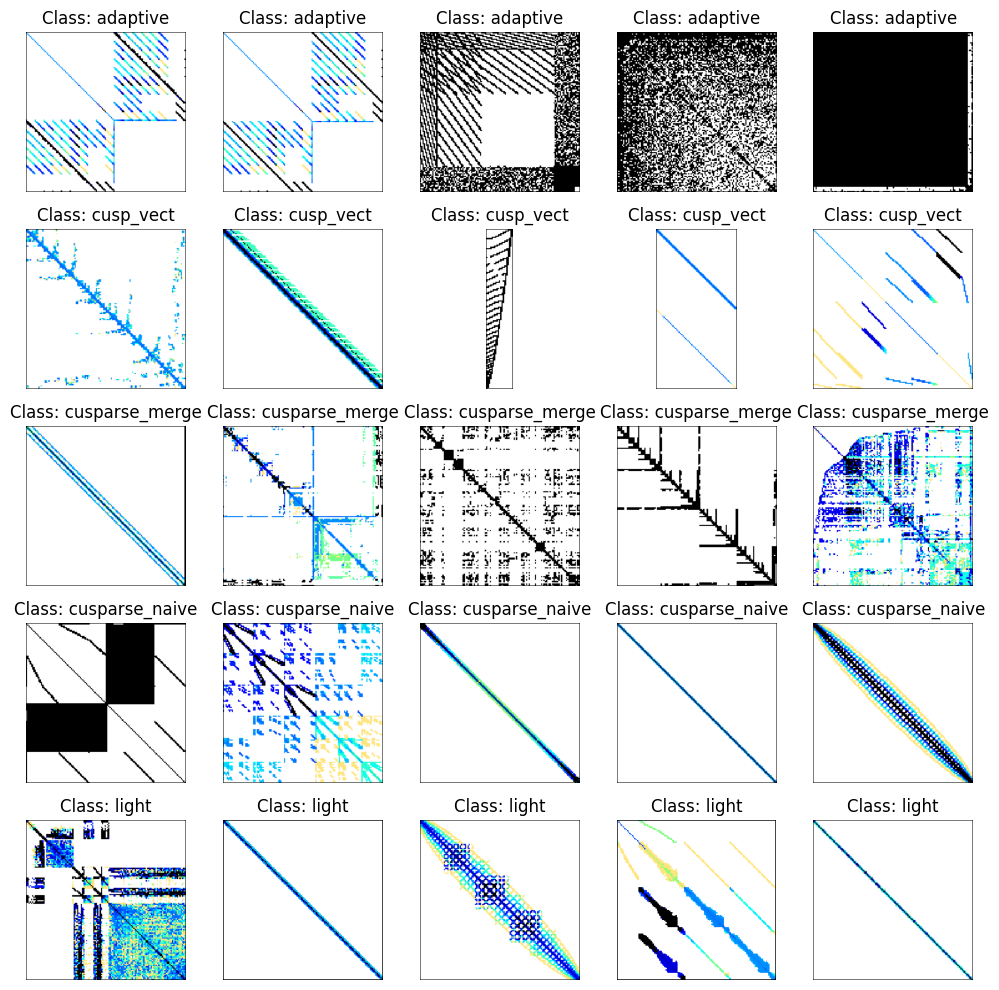

In [ ]:
image_manager.plot_images_by_label(data_val)

Se recorren las imágenes, imprimiendo shapes de mayor a menor, con el objetivo de controlar los tamaños más pequeños de imágen

In [ ]:
image_manager.get_unusual_images(data_train, limit=10)
image_manager.get_unusual_images(data_val, limit=10)
image_manager.get_unusual_images(data_test, limit=10)

Image Shapes (Largest to Smallest):
Shape: (3, 309), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/specular.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_22_8.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/connectus.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_17_8.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_18_9.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/connectus.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_19_9.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail4284.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/bibd_22_8.png
Shape: (391, 4), Path: /content/drive/MyDrive/ALN/tarea_final/sparse_matrices_png/rail2586.png
Image S

## Parte 2 - Métodos de clasificación sin agregar *features*

Se prueban los siguientes métodos de clasificación realizando un ajuste de hiperparámetros por *grid search*. El objetivo de esta parte es probar los modelos para obtener un punto de comparación a la hora de evaluar el funcionamiento del agregado de *features* obtenidas de un procesamiento de la imagen de la matriz.

- Decision Tree y RandomForests
- Regresión Logística y MLPs
- KNN
- SVM
- MLP

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = dataset_manager.leer_datasets()
evaluation_results, f1_scores = model_trainer.train_evaluate_models(X_train, y_train, X_val, y_val)

### Entrenando y evaluando el modelo **SVM**

### Entrenando y evaluando el modelo **MLP**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Entrenando y evaluando el modelo **RandomForest**

### Entrenando y evaluando el modelo **LogisticRegression**

### Entrenando y evaluando el modelo **KNN**

### Entrenando y evaluando el modelo **DecisionTree**

### F1 Scores

|    | Model              |   F1-Score (Weighted) |   F1-Score (Macro) |
|---:|:-------------------|----------------------:|-------------------:|
|  0 | SVM                |              0.489135 |           0.493071 |
|  1 | MLP                |              0.724266 |           0.588804 |
|  2 | RandomForest       |              0.906343 |           0.821372 |
|  3 | LogisticRegression |              0.524551 |           0.39251  |
|  4 | KNN                |              0.826547 |           0.724674 |
|  5 | DecisionTree       |              0.848981 |           0.755894 |

## Modelo: **SVM**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('svm', SVC(C=10, class_weight='balanced', random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'svm': SVC(C=10, class_weight='balanced', random_state=123), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'svm__C': 10, 'svm__break_ties': False, 'svm__cache_size': 200, 'svm__class_weight': 'balanced', 'svm__coef0': 0.0, 'svm__decision_function_shape': 'ovr', 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'svm__max_iter': -1, 'svm__probability': False, 'svm__random_state': 123, 'svm__shrinking': True, 'svm__tol': 0.001, 'svm__verbose': False}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.25     | 0.444444 |   0.32     |       9   |
| 1            |    0.75     | 0.205128 |   0.322148 |     117   |
| 2            |    0.808511 | 0.520548 |   0.633333 |      73   |
| 3            |    0.297297 | 0.862745 |   0.442211 |      51   |
| 4            |    0.701754 | 0.8      |   0.747664 |      50   |
| accuracy     |    0.5      | 0.5      |   0.5      |       0.5 |
| macro avg    |    0.561512 | 0.566573 |   0.493071 |     300   |
| weighted avg |    0.664237 | 0.5      |   0.489135 |     300   |

## Modelo: **MLP**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('mlp', MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=10000, random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'mlp': MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=10000, random_state=123), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__batch_size': 'auto', 'mlp__beta_1': 0.9, 'mlp__beta_2': 0.999, 'mlp__early_stopping': False, 'mlp__epsilon': 1e-08, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.001, 'mlp__max_fun': 15000, 'mlp__max_iter': 10000, 'mlp__momentum': 0.9, 'mlp__n_iter_no_change': 10, 'mlp__nesterovs_momentum': True, 'mlp__power_t': 0.5, 'mlp__random_state': 123, 'mlp__shuffle': True, 'mlp__solver': 'adam', 'mlp__tol': 0.0001, 'mlp__validation_fraction': 0.1, 'mlp__verbose': False, 'mlp__warm_start': False}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0        | 0        |   0        |   9        |
| 1            |    0.672956 | 0.91453  |   0.775362 | 117        |
| 2            |    0.80303  | 0.726027 |   0.76259  |  73        |
| 3            |    0.851852 | 0.45098  |   0.589744 |  51        |
| 4            |    0.833333 | 0.8      |   0.816327 |  50        |
| accuracy     |    0.743333 | 0.743333 |   0.743333 |   0.743333 |
| macro avg    |    0.632234 | 0.578308 |   0.588804 | 300        |
| weighted avg |    0.741561 | 0.743333 |   0.724266 | 300        |

## Modelo: **RandomForest**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('randomforest', RandomForestClassifier(n_estimators=200, random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'randomforest': RandomForestClassifier(n_estimators=200, random_state=123), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'randomforest__bootstrap': True, 'randomforest__ccp_alpha': 0.0, 'randomforest__class_weight': None, 'randomforest__criterion': 'gini', 'randomforest__max_depth': None, 'randomforest__max_features': 'sqrt', 'randomforest__max_leaf_nodes': None, 'randomforest__max_samples': None, 'randomforest__min_impurity_decrease': 0.0, 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 2, 'randomforest__min_weight_fraction_leaf': 0.0, 'randomforest__monotonic_cst': None, 'randomforest__n_estimators': 200, 'randomforest__n_jobs': None, 'randomforest__oob_score': False, 'randomforest__random_state': 123, 'randomforest__verbose': 0, 'randomforest__warm_start': False}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.6      | 0.333333 |   0.428571 |      9    |
| 1            |    0.91129  | 0.965812 |   0.937759 |    117    |
| 2            |    0.913043 | 0.863014 |   0.887324 |     73    |
| 3            |    0.884615 | 0.901961 |   0.893204 |     51    |
| 4            |    0.96     | 0.96     |   0.96     |     50    |
| accuracy     |    0.91     | 0.91     |   0.91     |      0.91 |
| macro avg    |    0.85379  | 0.804824 |   0.821372 |    300    |
| weighted avg |    0.905962 | 0.91     |   0.906343 |    300    |

## Modelo: **LogisticRegression**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('logisticregression', LogisticRegression(C=10, max_iter=10000, random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'logisticregression': LogisticRegression(C=10, max_iter=10000, random_state=123), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'logisticregression__C': 10, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': True, 'logisticregression__intercept_scaling': 1, 'logisticregression__l1_ratio': None, 'logisticregression__max_iter': 10000, 'logisticregression__multi_class': 'deprecated', 'logisticregression__n_jobs': None, 'logisticregression__penalty': 'l2', 'logisticregression__random_state': 123, 'logisticregression__solver': 'lbfgs', 'logisticregression__tol': 0.0001, 'logisticregression__verbose': 0, 'logisticregression__warm_start': False}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0        | 0        |   0        |      9    |
| 1            |    0.511521 | 0.948718 |   0.664671 |    117    |
| 2            |    0.795918 | 0.534247 |   0.639344 |     73    |
| 3            |    0        | 0        |   0        |     51    |
| 4            |    0.84375  | 0.54     |   0.658537 |     50    |
| accuracy     |    0.59     | 0.59     |   0.59     |      0.59 |
| macro avg    |    0.430238 | 0.404593 |   0.39251  |    300    |
| weighted avg |    0.533792 | 0.59     |   0.524551 |    300    |

## Modelo: **KNN**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('knn', KNeighborsClassifier(weights='distance'))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'knn': KNeighborsClassifier(weights='distance'), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.333333 | 0.222222 |   0.266667 |      9    |
| 1            |    0.852459 | 0.888889 |   0.870293 |    117    |
| 2            |    0.838235 | 0.780822 |   0.808511 |     73    |
| 3            |    0.823529 | 0.823529 |   0.823529 |     51    |
| 4            |    0.830189 | 0.88     |   0.854369 |     50    |
| accuracy     |    0.83     | 0.83     |   0.83     |      0.83 |
| macro avg    |    0.735549 | 0.719092 |   0.724674 |    300    |
| weighted avg |    0.824794 | 0.83     |   0.826547 |    300    |

## Modelo: **DecisionTree**

### Mejores Parámetros:

```python
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('decisiontree', DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'decisiontree': DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=123), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['rows', 'cols', 'aspect', 'nnz', 'min_nnz', 'max_nnz', 'avg_nnz', 'std_nnz']), ('cat', OneHotEncoder(handle_unknown='ignore'), [])], 'preprocessor__verbose': False, 'preprocessor__verbose_feature_names_out': True, 'preprocessor__num': StandardScaler(), 'preprocessor__cat': OneHotEncoder(handle_unknown='ignore'), 'preprocessor__num__copy': True, 'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True, 'preprocessor__cat__categories': 'auto', 'preprocessor__cat__drop': None, 'preprocessor__cat__dtype': <class 'numpy.float64'>, 'preprocessor__cat__feature_name_combiner': 'concat', 'preprocessor__cat__handle_unknown': 'ignore', 'preprocessor__cat__max_categories': None, 'preprocessor__cat__min_frequency': None, 'preprocessor__cat__sparse_output': True, 'decisiontree__ccp_alpha': 0.0, 'decisiontree__class_weight': None, 'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 10, 'decisiontree__max_features': None, 'decisiontree__max_leaf_nodes': None, 'decisiontree__min_impurity_decrease': 0.0, 'decisiontree__min_samples_leaf': 1, 'decisiontree__min_samples_split': 5, 'decisiontree__min_weight_fraction_leaf': 0.0, 'decisiontree__monotonic_cst': None, 'decisiontree__random_state': 123, 'decisiontree__splitter': 'best'}
```

### Resultados de Evaluación:

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.428571 | 0.333333 |   0.375    |      9    |
| 1            |    0.921053 | 0.897436 |   0.909091 |    117    |
| 2            |    0.847222 | 0.835616 |   0.841379 |     73    |
| 3            |    0.826923 | 0.843137 |   0.834951 |     51    |
| 4            |    0.781818 | 0.86     |   0.819048 |     50    |
| accuracy     |    0.85     | 0.85     |   0.85     |      0.85 |
| macro avg    |    0.761118 | 0.753905 |   0.755894 |    300    |
| weighted avg |    0.849105 | 0.85     |   0.848981 |    300    |

### Matriz de Confusión para SVM:

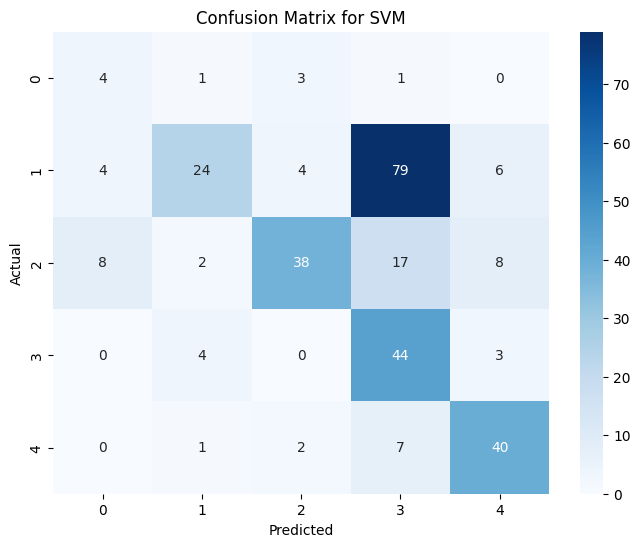

### Matriz de Confusión para MLP:

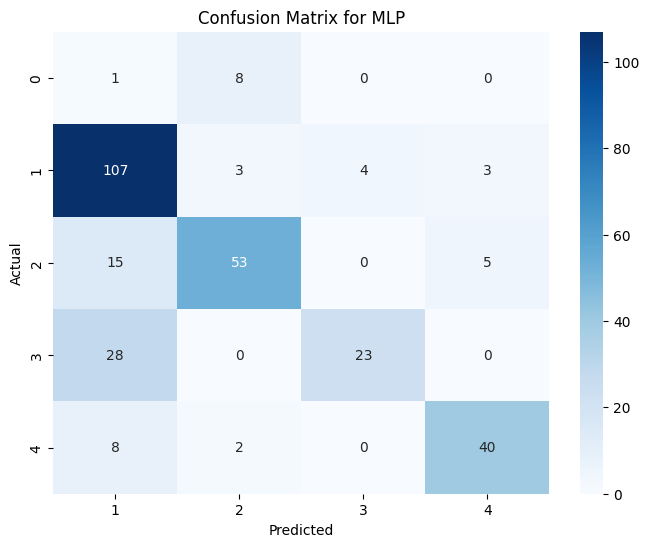

### Matriz de Confusión para RandomForest:

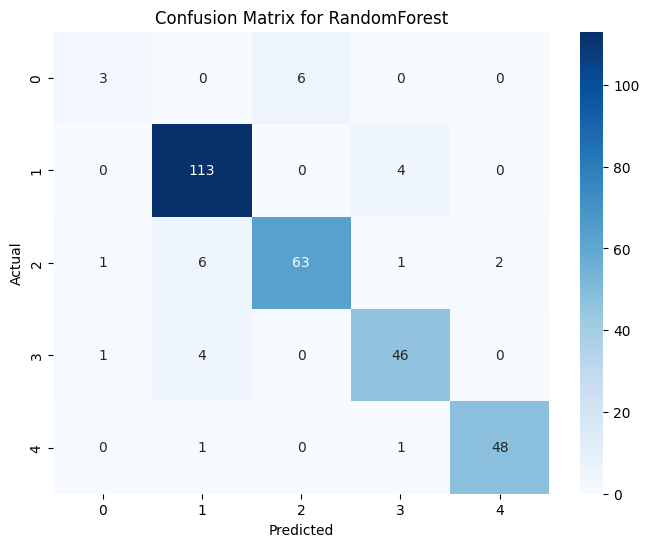

### Matriz de Confusión para LogisticRegression:

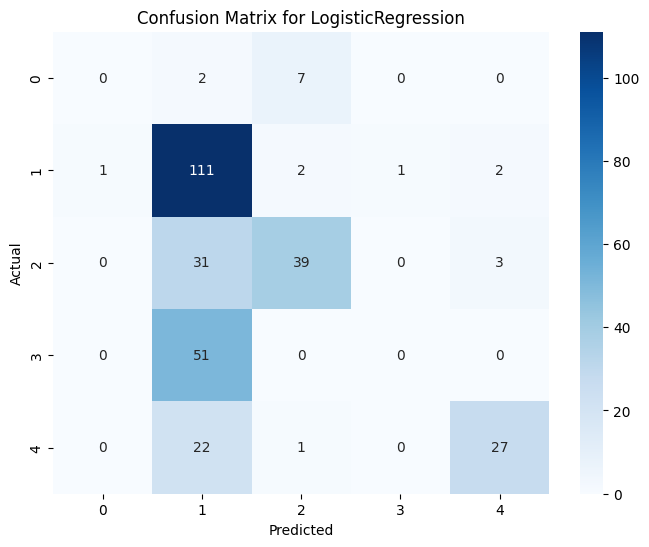

### Matriz de Confusión para KNN:

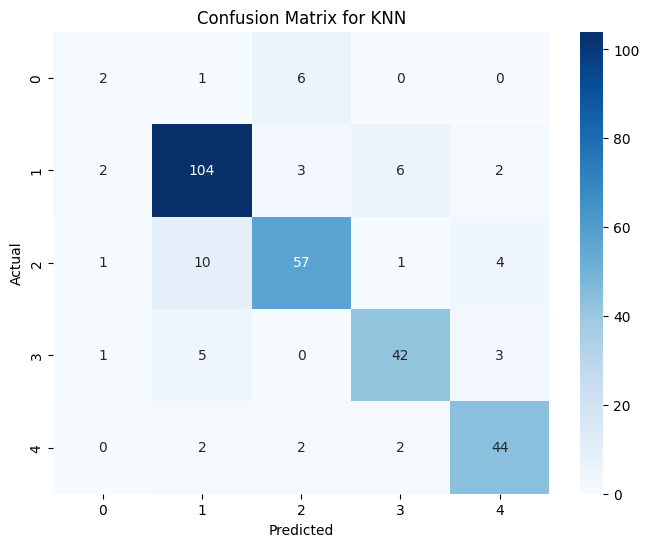

### Matriz de Confusión para DecisionTree:

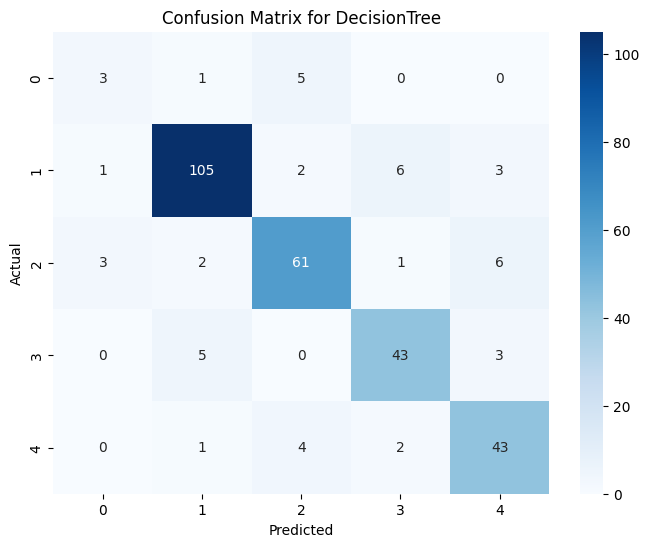

In [ ]:
model_trainer.print_results(evaluation_results)

## Parte 3 - Modelos de extracción de features

Las tres partes anteriores se realizan utilizando CPU. Normalmente para ejecutar esta parte se debe utilizar GPU dado que las implementaciones de CNN en GPU permiten reducir considerablemente los tiempos de entrenamiento. Otro motivo es el límite de uso en Colab, el cual motiva aún más a utilizar la menor cantidad de tiempo posible los recursos de GPU

Por lo tanto, es necesario incluir una carga de datos en esta parte nuevamente para hacer más cómodo el desarrollo. La idea es que simplemente se debe ejecutar la primer celda de la tarea y luego pasar a ejecutar esta sección. Siendo esto último posible debido al guardado de datos que permite la integración con Google Drive.

In [ ]:
data_train, data_val, data_test = dataset_manager.leer_datasets_raiz()
X_train, X_val, X_test, y_train, y_val, y_test = dataset_manager.leer_datasets()

train_df = data_train[['path_png', 'ganador']]
val_df = data_val[['path_png', 'ganador']]
test_df = data_test[['path_png', 'ganador']]

### 3.1 Modelos ResNet50

#### 3.1.1 Inferencia e Incorporación de las features a los modelos de apredizaje automático

Tenemos 3 modelos:

*   ```model_pretrained:``` Una ResNet50 entrenada con las imágenes y las clases provistas, que ofrece como características de cada imagen los *logits* obtenidos de la inferencia completa del modelo.
*  ```model_finetuned_svd:``` La misma ResNet50 pero sometida a un truncamiento por SVD de las features para reducir la dimensión de las características. Esto se lleva a cabo debido a que se considera importante que las otras características de los noceros no pierdan fuerza a la hora de realizar los entrenamientos. Si agregamos muchas características de imágenes, algunos modelos de ML pueden prestar menos importancia a las ya relevadas.
*  ```model_svd:``` Una ResNet50 pre-entrenada cuya inferencia de cada imagen da como resultado un vector de 512 características, reducido a 10 también por el motivo del punto anterior.



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


[Época 1/15] Pérdida Train: 1.3107 | Acc. Train: 0.4467 || Pérdida Val: 1.1456 | Acc. Val: 0.5167
--> ¡Mejor modelo guardado! /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pth


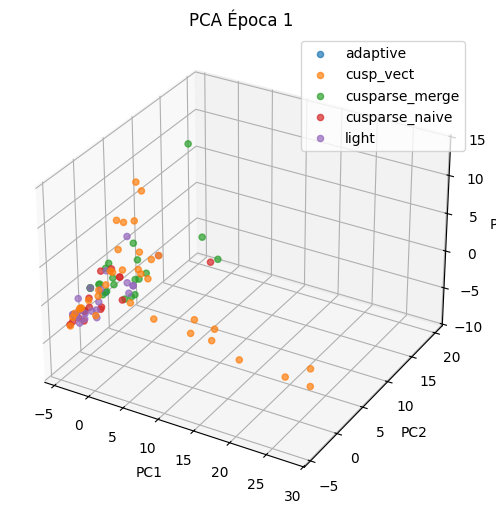

[Época 2/15] Pérdida Train: 1.1243 | Acc. Train: 0.5446 || Pérdida Val: 1.0401 | Acc. Val: 0.6067
--> ¡Mejor modelo guardado! /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pth


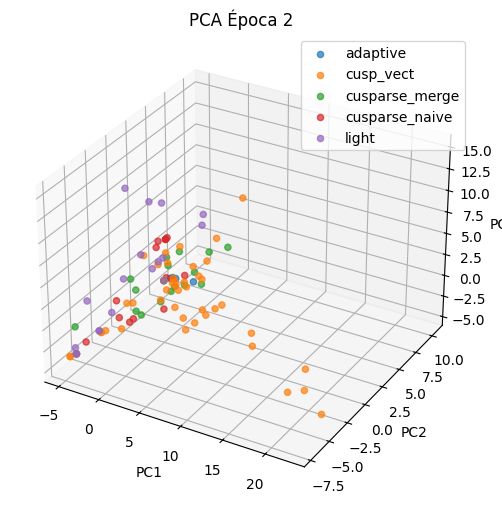

[Época 3/15] Pérdida Train: 1.0030 | Acc. Train: 0.5988 || Pérdida Val: 0.9660 | Acc. Val: 0.6300
--> ¡Mejor modelo guardado! /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pth


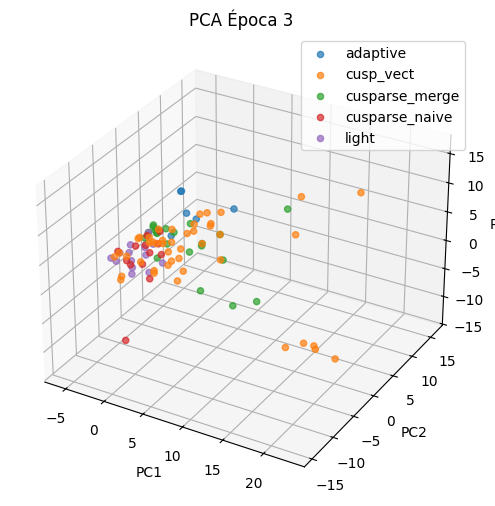

[Época 4/15] Pérdida Train: 0.9165 | Acc. Train: 0.6379 || Pérdida Val: 0.9674 | Acc. Val: 0.6367


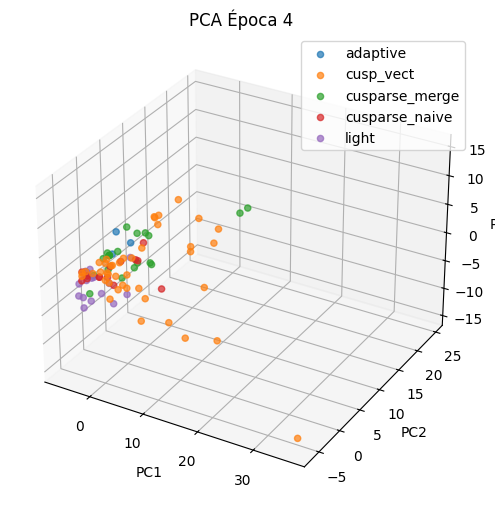

[Época 5/15] Pérdida Train: 0.8286 | Acc. Train: 0.6779 || Pérdida Val: 0.9626 | Acc. Val: 0.6333
--> ¡Mejor modelo guardado! /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pth


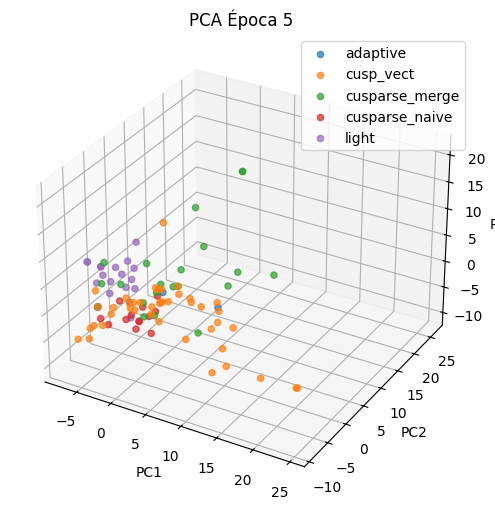

[Época 6/15] Pérdida Train: 0.7611 | Acc. Train: 0.7033 || Pérdida Val: 0.8946 | Acc. Val: 0.6667
--> ¡Mejor modelo guardado! /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pth


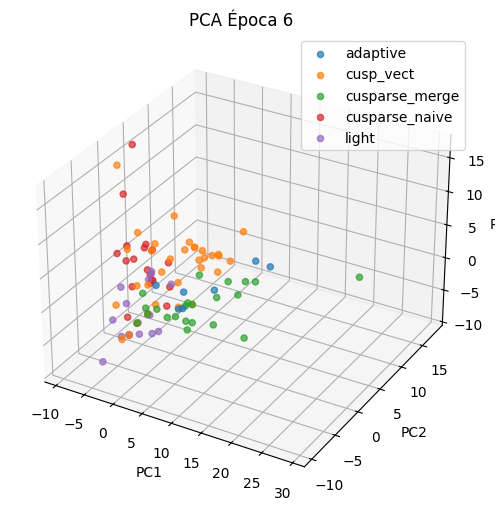

[Época 7/15] Pérdida Train: 0.7165 | Acc. Train: 0.7137 || Pérdida Val: 1.0196 | Acc. Val: 0.6600


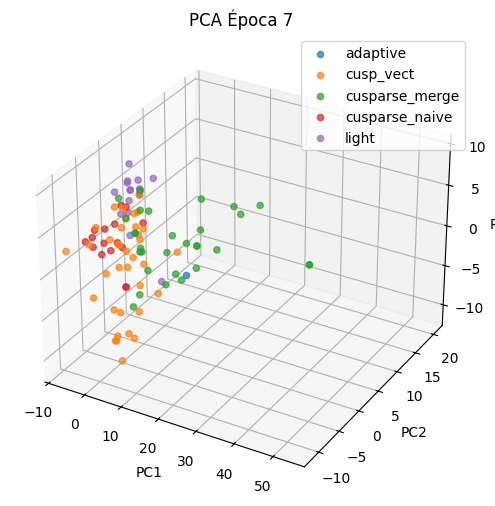

[Época 8/15] Pérdida Train: 0.6834 | Acc. Train: 0.7296 || Pérdida Val: 0.9030 | Acc. Val: 0.6700


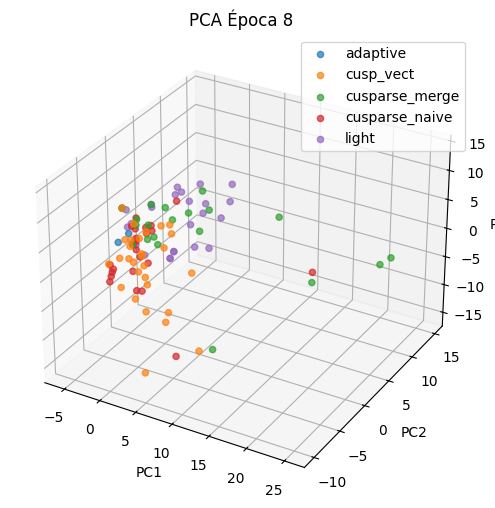

[Época 9/15] Pérdida Train: 0.6580 | Acc. Train: 0.7296 || Pérdida Val: 1.0125 | Acc. Val: 0.6633
Early Stopping en la época 9.
Último modelo guardado en: /content/drive/MyDrive/ALN/tarea_final/checkpoints/last_model.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
all_classes = sorted(list(train_df['ganador'].unique()))
label2idx = {class_name: data_train.loc[train_df['ganador'] == class_name, 'ganador_encoded'].iloc[0] for class_name in all_classes}
label2class = {v: k for k, v in label2idx.items()}
train_loader, val_loader = dataset_manager.create_dataloaders(train_df, val_df, label2idx, batch_size=8)


model_finetuned_svd = feature_extractor.finetune_resnet50(
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=len(all_classes),
    epochs=15,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    patience=3,
    save_dir=config.PATH_CHECKPOINTS,
    dimension_pca=3,
    num_samples_for_pca=100,
    label2class=label2class
)


model_pretrained = feature_extractor.obtener_resnet_pretrained()

model_svd = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_svd.eval()

Se extraen las características utilizando ```model_pretrained```, ```model_svd``` y ```model_finetuned_svd```.

In [ ]:
data_train_pretrained = feature_extractor.extract_features_to_df(df=data_train, model=model_pretrained, transform_size=224, prefix="pretrained")
data_val_pretrained =  feature_extractor.extract_features_to_df(df=data_val, model=model_pretrained,transform_size=224, prefix="pretrained")
data_test_pretrained =  feature_extractor.extract_features_to_df(df=data_test, model=model_pretrained,transform_size=224, prefix="pretrained")

data_train_svd =  feature_extractor.extract_features_with_svd(df=data_train, model=model_svd, transform_size=224, svd_components=10, prefix="svd")
data_val_svd =  feature_extractor.extract_features_with_svd(df=data_val, model=model_svd, transform_size=224, svd_components=10, prefix="svd")
data_test_svd =  feature_extractor.extract_features_with_svd(df=data_test, model=model_svd, transform_size=224, svd_components=10, prefix="svd")

data_train_finetuned_svd =  feature_extractor.extract_features_with_svd(df=data_train, model=model_finetuned_svd, transform_size=224, svd_components=5, prefix="finetuned_svd")
data_val_finetuned_svd =  feature_extractor.extract_features_with_svd(df=data_val, model=model_finetuned_svd, transform_size=224, svd_components=5, prefix="finetuned_svd")
data_test_finetuned_svd =  feature_extractor.extract_features_with_svd(df=data_test, model=model_finetuned_svd, transform_size=224, svd_components=5, prefix="finetuned_svd")

data_train_pretrained.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_pretrained.csv"), index=False)
data_val_pretrained.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,  "data_val_pretrained.csv"),   index=False)
data_test_pretrained.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_test_pretrained.csv"),  index=False)

data_train_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_svd.csv"), index=False)
data_val_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,   "data_val_svd.csv"),   index=False)
data_test_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,  "data_test_svd.csv"),  index=False)

data_train_finetuned_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_svd_finetuned.csv"), index=False)
data_val_finetuned_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,  "data_val_svd_finetuned.csv"),   index=False)
data_test_finetuned_svd.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_test_svd_finetuned.csv"),  index=False)

100%|██████████| 301/301 [00:03<00:00, 76.71it/s]


### 3.2 Block Sampling

In [ ]:
data_train_block = feature_extractor.generar_features_limited_block_sampling(data_train, num_blocks_h=4, num_blocks_w=5)
data_val_block = feature_extractor.generar_features_limited_block_sampling(data_val, num_blocks_h=4, num_blocks_w=5)
data_test_block = feature_extractor.generar_features_limited_block_sampling(data_test, num_blocks_h=4, num_blocks_w=5)

data_train_block = data_train_block.dropna()

data_train_block.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_block.csv"), index=False)
data_val_block.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,   "data_val_block.csv"),   index=False)
data_test_block.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES,  "data_test_block.csv"),  index=False)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


### 3.3 HOG, SIFT, Orb y Color Histogram Features

In [ ]:
data_train, data_val, data_test = dataset_manager.leer_datasets_raiz()

for name, func in zip(['HOG', 'SIFT', 'ORB', 'COLOR_HIST'],
                      [feature_extractor.extract_hog_features, feature_extractor.extract_sift_features, feature_extractor.extract_orb_features,
                       feature_extractor.extract_color_histogram]):
    print(f"Procesando {name}...")
    train_processed = feature_extractor.process_dataframe(data_train, func)
    val_processed = feature_extractor.process_dataframe(data_val, func)
    test_processed = feature_extractor.process_dataframe(data_test, func)

    train_processed.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, f'data_train_{name}.csv'), index=False)
    val_processed.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, f'data_val_{name}.csv'), index=False)
    test_processed.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, f'data_test_{name}.csv'), index=False)

Procesando HOG...


100%|██████████| 301/301 [00:05<00:00, 55.79it/s]


Procesando SIFT...


100%|██████████| 301/301 [00:16<00:00, 18.67it/s]


Procesando ORB...


100%|██████████| 301/301 [00:02<00:00, 105.36it/s]


Procesando COLOR_HIST...


100%|██████████| 301/301 [00:01<00:00, 151.25it/s]


### 3.4 Vision Transformers

In [ ]:
from transformers import ViTImageProcessor, ViTModel

processor_vit = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")


data_train_vit = feature_extractor.extract_and_visualize_svd_vit(data_train, model=model_vit, processor=processor_vit)
data_val_vit = feature_extractor.extract_and_visualize_svd_vit(data_val, model=model_vit, processor=processor_vit)
data_test_vit = feature_extractor.extract_and_visualize_svd_vit(data_test, model=model_vit, processor=processor_vit)

data_train_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_vit_svd.csv"), index=False)
data_val_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_val_vit_svd.csv"), index=False)
data_test_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_test_vit_svd.csv"), index=False)

### 3.4.1 Fine tuning

Epoch 1/25 - Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 1/25 - Train Loss: 1.4814, Val Loss: 1.3616, Val Acc: 40.21%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 2/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 2/25 - Train Loss: 1.3565, Val Loss: 1.2604, Val Acc: 46.98%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 3/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Epoch 3/25 - Train Loss: 1.2742, Val Loss: 1.1918, Val Acc: 55.52%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 4/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


Epoch 4/25 - Train Loss: 1.2012, Val Loss: 1.1387, Val Acc: 57.65%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 5/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 5/25 - Train Loss: 1.1241, Val Loss: 1.0751, Val Acc: 58.01%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 6/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


Epoch 6/25 - Train Loss: 1.0558, Val Loss: 1.0120, Val Acc: 62.99%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 7/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


Epoch 7/25 - Train Loss: 0.9990, Val Loss: 0.9648, Val Acc: 66.55%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 8/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Epoch 8/25 - Train Loss: 0.9441, Val Loss: 0.9423, Val Acc: 64.77%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 9/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Epoch 9/25 - Train Loss: 0.9128, Val Loss: 0.9199, Val Acc: 66.55%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 10/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Epoch 10/25 - Train Loss: 0.8548, Val Loss: 0.8893, Val Acc: 67.62%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 11/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


Epoch 11/25 - Train Loss: 0.8276, Val Loss: 0.9150, Val Acc: 66.19%
No mejora en val_loss. Épocas sin mejora: 1/5


Epoch 12/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 12/25 - Train Loss: 0.8116, Val Loss: 0.8676, Val Acc: 68.33%
Mejora en val_loss. Modelo guardado en /content/drive/MyDrive/ALN/tarea_final/checkpoints/best_model.pt


Epoch 13/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Epoch 13/25 - Train Loss: 0.7771, Val Loss: 0.8886, Val Acc: 65.12%
No mejora en val_loss. Épocas sin mejora: 1/5


Epoch 14/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


Epoch 14/25 - Train Loss: 0.7489, Val Loss: 0.8833, Val Acc: 66.19%
No mejora en val_loss. Épocas sin mejora: 2/5


Epoch 15/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Epoch 15/25 - Train Loss: 0.7248, Val Loss: 0.8983, Val Acc: 65.12%
No mejora en val_loss. Épocas sin mejora: 3/5


Epoch 16/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Epoch 16/25 - Train Loss: 0.7053, Val Loss: 0.8943, Val Acc: 65.48%
No mejora en val_loss. Épocas sin mejora: 4/5


Epoch 17/25 - Validation: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 17/25 - Train Loss: 0.6917, Val Loss: 0.8911, Val Acc: 66.19%
No mejora en val_loss. Épocas sin mejora: 5/5
Early stopping activado después de 17 épocas.
Mejor modelo cargado.


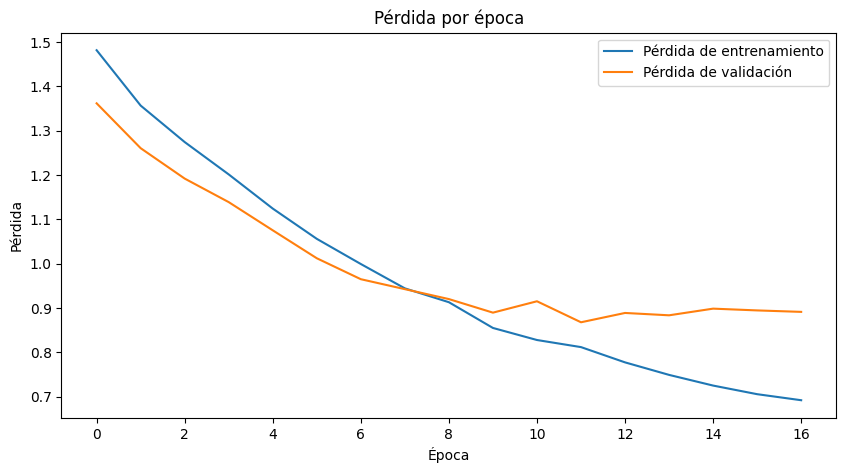

In [ ]:
model_vit = feature_extractor.fine_tune_vit_classifier(
    train_dir=os.path.join(config.DATASET_YOLO, 'train'),
    val_dir=os.path.join(config.DATASET_YOLO, 'val'),
    num_labels=5,
    epochs=25,
    patience=5,
    lr=2e-5,
    batch_size=32
)

In [ ]:
model_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=5)
model_vit.load_state_dict(torch.load(os.path.join(config.PATH_CHECKPOINTS, "best_model_vit.pt")))
model_vit.to(config.device)

processor_vit = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
data_train_vit = feature_extractor.extract_and_visualize_svd_vit_finetuned(
    data_train, model_vit, processor_vit, num_images_per_class=20, dimension=3
)

data_val_vit = feature_extractor.extract_and_visualize_svd_vit_finetuned(
    data_val, model_vit, processor_vit, num_images_per_class=20, dimension=3
)

data_test_vit = feature_extractor.extract_and_visualize_svd_vit_finetuned(
    data_test, model_vit, processor_vit, num_images_per_class=20, dimension=3
)

data_train_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_vit_svd_finetuned.csv"), index=False)
data_val_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_val_vit_svd_finetuned.csv"), index=False)
data_test_vit.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_test_vit_svd_finetuned.csv"), index=False)

### 3.5 YOLO

Acomodamos las fotos para YOLO

In [ ]:
dataset_manager.organize_images_for_yolo(data_train, data_val, data_test)

Despues arrancamos viendo que modelo de YOLO es mejor

In [ ]:
models_paths = [
    "yolov8n-cls.pt",
    "yolov8m-cls.pt",
    "yolov8s-cls.pt"
]

best_model_path = model_trainer.investigate_best_yolo(
    models_paths=models_paths,
    dataset_path=config.DATASET_YOLO,
    val_folder=os.path.join(config.DATASET_YOLO , "val"),
    epochs=10,
    imgsz=224
)
print(f"El mejor modelo encontrado fue: {best_model_path}")

100%|██████████| 5.31M/5.31M [00:00<00:00, 333MB/s]
100%|██████████| 5.35M/5.35M [00:00<00:00, 290MB/s]
train: Scanning /content/drive/MyDrive/ALN/tarea_final/matrices_yolo/train... 1425 images, 23 corrupt: 100%|██████████| 1448/1448 [09:51<00:00,  2.45it/s]
val: Scanning /content/drive/MyDrive/ALN/tarea_final/matrices_yolo/val... 279 images, 2 corrupt: 100%|██████████| 281/281 [01:49<00:00,  2.57it/s]
       1/10     0.572G      1.687         16        224:  18%|█▊        | 16/90 [00:03<00:11,  6.18it/s]
100%|██████████| 755k/755k [00:00<00:00, 99.6MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
      10/10     0.549G      1.203          1        224: 100%|██████████| 90/90 [00:15<00:00,  5.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
100%|██████████| 32.7M/32.7M [00:01<00:00, 24.3MB/s]
train: Scanning /content/drive/MyDrive/ALN/tarea_final/matrices_yolo/train... 1425 images, 23 co

El mejor modelo encontrado fue: yolov8s-cls.pt


Luego buscamos hiperparametros para ese

In [ ]:
model = YOLO(best_model_path)
model.tune(
    data=config.DATASET_YOLO,
    epochs=10,
    iterations=20,
    imgsz=224,
    device=config.device,
    optimizer="AdamW",
    plots=True,
    save=True,
    val=True,
    augment=False,
    project=config.RUNS_FOLDER,
    name='best_tune',
)
hyper = model.hyp

Entrenamos bastante el que sacó mejores hiper

In [ ]:
model = model_trainer.train_best_model(best_model_path,config.DATASET_YOLO,epochs=50,hyp=hyper)

train: Scanning /content/drive/MyDrive/ALN/tarea_final/matrices_yolo/train... 1425 images, 23 corrupt: 100%|██████████| 1425/1425 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/ALN/tarea_final/matrices_yolo/val... 279 images, 2 corrupt: 100%|██████████| 279/279 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s]
      10/50     0.541G      1.275          1        224: 100%|██████████| 90/90 [00:15<00:00,  5.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
      11/50     0.557G      1.252          1        224: 100%|██████████| 90/90 [00:15<00:00,  5.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]
      12/50     0.555G      1.229          1        224: 100%|██████████| 90/90 [00:15<00:00,  5.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]
      13/50     0.549G      1.2

Y finalmente extraemos features

In [ ]:
data_train_yolo = feature_extractor.extract_features_yolo(df=data_train,model=model,imgsz=224)
data_train_yolo.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_train_yolo.csv"), index=False)

data_test_yolo = feature_extractor.extract_features_yolo(df=data_test,model=model,imgsz=224)
data_test_yolo.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_test_yolo.csv"), index=False)

data_val_yolo = feature_extractor.extract_features_yolo(df=data_val,model=model,imgsz=224)
data_val_yolo.to_csv(os.path.join(config.PATH_FEATURES_ADICIONALES, "data_val_yolo.csv"), index=False)

## Parte 4 - Clasificación con nuevas features

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Hiperparámetros y resultados guardados en: /content/drive/MyDrive/ALN/tarea_final/results/val_results.json
Mejor escenario global: HOG_SIFT_vit_svd (F1-Macro: 0.8670)
0.8626106231736521 0.9132091672609755


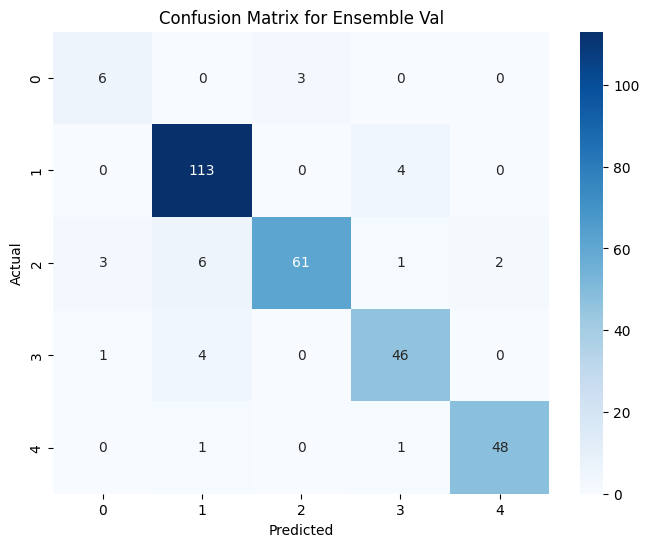

In [ ]:
cols_to_drop = ['group','matrix','ganador','path_png','ganador_encoded','path_png_encoded','time_extraction_sec']
data_train, data_val, data_test = dataset_manager.leer_datasets_raiz()
X_train_base, X_val_base, X_test_base, y_train_base, y_val_base, y_test_base = dataset_manager.leer_datasets()

feat_list = [
    ("pretrained",  None),
    ("svd",         None),
    ("svd_finetuned", None),
    ("block",       None),
    ("HOG",         None),
    ("SIFT",        None),
    ("ORB",         None),
    ("COLOR_HIST",  None),
    ("vit_svd",     None),
    ("vit_svd_finetuned", None),
    ("yolo",        None),
]

all_scenarios = {}
for feat_name, _ in feat_list:
    tr, va, te = dataset_manager.leer_features_adicionales(feat_name)
    Xtr, Ytr = dataset_manager.get_X_y(tr, cols_to_drop)
    Xva, Yva = dataset_manager.get_X_y(va, cols_to_drop)
    Xte, Yte = dataset_manager.get_X_y(te, cols_to_drop)
    all_scenarios[feat_name] = {"X_train": Xtr, "y_train": Ytr, "X_val": Xva, "y_val": Yva}

all_scenarios["normal"] = {"X_train": X_train_base, "y_train": y_train_base, "X_val": X_val_base, "y_val": y_val_base}

param_grid = {
    'randomforest__n_estimators': [50, 100, 200],
    'randomforest__max_depth': [None, 10, 20],
    'randomforest__min_samples_split': [2, 5]
}

results_val, topn = model_trainer.evaluate_all_scenarios_random_forest(all_scenarios, param_grid, n=5)
all_scenarios2 = model_trainer.create_all_scenarios(all_scenarios, topn)
results_multi, top1 = model_trainer.evaluate_all_scenarios_random_forest(all_scenarios2, param_grid, n=1)
feature_extractor.save_topn(topn if 'normal' not in topn else topn.remove('normal'), filepath="topn.json")
feature_extractor.save_val_results(results_val, results_multi, filepath="val_results.json")
model_trainer.save_best_scenario(top1[0])

best_model = results_multi[top1[0]]["evaluation_results"]["best_model"]
normal_model = results_val["normal"]["evaluation_results"]["best_model"]
X_val_ens = all_scenarios2[top1[0]]["X_val"].copy()
y_val_ens = all_scenarios2[top1[0]]["y_val"]
for c in X_train_base.columns:
    X_val_ens[c] = all_scenarios["normal"]["X_val"][c]
ensemble_preds_val = model_trainer.ensemble_predict(X_val_ens, best_model, normal_model, 0)
mf, wf, cm_ens, cr_ens = model_trainer.evaluate_ensemble(y_val_ens, ensemble_preds_val)
print(mf, wf)
model_trainer.ver_matriz_confusion('Ensemble Val', cm_ens)
model_trainer.save_ensemble_models(best_model, normal_model)


In [ ]:
from IPython.display import display, Markdown

def get_f1_scores_markdown(filepath="val_results.json"):
    import json
    filepath = os.path.join(config.RESULTS_DIR, filepath)

    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)

    results = data.get("results", {})
    results_multi = data.get("results_multi", {})

    table = []
    for s in results:
        fs = results[s].get("f1_scores", [])
        if fs:
            r = fs[0]
            table.append([s, r["F1-Score (Weighted)"], r["F1-Score (Macro)"]])
    for s in results_multi:
        fs = results_multi[s].get("f1_scores", [])
        if fs:
            r = fs[0]
            table.append([s, r["F1-Score (Weighted)"], r["F1-Score (Macro)"]])

    table.sort(key=lambda x: x[2], reverse=True)

    markdown_str = "| Escenario | Weighted F1 | Macro F1 |\n"
    markdown_str += "|-----------|-------------|----------|\n"
    for row in table:
        markdown_str += f"| {row[0]} | {row[1]:.4f} | {row[2]:.4f} |\n"

    return markdown_str

In [ ]:
display(Markdown(get_f1_scores_markdown()))

| Escenario | Weighted F1 | Macro F1 |
|-----------|-------------|----------|
| HOG_SIFT_vit_svd | 0.9058 | 0.8670 |
| COLOR_HIST_HOG_SIFT_vit_svd_vit_svd_finetuned | 0.8958 | 0.8670 |
| COLOR_HIST_vit_svd_finetuned | 0.9096 | 0.8663 |
| vit_svd_vit_svd_finetuned | 0.9097 | 0.8661 |
| COLOR_HIST_HOG_vit_svd_vit_svd_finetuned | 0.8956 | 0.8653 |
| HOG_vit_svd_finetuned | 0.8923 | 0.8652 |
| HOG_vit_svd_vit_svd_finetuned | 0.8890 | 0.8629 |
| HOG_SIFT | 0.9050 | 0.8626 |
| COLOR_HIST_HOG_vit_svd_finetuned | 0.9018 | 0.8584 |
| COLOR_HIST_HOG_vit_svd | 0.9017 | 0.8566 |
| COLOR_HIST_HOG_SIFT_vit_svd | 0.8986 | 0.8559 |
| vit_svd | 0.9055 | 0.8543 |
| COLOR_HIST_HOG | 0.8949 | 0.8541 |
| vit_svd_finetuned | 0.9019 | 0.8529 |
| HOG_vit_svd | 0.8917 | 0.8491 |
| COLOR_HIST_HOG_SIFT | 0.8986 | 0.8490 |
| COLOR_HIST | 0.9042 | 0.8451 |
| SIFT | 0.8919 | 0.8431 |
| COLOR_HIST_SIFT_vit_svd_finetuned | 0.9007 | 0.8424 |
| SIFT_vit_svd_vit_svd_finetuned | 0.8987 | 0.8422 |
| COLOR_HIST_SIFT_vit_svd_vit_svd_finetuned | 0.9009 | 0.8410 |
| SIFT_vit_svd | 0.8955 | 0.8402 |
| COLOR_HIST_SIFT_vit_svd | 0.8973 | 0.8385 |
| SIFT_vit_svd_finetuned | 0.8921 | 0.8376 |
| HOG | 0.8906 | 0.8343 |
| pretrained | 0.8687 | 0.8307 |
| HOG_SIFT_vit_svd_finetuned | 0.8941 | 0.8307 |
| ORB | 0.8870 | 0.8298 |
| COLOR_HIST_vit_svd_vit_svd_finetuned | 0.9017 | 0.8289 |
| yolo | 0.8909 | 0.8275 |
| block | 0.8910 | 0.8240 |
| COLOR_HIST_vit_svd | 0.8947 | 0.8240 |
| COLOR_HIST_HOG_SIFT_vit_svd_finetuned | 0.8876 | 0.8236 |
| HOG_SIFT_vit_svd_vit_svd_finetuned | 0.8877 | 0.8227 |
| normal | 0.9063 | 0.8214 |
| svd_finetuned | 0.8548 | 0.7956 |
| COLOR_HIST_SIFT | 0.8872 | 0.7893 |
| svd | 0.8690 | 0.7126 |


## Parte 5 - Evaluación Final

Datos cargados desde: /content/drive/MyDrive/ALN/tarea_final/results/val_results.json
Mejor escenario global: HOG_SIFT_vit_svd (F1-Macro: 0.8670447171674425)

=== Test results for 'pretrained' ===
              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.86      0.89      0.88       123
           2       0.90      0.90      0.90        60
           3       0.92      0.73      0.82        64
           4       0.81      0.98      0.89        45

    accuracy                           0.86       301
   macro avg       0.80      0.79      0.79       301
weighted avg       0.86      0.86      0.86       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  3 110   5   4   1]
 [  0   2  54   0   4]
 [  1  11   0  47   5]
 [  0   1   0   0  44]]


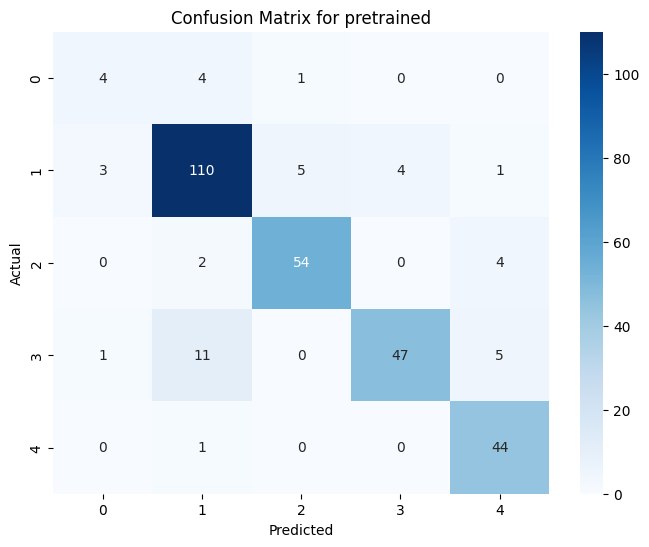

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p


=== Test results for 'svd' ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.87      0.93      0.90       123
           2       0.85      0.93      0.89        60
           3       0.94      0.75      0.83        64
           4       0.85      0.98      0.91        45

    accuracy                           0.87       301
   macro avg       0.70      0.72      0.71       301
weighted avg       0.85      0.87      0.86       301

Matriz de confusión:
 [[  0   4   5   0   0]
 [  0 115   5   3   0]
 [  0   3  56   0   1]
 [  0   9   0  48   7]
 [  0   1   0   0  44]]


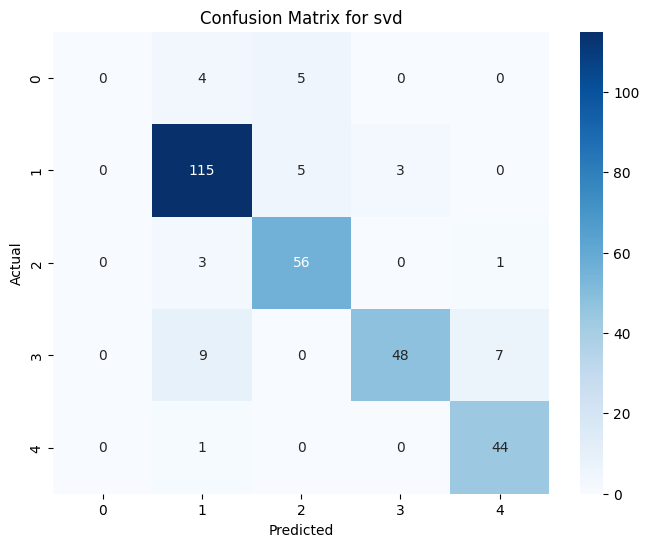


=== Test results for 'svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.72      0.91      0.81       123
           2       0.87      0.88      0.88        60
           3       0.89      0.39      0.54        64
           4       0.86      0.98      0.92        45

    accuracy                           0.79       301
   macro avg       0.77      0.70      0.71       301
weighted avg       0.80      0.79      0.77       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 112   6   3   0]
 [  0   5  53   0   2]
 [  1  33   0  25   5]
 [  0   1   0   0  44]]


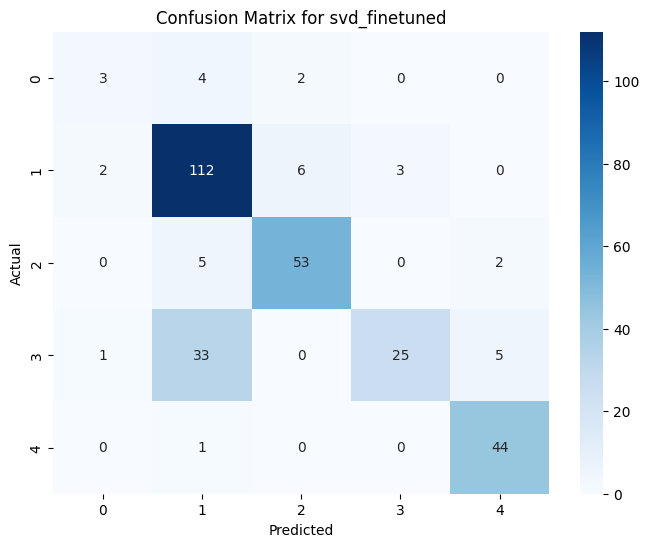


=== Test results for 'block' ===
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.88      0.93      0.90       123
           2       0.93      0.92      0.92        60
           3       0.94      0.75      0.83        64
           4       0.85      0.98      0.91        45

    accuracy                           0.88       301
   macro avg       0.81      0.80      0.80       301
weighted avg       0.88      0.88      0.88       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  3 114   3   3   0]
 [  1   3  55   0   1]
 [  1   8   0  48   7]
 [  0   1   0   0  44]]


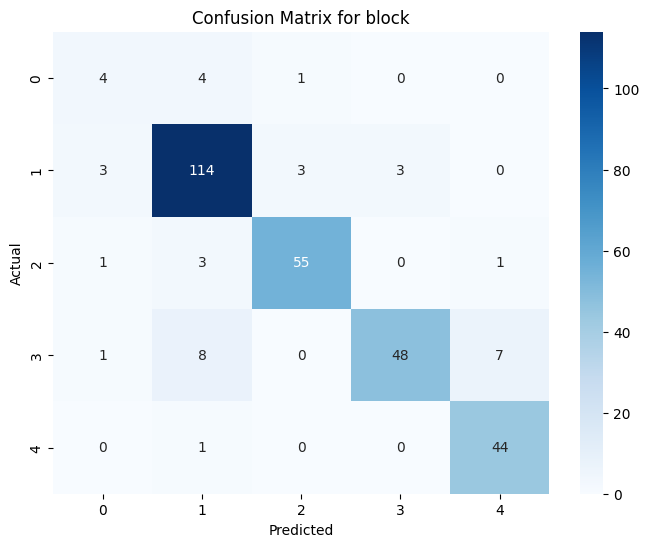


=== Test results for 'HOG' ===
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.87      0.95      0.91       123
           2       0.92      0.95      0.93        60
           3       0.96      0.75      0.84        64
           4       0.86      0.96      0.91        45

    accuracy                           0.89       301
   macro avg       0.88      0.81      0.83       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  0 117   3   2   1]
 [  0   2  57   0   1]
 [  1  10   0  48   5]
 [  0   1   1   0  43]]


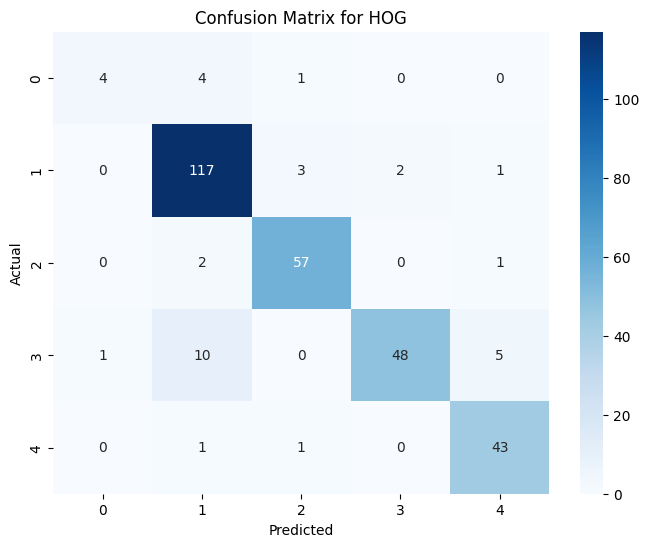


=== Test results for 'SIFT' ===
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.87      0.93      0.90       123
           2       0.93      0.92      0.92        60
           3       0.94      0.75      0.83        64
           4       0.88      0.98      0.93        45

    accuracy                           0.88       301
   macro avg       0.81      0.80      0.81       301
weighted avg       0.89      0.88      0.88       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 115   3   3   0]
 [  2   2  55   0   1]
 [  1  10   0  48   5]
 [  0   1   0   0  44]]


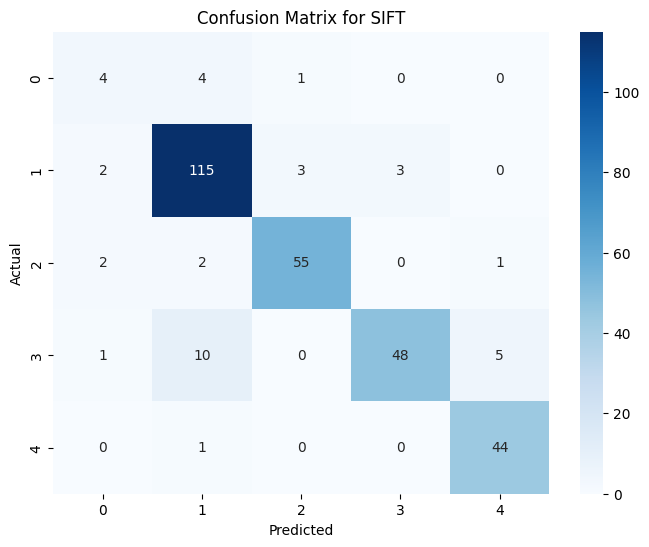


=== Test results for 'ORB' ===
              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.88      0.93      0.91       123
           2       0.93      0.90      0.92        60
           3       0.94      0.78      0.85        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.82      0.81      0.81       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 115   3   3   0]
 [  2   2  54   0   2]
 [  0   9   0  50   5]
 [  0   1   0   0  44]]


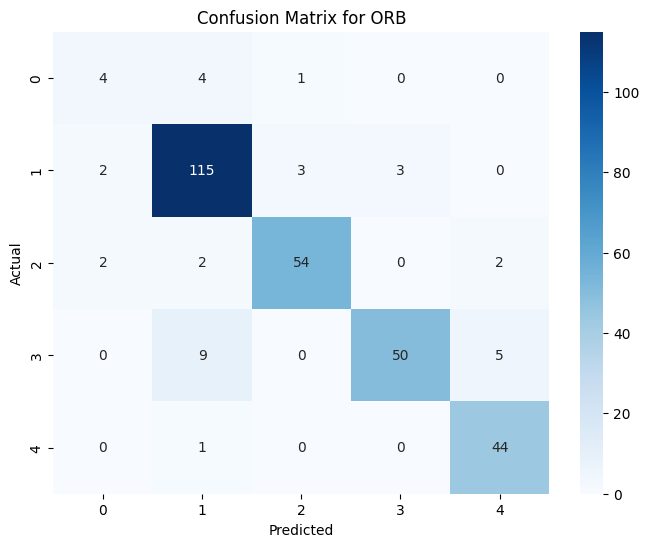


=== Test results for 'COLOR_HIST' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.89      0.93      0.91       123
           2       0.89      0.93      0.91        60
           3       0.92      0.73      0.82        64
           4       0.81      0.96      0.88        45

    accuracy                           0.87       301
   macro avg       0.80      0.78      0.78       301
weighted avg       0.87      0.87      0.87       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 114   4   3   0]
 [  0   2  56   0   2]
 [  1   8   0  47   8]
 [  0   0   1   1  43]]


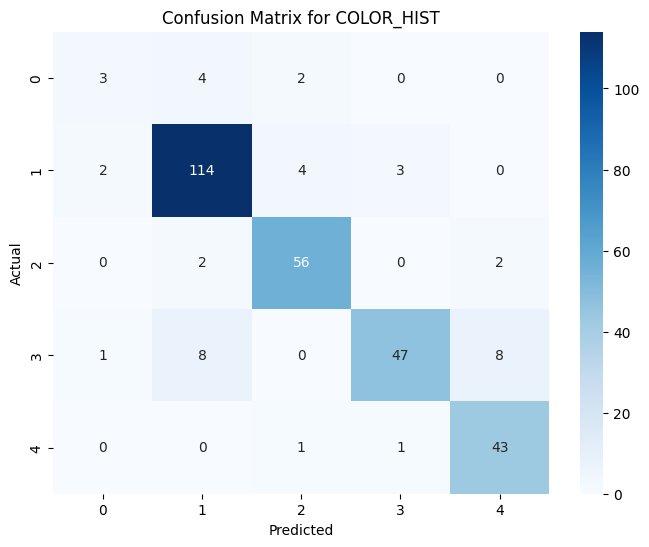


=== Test results for 'vit_svd' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.94      0.91       123
           2       0.90      0.90      0.90        60
           3       0.96      0.73      0.83        64
           4       0.83      1.00      0.91        45

    accuracy                           0.88       301
   macro avg       0.81      0.78      0.79       301
weighted avg       0.88      0.88      0.88       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  1 116   4   2   0]
 [  1   3  54   0   2]
 [  1   9   0  47   7]
 [  0   0   0   0  45]]


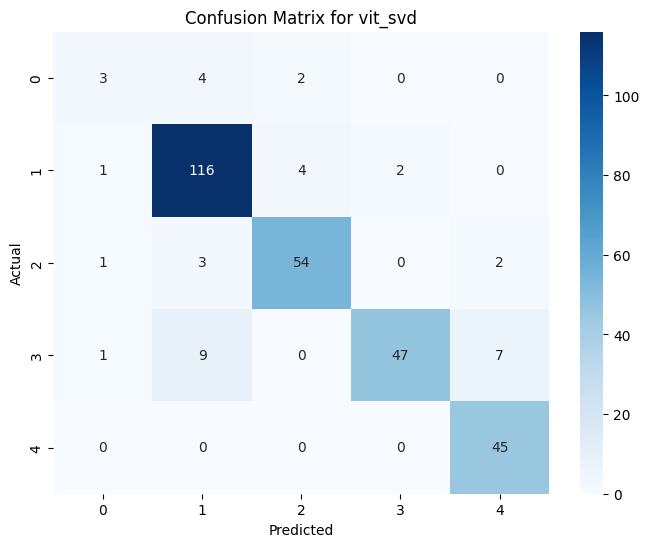


=== Test results for 'vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.89      0.93      0.91       123
           2       0.87      0.90      0.89        60
           3       0.96      0.78      0.86        64
           4       0.87      1.00      0.93        45

    accuracy                           0.88       301
   macro avg       0.80      0.79      0.79       301
weighted avg       0.88      0.88      0.88       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  1 114   6   2   0]
 [  2   2  54   0   2]
 [  1   8   0  50   5]
 [  0   0   0   0  45]]


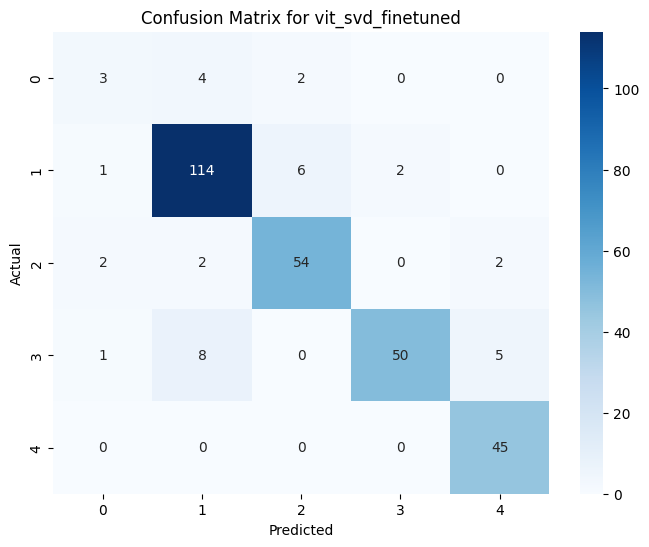


=== Test results for 'yolo' ===
              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.87      0.93      0.90       123
           2       0.92      0.92      0.92        60
           3       0.94      0.77      0.84        64
           4       0.88      0.98      0.93        45

    accuracy                           0.88       301
   macro avg       0.82      0.81      0.81       301
weighted avg       0.89      0.88      0.88       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 114   4   3   0]
 [  1   2  55   0   2]
 [  1  10   0  49   4]
 [  0   1   0   0  44]]


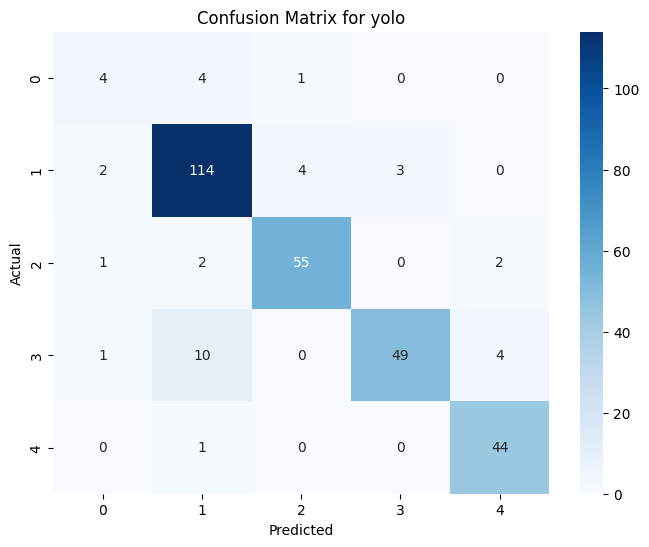


=== Test results for 'normal' ===
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.89      0.94      0.91       123
           2       0.89      0.93      0.91        60
           3       0.96      0.77      0.85        64
           4       0.87      1.00      0.93        45

    accuracy                           0.89       301
   macro avg       0.87      0.80      0.81       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  0 116   5   2   0]
 [  0   2  56   0   2]
 [  1   9   0  49   5]
 [  0   0   0   0  45]]


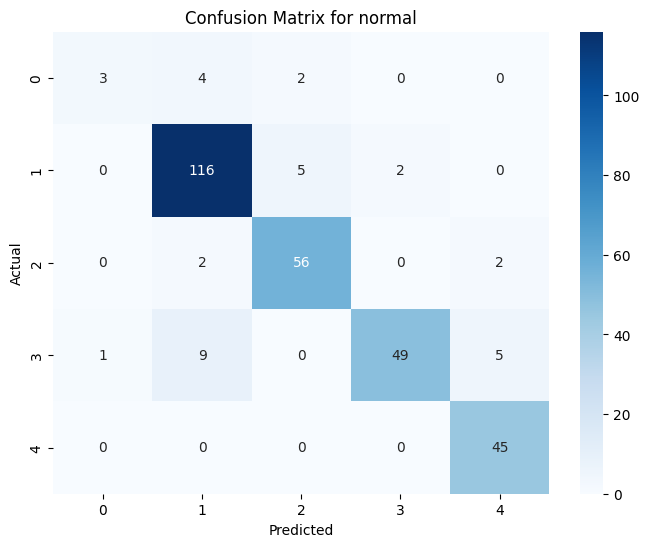


=== Test results for 'COLOR_HIST_HOG' ===
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.88      0.95      0.91       123
           2       0.93      0.93      0.93        60
           3       0.96      0.77      0.85        64
           4       0.85      0.98      0.91        45

    accuracy                           0.90       301
   macro avg       0.88      0.81      0.84       301
weighted avg       0.90      0.90      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  0 117   3   2   1]
 [  0   2  56   0   2]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


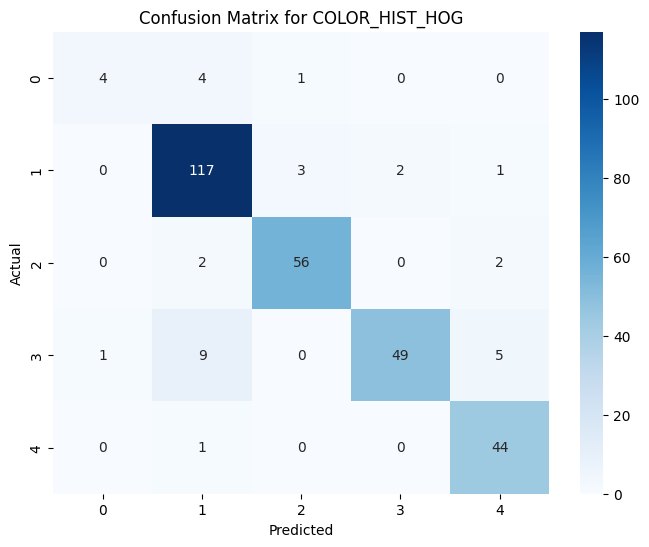


=== Test results for 'COLOR_HIST_SIFT' ===
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.88      0.93      0.91       123
           2       0.90      0.95      0.93        60
           3       0.94      0.78      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.87      0.80      0.81       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  1 115   4   3   0]
 [  0   2  57   0   1]
 [  0   9   0  50   5]
 [  0   1   0   0  44]]


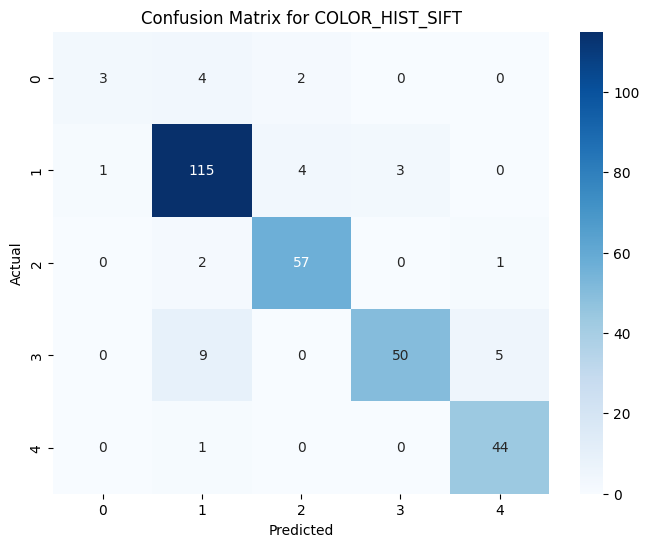


=== Test results for 'COLOR_HIST_vit_svd' ===
              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.88      0.93      0.91       123
           2       0.89      0.92      0.90        60
           3       0.98      0.78      0.87        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.80      0.79      0.79       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 115   5   1   0]
 [  2   2  55   0   1]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


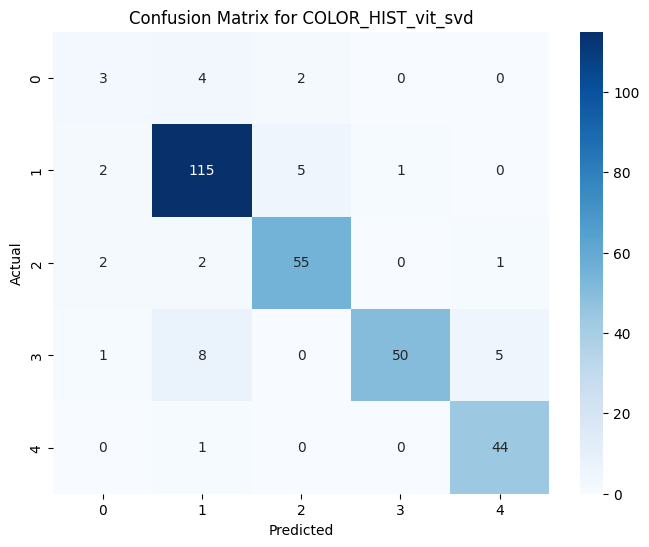


=== Test results for 'COLOR_HIST_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.88      0.93      0.91       123
           2       0.89      0.92      0.90        60
           3       0.98      0.75      0.85        64
           4       0.85      1.00      0.92        45

    accuracy                           0.88       301
   macro avg       0.81      0.79      0.79       301
weighted avg       0.89      0.88      0.88       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 115   5   1   0]
 [  1   2  55   0   2]
 [  1   9   0  48   6]
 [  0   0   0   0  45]]


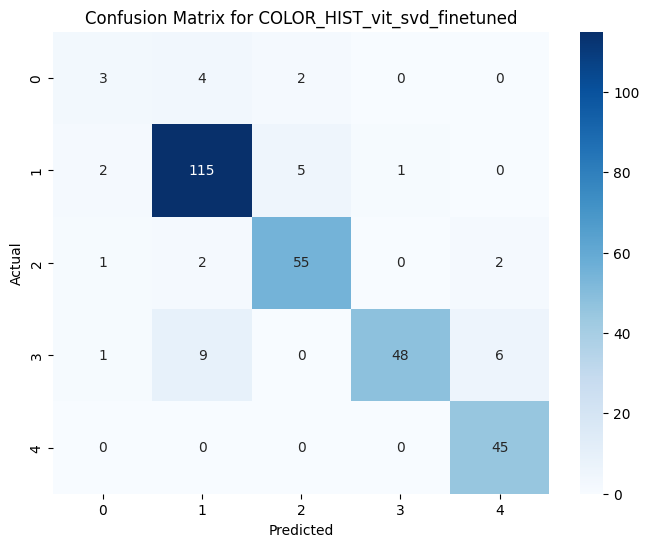


=== Test results for 'HOG_SIFT' ===
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.86      0.93      0.90       123
           2       0.92      0.95      0.93        60
           3       0.96      0.73      0.83        64
           4       0.86      0.96      0.91        45

    accuracy                           0.88       301
   macro avg       0.83      0.80      0.81       301
weighted avg       0.89      0.88      0.88       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 115   3   2   1]
 [  0   2  57   0   1]
 [  1  11   0  47   5]
 [  0   1   1   0  43]]


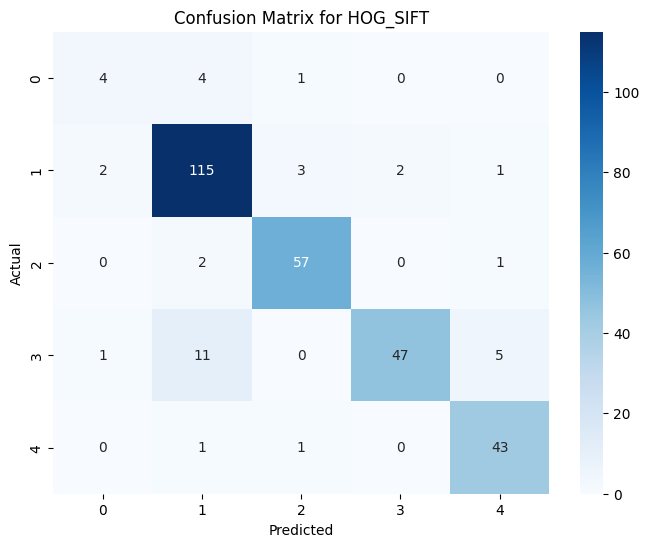


=== Test results for 'HOG_vit_svd' ===
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.88      0.93      0.91       123
           2       0.92      0.95      0.93        60
           3       0.96      0.77      0.85        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.86      0.81      0.83       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  1 115   4   2   1]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


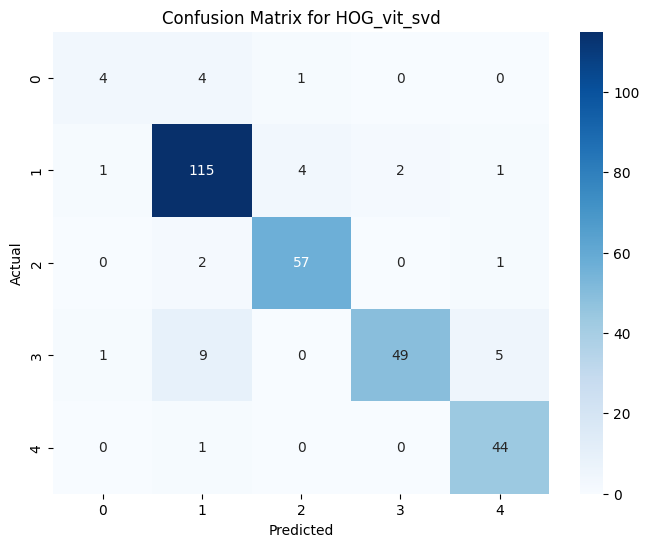


=== Test results for 'HOG_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.89      0.93      0.91       123
           2       0.90      0.93      0.92        60
           3       0.96      0.78      0.86        64
           4       0.85      0.98      0.91        45

    accuracy                           0.89       301
   macro avg       0.85      0.81      0.83       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  4   3   2   0   0]
 [  1 115   4   2   1]
 [  0   2  56   0   2]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


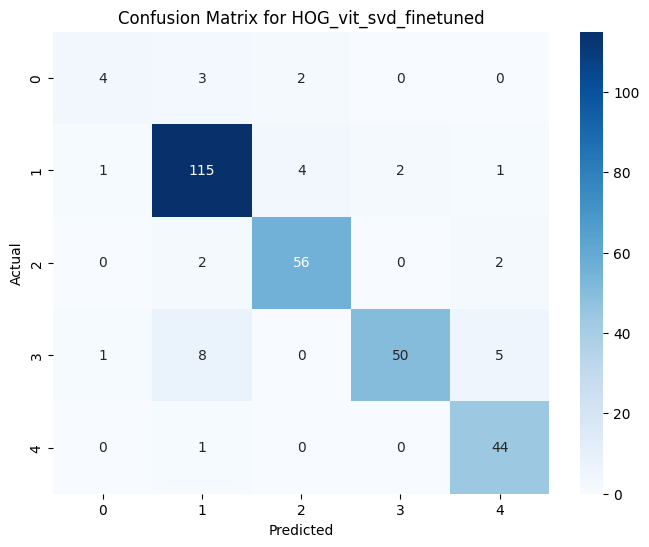


=== Test results for 'SIFT_vit_svd' ===
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.88      0.94      0.91       123
           2       0.93      0.95      0.94        60
           3       0.96      0.77      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.90       301
   macro avg       0.85      0.82      0.83       301
weighted avg       0.90      0.90      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 116   3   2   0]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


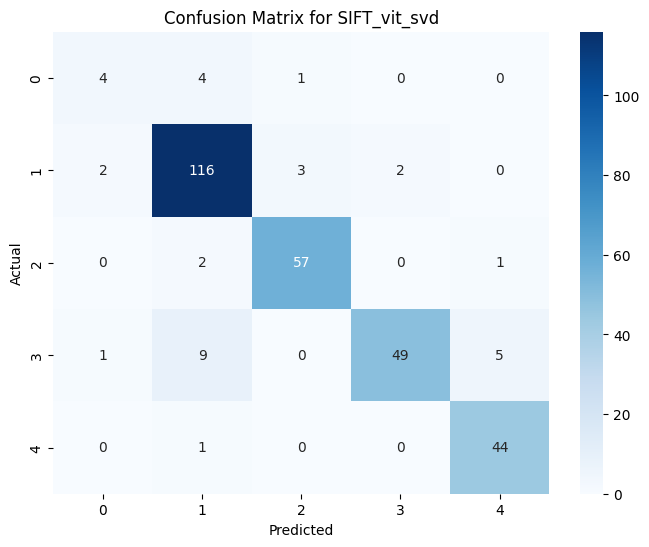


=== Test results for 'SIFT_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.94      0.91       123
           2       0.92      0.93      0.93        60
           3       0.96      0.77      0.85        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.82      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 116   3   2   0]
 [  0   2  56   0   2]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


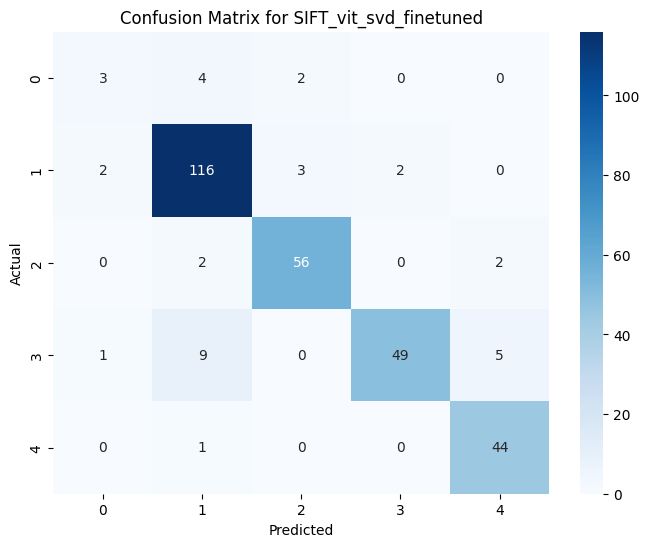


=== Test results for 'vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.88      0.93      0.91       123
           2       0.88      0.87      0.87        60
           3       0.96      0.73      0.83        64
           4       0.85      1.00      0.92        45

    accuracy                           0.87       301
   macro avg       0.79      0.80      0.79       301
weighted avg       0.88      0.87      0.87       301

Matriz de confusión:
 [[  4   3   2   0   0]
 [  1 115   5   2   0]
 [  4   2  52   0   2]
 [  1  10   0  47   6]
 [  0   0   0   0  45]]


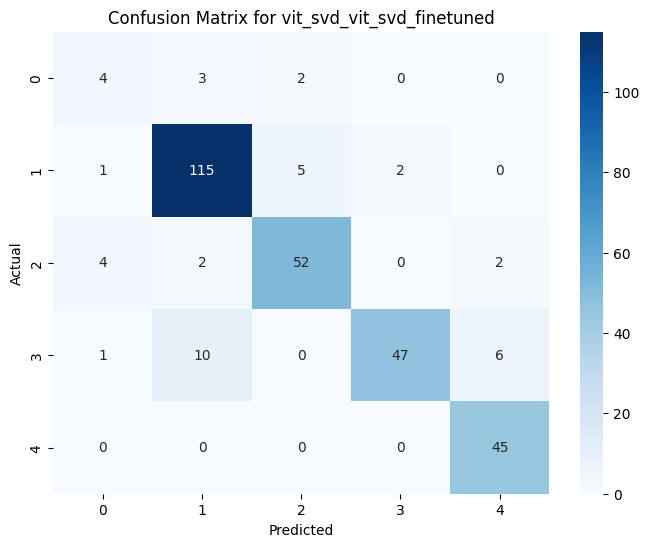


=== Test results for 'COLOR_HIST_HOG_SIFT' ===
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.88      0.93      0.91       123
           2       0.93      0.95      0.94        60
           3       0.94      0.77      0.84        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.84      0.81      0.82       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 115   3   3   0]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


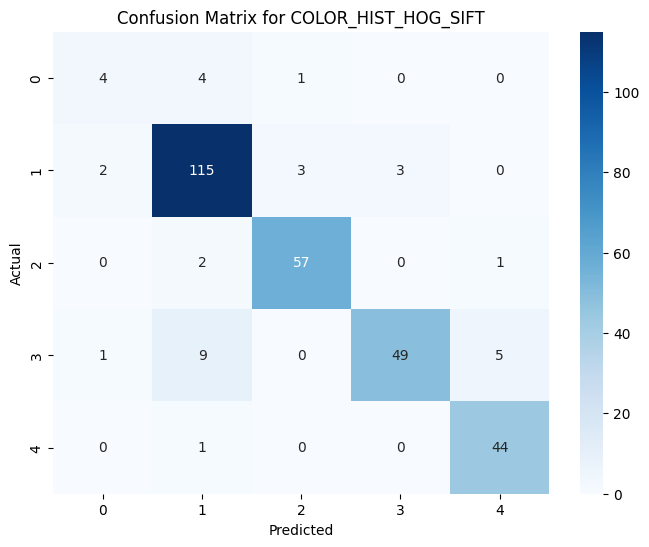


=== Test results for 'COLOR_HIST_HOG_vit_svd' ===
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.89      0.95      0.92       123
           2       0.93      0.93      0.93        60
           3       0.98      0.78      0.87        64
           4       0.85      0.98      0.91        45

    accuracy                           0.90       301
   macro avg       0.87      0.84      0.85       301
weighted avg       0.91      0.90      0.90       301

Matriz de confusión:
 [[  5   3   1   0   0]
 [  1 117   3   1   1]
 [  0   2  56   0   2]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


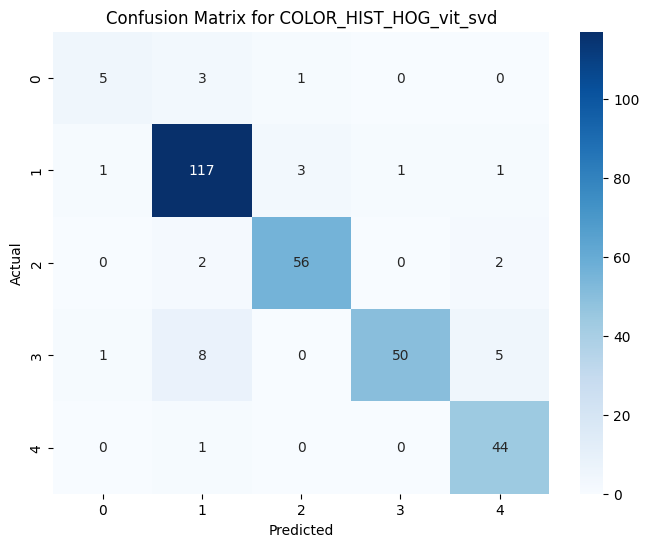


=== Test results for 'COLOR_HIST_HOG_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.88      0.93      0.90       123
           2       0.89      0.95      0.92        60
           3       0.96      0.77      0.85        64
           4       0.85      0.98      0.91        45

    accuracy                           0.89       301
   macro avg       0.84      0.79      0.80       301
weighted avg       0.89      0.89      0.88       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  1 114   5   2   1]
 [  0   2  57   0   1]
 [  1   8   0  49   6]
 [  0   1   0   0  44]]


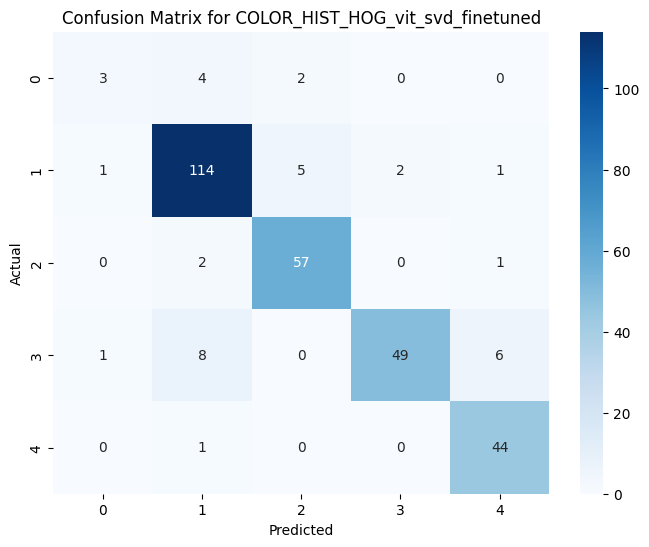


=== Test results for 'COLOR_HIST_SIFT_vit_svd' ===
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.88      0.93      0.91       123
           2       0.92      0.95      0.93        60
           3       0.94      0.75      0.83        64
           4       0.85      0.98      0.91        45

    accuracy                           0.89       301
   macro avg       0.88      0.81      0.83       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  1 115   4   3   0]
 [  0   2  57   0   1]
 [  0   9   0  48   7]
 [  0   1   0   0  44]]


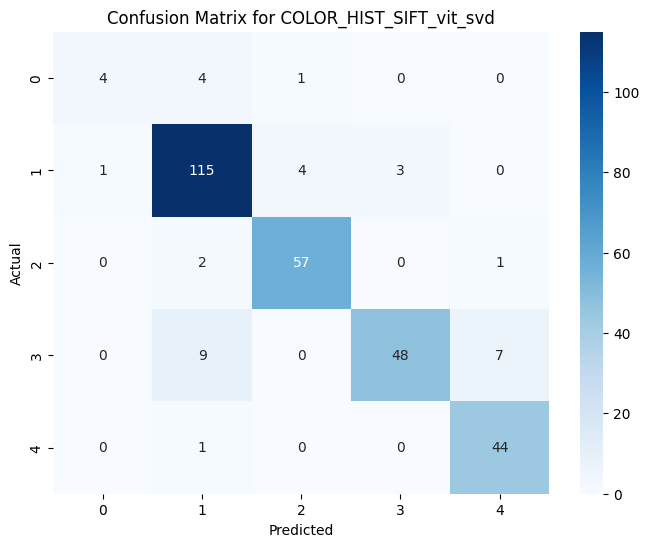


=== Test results for 'COLOR_HIST_SIFT_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.88      0.94      0.91       123
           2       0.90      0.95      0.93        60
           3       0.96      0.78      0.86        64
           4       0.88      0.98      0.93        45

    accuracy                           0.90       301
   macro avg       0.88      0.80      0.82       301
weighted avg       0.90      0.90      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  1 116   4   2   0]
 [  0   2  57   0   1]
 [  0   9   0  50   5]
 [  0   1   0   0  44]]


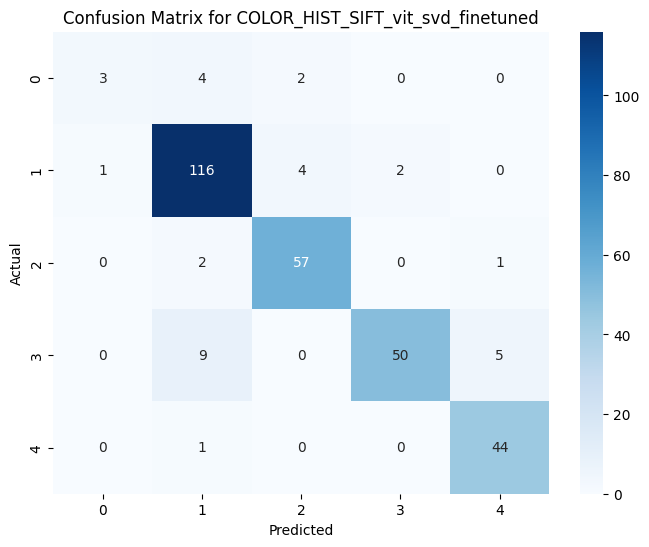


=== Test results for 'COLOR_HIST_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.89      0.93      0.91       123
           2       0.90      0.92      0.91        60
           3       0.98      0.77      0.86        64
           4       0.87      1.00      0.93        45

    accuracy                           0.89       301
   macro avg       0.82      0.81      0.81       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  4   3   2   0   0]
 [  3 115   4   1   0]
 [  1   2  55   0   2]
 [  1   9   0  49   5]
 [  0   0   0   0  45]]


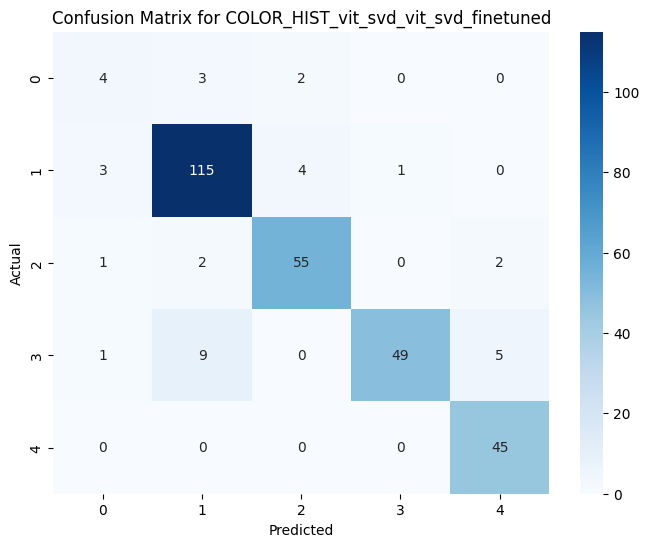


=== Test results for 'HOG_SIFT_vit_svd' ===
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.89      0.94      0.91       123
           2       0.93      0.93      0.93        60
           3       0.96      0.77      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.90       301
   macro avg       0.87      0.86      0.86       301
weighted avg       0.90      0.90      0.90       301

Matriz de confusión:
 [[  6   3   0   0   0]
 [  1 116   4   2   0]
 [  1   2  56   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


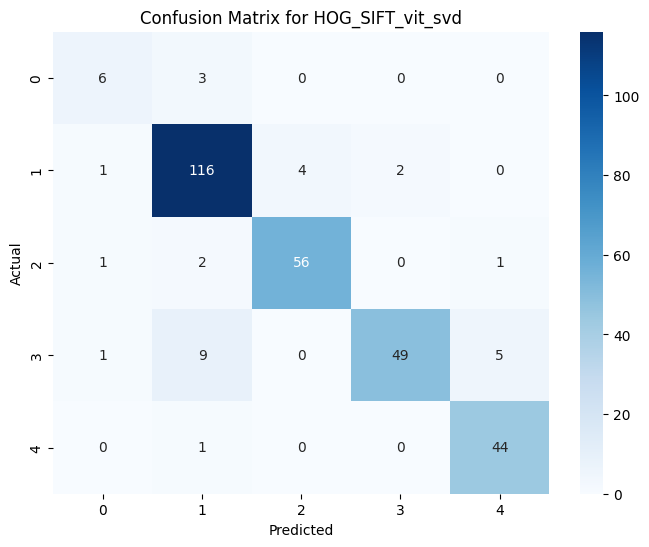


=== Test results for 'HOG_SIFT_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.94      0.91       123
           2       0.92      0.95      0.93        60
           3       0.96      0.77      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.83      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 116   3   2   0]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


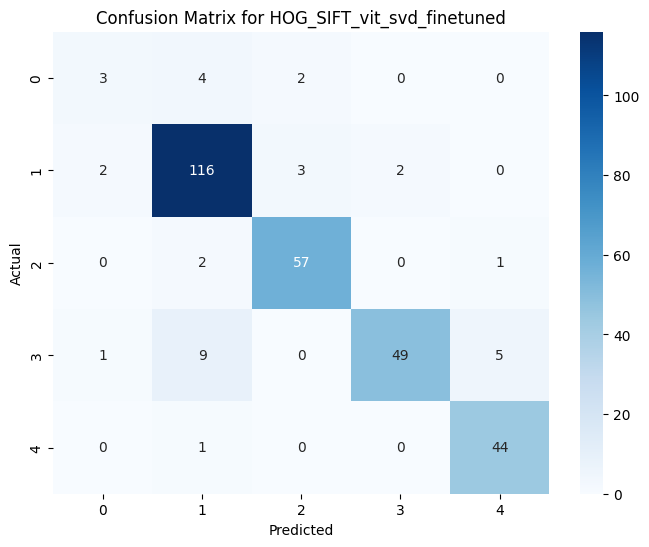


=== Test results for 'HOG_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.89      0.95      0.92       123
           2       0.92      0.92      0.92        60
           3       0.98      0.77      0.86        64
           4       0.85      0.98      0.91        45

    accuracy                           0.89       301
   macro avg       0.84      0.81      0.82       301
weighted avg       0.90      0.89      0.89       301

Matriz de confusión:
 [[  4   3   2   0   0]
 [  1 117   3   1   1]
 [  1   2  55   0   2]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


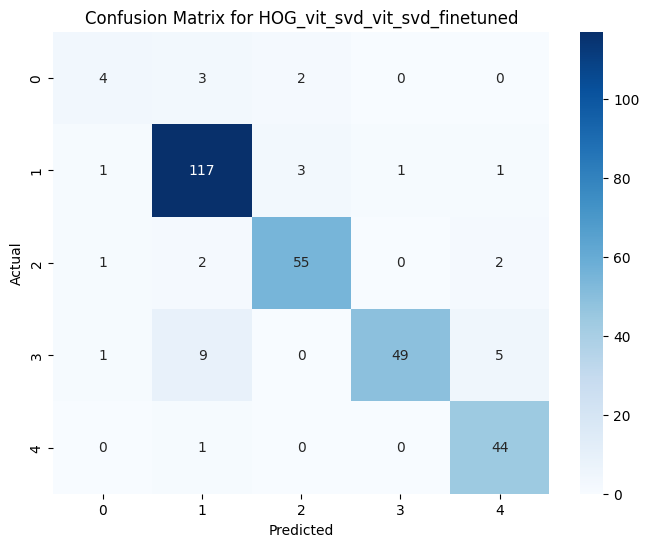


=== Test results for 'SIFT_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.89      0.94      0.91       123
           2       0.92      0.93      0.93        60
           3       0.96      0.78      0.86        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.81      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 116   3   2   0]
 [  1   2  56   0   1]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


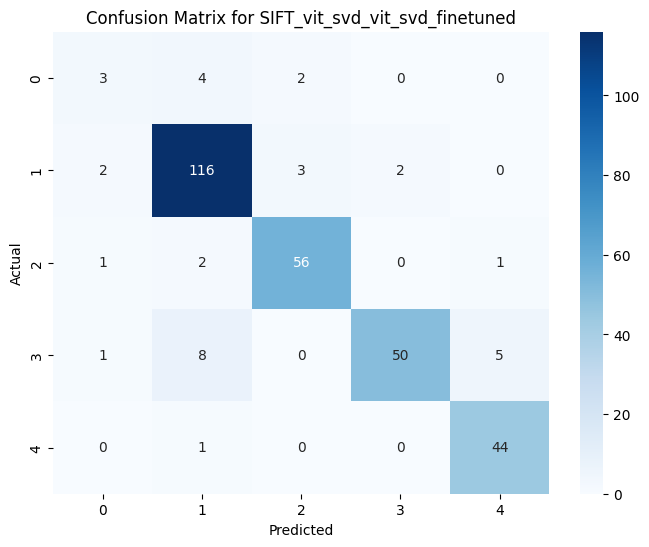


=== Test results for 'COLOR_HIST_HOG_SIFT_vit_svd' ===
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.87      0.93      0.90       123
           2       0.90      0.95      0.93        60
           3       0.96      0.72      0.82        64
           4       0.85      0.98      0.91        45

    accuracy                           0.88       301
   macro avg       0.83      0.80      0.81       301
weighted avg       0.88      0.88      0.88       301

Matriz de confusión:
 [[  4   4   1   0   0]
 [  2 114   5   2   0]
 [  0   2  57   0   1]
 [  1  10   0  46   7]
 [  0   1   0   0  44]]


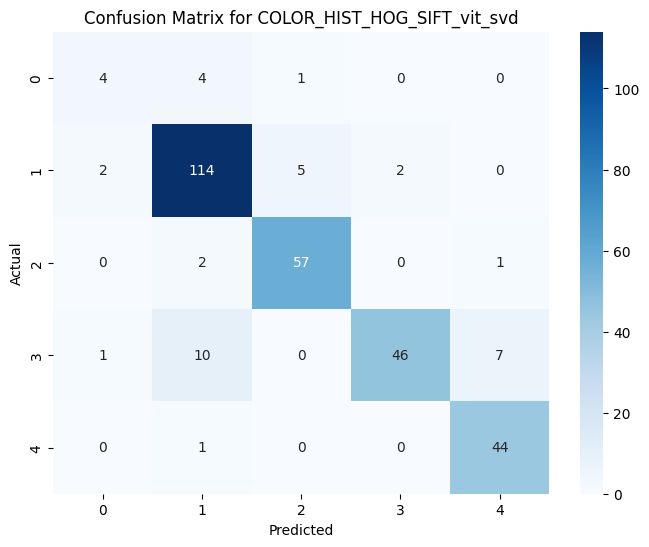


=== Test results for 'COLOR_HIST_HOG_SIFT_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.94      0.91       123
           2       0.92      0.95      0.93        60
           3       0.96      0.77      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.83      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 116   3   2   0]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


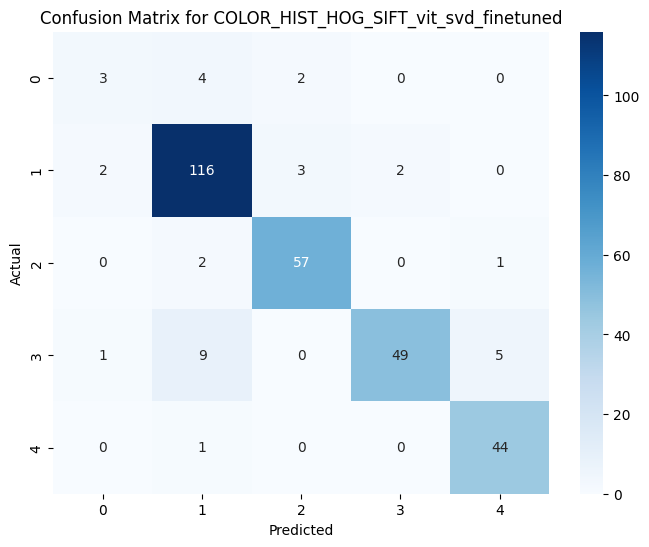


=== Test results for 'COLOR_HIST_HOG_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.88      0.93      0.90       123
           2       0.89      0.95      0.92        60
           3       0.96      0.77      0.85        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.85      0.81      0.83       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  4   3   2   0   0]
 [  1 114   5   2   1]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


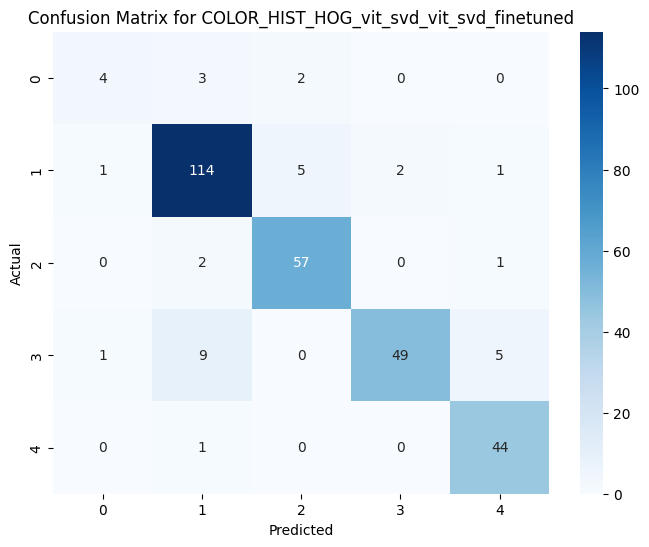


=== Test results for 'COLOR_HIST_SIFT_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.93      0.91       123
           2       0.90      0.93      0.92        60
           3       0.96      0.78      0.86        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.82      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 115   4   2   0]
 [  0   2  56   0   2]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


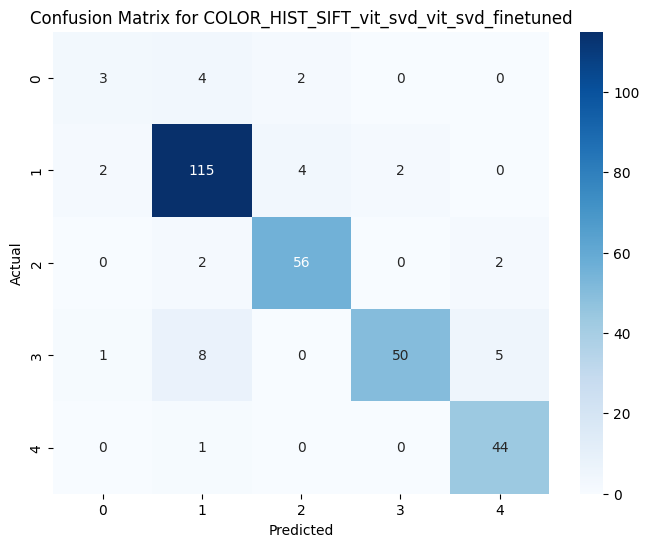


=== Test results for 'HOG_SIFT_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.93      0.91       123
           2       0.90      0.93      0.92        60
           3       0.96      0.78      0.86        64
           4       0.86      0.98      0.92        45

    accuracy                           0.89       301
   macro avg       0.82      0.79      0.80       301
weighted avg       0.89      0.89      0.89       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 115   4   2   0]
 [  0   2  56   0   2]
 [  1   8   0  50   5]
 [  0   1   0   0  44]]


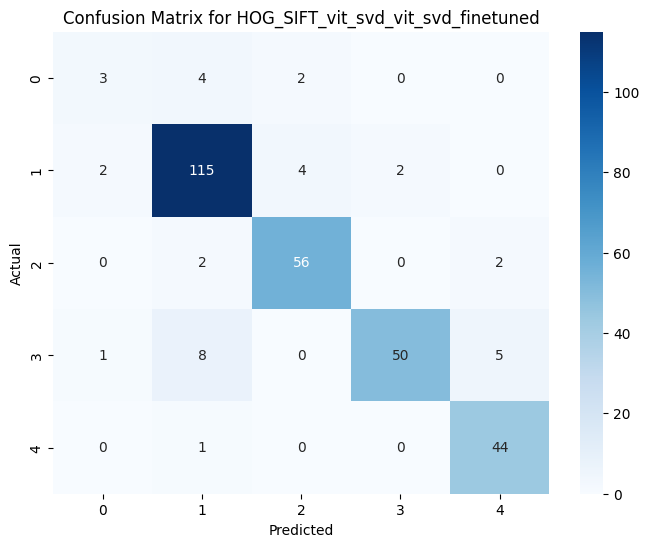


=== Test results for 'COLOR_HIST_HOG_SIFT_vit_svd_vit_svd_finetuned' ===
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.88      0.93      0.90       123
           2       0.89      0.95      0.92        60
           3       0.96      0.77      0.85        64
           4       0.88      0.98      0.93        45

    accuracy                           0.89       301
   macro avg       0.82      0.79      0.80       301
weighted avg       0.89      0.89      0.88       301

Matriz de confusión:
 [[  3   4   2   0   0]
 [  2 114   5   2   0]
 [  0   2  57   0   1]
 [  1   9   0  49   5]
 [  0   1   0   0  44]]


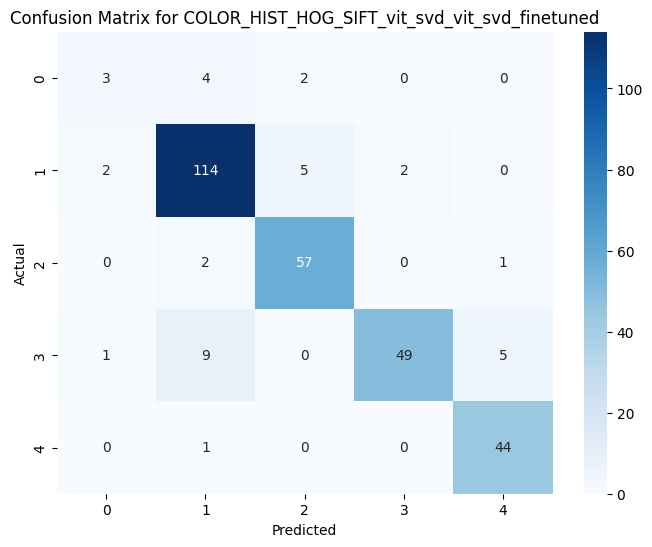

Ensemble Test: 0.8552081421243232 0.8955269518813123


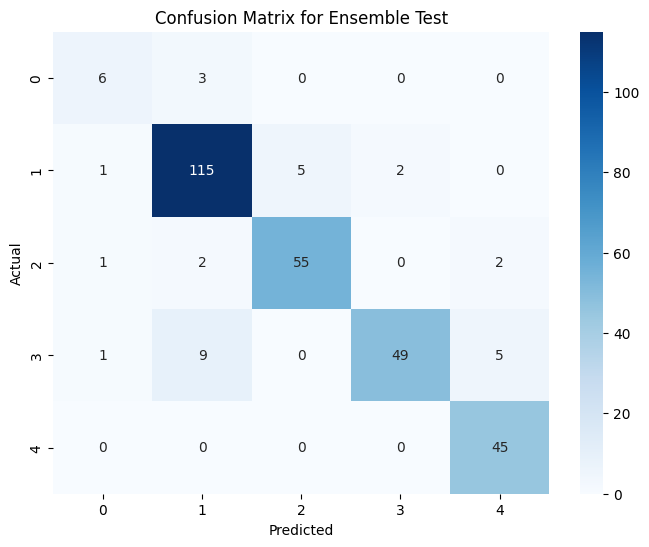

In [ ]:
topn_loaded = feature_extractor.load_topn()
best_scenario = model_trainer.load_best_scenario()
data_train, data_val, data_test = dataset_manager.leer_datasets_raiz()
X_train_base, X_val_base, X_test_base, y_train_base, y_val_base, y_test_base = dataset_manager.leer_datasets()

scenarios_test = {}

for feat_name, _ in feat_list:
    tr, va, te = dataset_manager.leer_features_adicionales(feat_name)
    Xtr, Ytr = dataset_manager.get_X_y(tr, cols_to_drop)
    Xva, Yva = dataset_manager.get_X_y(va, cols_to_drop)
    Xte, Yte = dataset_manager.get_X_y(te, cols_to_drop)
    scenarios_test[feat_name] = {"X_train": Xtr, "y_train": Ytr, "X_val": Xte, "y_val": Yte}

scenarios_test["normal"] = {"X_train": X_train_base, "y_train": y_train_base, "X_val": X_test_base, "y_val": y_test_base}

loaded_results, loaded_results_multi, best_scenario_global, best_macro_f1 = dataset_manager.load_val_results("val_results.json")
scenarios_test2 = model_trainer.create_all_scenarios(scenarios_test, topn_loaded)
all_scenarios_test = {**scenarios_test, **scenarios_test2}
test_results = model_trainer.evaluate_scenarios_test(loaded_results, all_scenarios_test, config, model_trainer)
test_results2 = model_trainer.evaluate_scenarios_test(loaded_results_multi, all_scenarios_test, config, model_trainer)

best_model_loaded, normal_model_loaded = model_trainer.load_ensemble_models()
X_test_ens = all_scenarios_test[best_scenario]["X_val"].copy()
y_test_ens = all_scenarios_test[best_scenario]["y_val"]
for col in X_train_base.columns:
    X_test_ens[col] = scenarios_test["normal"]["X_val"][col]
final_preds_ens = model_trainer.ensemble_predict(X_test_ens, best_model_loaded, normal_model_loaded, 0)
mf2, wf2, cm_ens2, cr_ens2 = model_trainer.evaluate_ensemble(y_test_ens, final_preds_ens)
print("Ensemble Test:", mf2, wf2)
model_trainer.ver_matriz_confusion('Ensemble Test', cm_ens2)


In [ ]:
from IPython.display import display, Markdown

def get_f1_scores_markdown_from_dict(results_dict):
    rows = []
    for scenario, scenario_data in results_dict.items():
        w_f1 = scenario_data["report"]["weighted avg"]["f1-score"]
        m_f1 = scenario_data["report"]["macro avg"]["f1-score"]
        rows.append((scenario, w_f1, m_f1))

    rows.sort(key=lambda x: x[2], reverse=True)

    table_md = "| Escenario | Weighted F1 | Macro F1 |\n"
    table_md += "|-----------|-------------|----------|\n"
    for r in rows:
        table_md += f"| {r[0]} | {r[1]:.4f} | {r[2]:.4f} |\n"
    return table_md

test_results = {**test_results, **test_results2}
display(Markdown(get_f1_scores_markdown_from_dict(test_results)))


| Escenario | Weighted F1 | Macro F1 |
|-----------|-------------|----------|
| HOG_SIFT_vit_svd | 0.8989 | 0.8584 |
| COLOR_HIST_HOG_vit_svd | 0.9017 | 0.8513 |
| COLOR_HIST_HOG | 0.8935 | 0.8356 |
| HOG | 0.8898 | 0.8327 |
| COLOR_HIST_SIFT_vit_svd | 0.8865 | 0.8307 |
| HOG_vit_svd | 0.8905 | 0.8284 |
| HOG_vit_svd_finetuned | 0.8908 | 0.8267 |
| SIFT_vit_svd | 0.8942 | 0.8261 |
| COLOR_HIST_HOG_vit_svd_vit_svd_finetuned | 0.8872 | 0.8253 |
| COLOR_HIST_HOG_SIFT | 0.8909 | 0.8238 |
| HOG_vit_svd_vit_svd_finetuned | 0.8911 | 0.8202 |
| COLOR_HIST_SIFT_vit_svd_finetuned | 0.8921 | 0.8173 |
| COLOR_HIST_SIFT | 0.8888 | 0.8150 |
| HOG_SIFT | 0.8806 | 0.8140 |
| normal | 0.8885 | 0.8131 |
| ORB | 0.8853 | 0.8125 |
| yolo | 0.8817 | 0.8112 |
| COLOR_HIST_vit_svd_vit_svd_finetuned | 0.8890 | 0.8107 |
| COLOR_HIST_HOG_SIFT_vit_svd | 0.8768 | 0.8106 |
| SIFT | 0.8821 | 0.8064 |
| HOG_SIFT_vit_svd_finetuned | 0.8897 | 0.8045 |
| COLOR_HIST_HOG_SIFT_vit_svd_finetuned | 0.8897 | 0.8045 |
| COLOR_HIST_HOG_vit_svd_finetuned | 0.8826 | 0.8024 |
| block | 0.8789 | 0.8024 |
| COLOR_HIST_SIFT_vit_svd_vit_svd_finetuned | 0.8868 | 0.8012 |
| HOG_SIFT_vit_svd_vit_svd_finetuned | 0.8868 | 0.8012 |
| SIFT_vit_svd_finetuned | 0.8865 | 0.8009 |
| SIFT_vit_svd_vit_svd_finetuned | 0.8907 | 0.8005 |
| COLOR_HIST_HOG_SIFT_vit_svd_vit_svd_finetuned | 0.8832 | 0.7998 |
| COLOR_HIST_vit_svd | 0.8851 | 0.7919 |
| vit_svd_finetuned | 0.8809 | 0.7917 |
| vit_svd_vit_svd_finetuned | 0.8725 | 0.7909 |
| COLOR_HIST_vit_svd_finetuned | 0.8804 | 0.7907 |
| pretrained | 0.8583 | 0.7907 |
| vit_svd | 0.8759 | 0.7902 |
| COLOR_HIST | 0.8697 | 0.7828 |
| svd_finetuned | 0.7684 | 0.7084 |
| svd | 0.8589 | 0.7066 |


## Parte 6. Evaluación temporal

In [ ]:

data_original = pd.read_excel(config.PATH_ARCHIVO_ENTRADA, engine='odf', header=1)

results_temporales = trainer.evaluate_temporal_hog(
    data_original=data_original,
    data_cleaner=data_cleaner,
    dataset_manager=dataset_manager,
    normal_model_path=os.path.join(config.PATH_ENSAMBLE, "normal_model.pkl"),
    hog_model_path=os.path.join(config.PATH_ENSAMBLE, "model_HOG.pkl")
)

df_results_temporales = pd.DataFrame(results_temporales).T
print(df_results_temporales.sort_values(by="F1 hog", ascending=False))


## Parte 7. Exploración exhaustiva de hiperparámetros

Mejores hiperparámetros encontrados:
 {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])), ('randomforest', RandomForestClassifier(n_estimators=1000, random_state=123))], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['rows', 'cols', 'aspect', 'nnz', 'min_nnz',
                                  'max_nnz', 'avg_nnz', 'std_nnz']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])]), 'randomforest': RandomForestClassifier(n_estimators=1000, random_state=123), 'preprocessor__force_int_remainder_cols': True, 'pr

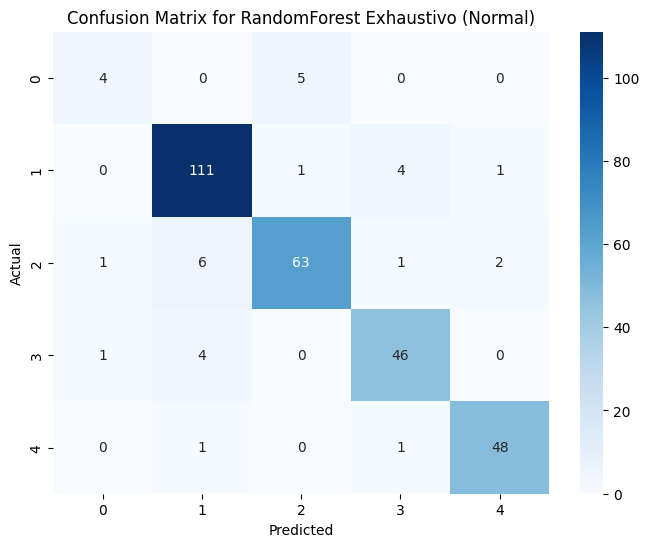

In [ ]:

exhaustive_param_grid = {
    "randomforest__n_estimators": [50, 100, 200, 300, 500, 1000],
    "randomforest__max_depth": [None, 5, 10, 20, 30],
    "randomforest__min_samples_split": [2, 4, 6, 8],
    "randomforest__min_samples_leaf": [1, 2, 4, 8],
    "randomforest__bootstrap": [True, False]
}

X_train_base, X_val_base, X_test_base, y_train_base, y_val_base, y_test_base = dataset_manager.leer_datasets()

best_model_exhaustive, evaluation_results_exhaustive, confusion_matrix_exhaustive = model_trainer.train_and_evaluate_model(
    model_name="randomforest",
    model=RandomForestClassifier(random_state=config.SEED),
    param_grid=exhaustive_param_grid,
    X_train=X_train_base,
    y_train=y_train_base,
    X_val=X_val_base,
    y_val=y_val_base
)

print("Mejores hiperparámetros encontrados:\n", best_model_exhaustive.get_params())
model_trainer.ver_matriz_confusion("RandomForest Exhaustivo (Normal)", confusion_matrix_exhaustive)


Macro F1 Score: 0.8181470216014052
Weighted F1 Score: 0.8952683226231668


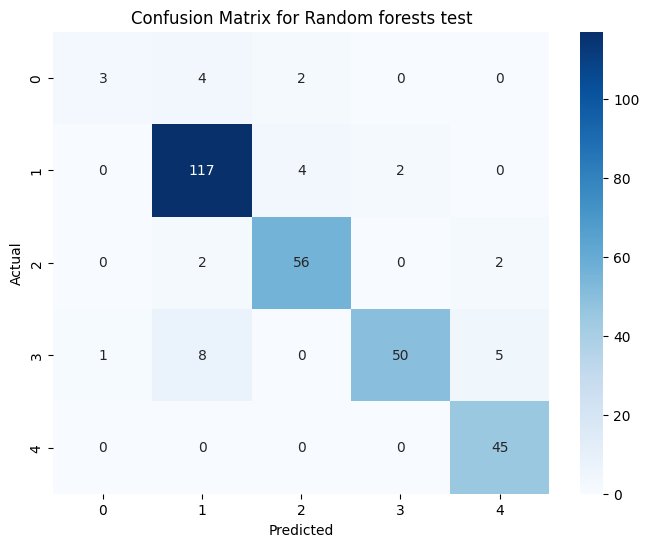

In [ ]:
X_train_base, X_val_base, X_test_base, y_train_base, y_val_base, y_test_base = dataset_manager.leer_datasets()
X_train_full = pd.concat([X_train_base, X_val_base], axis=0)
y_train_full = np.concatenate([y_train_base, y_val_base], axis=0)

X_train_full = pd.concat([X_train_base, X_val_base], axis=0)
y_train_full = np.concatenate([y_train_base, y_val_base], axis=0)

numeric_features = X_train_base.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_base.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

best_params = {
    'n_estimators': 1000,
    'random_state': 123,
    'bootstrap': True,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'criterion': 'gini'
}

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params))
])

model_pipeline.fit(X_train_base, y_train_base)
y_pred_test = model_pipeline.predict(X_test_base)

macro_f1 = f1_score(y_test_base, y_pred_test, average='macro')
weighted_f1 = f1_score(y_test_base, y_pred_test, average='weighted')
print(f"Macro F1 Score: {macro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")
model_trainer.ver_matriz_confusion("Random forests test",confusion_matrix(y_test_base, y_pred_test))
